In [1]:
import os, tempfile, shutil

PATH = "/home/idies/workspace/Temporary/dpark1"

def probe_dir(path, do_write_test=False):
    out = {}

    out["exists"] = os.path.isdir(path)
    if not out["exists"]:
        return out

    # On directories, X_OK (execute) = "can traverse"
    out["can_read"] = os.access(path, os.R_OK)
    out["can_traverse"] = os.access(path, os.X_OK)
    out["can_write"] = os.access(path, os.W_OK)

    # Try listing (needs read+execute on the dir)
    try:
        _ = next(os.scandir(path), None)  # efficient “first entry” peek
        out["list_ok"] = True
    except Exception as e:
        out["list_ok"] = f"FAIL: {type(e).__name__}: {e}"

    # Disk space
    try:
        total, used, free = shutil.disk_usage(path)
        out["disk_free_bytes"] = free
    except Exception as e:
        out["disk_free_bytes"] = f"UNKNOWN: {e}"

    # Optional write smoke test
    if do_write_test and out["can_write"]:
        try:
            tf = tempfile.NamedTemporaryFile(prefix="permtest_", dir=path, delete=False)
            name = tf.name
            tf.close()
            os.remove(name)
            out["write_test"] = "ok"
        except Exception as e:
            out["write_test"] = f"FAIL: {type(e).__name__}: {e}"
    elif do_write_test:
        out["write_test"] = "skipped (no write bit)"

    return out

res = probe_dir(PATH, do_write_test=True)
for k, v in res.items():
    print(f"{k}: {v}")


exists: True
can_read: True
can_traverse: True
can_write: False
list_ok: True
disk_free_bytes: 3636129161216
write_test: skipped (no write bit)


In [4]:
import os
import shutil

from mmap_ninja import RaggedMmap

# === CONFIG ===
BASE_DIR = "/home/idies/workspace/Temporary/dpark1/scratch/data"
NAME = "100k"  # mmap bundle folder name inside BASE_DIR
MODE = "r"     # read-only (recommended for shared folders)

# === FUNCTIONS ===
def check_dir(path, label):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"{label} not found or not a directory: {path}")
    if not os.access(path, os.R_OK):
        raise PermissionError(f"No read permission on {label}: {path}")
    if not os.access(path, os.X_OK):
        raise PermissionError(f"No execute/traverse permission on {label}: {path}")

def bytes_to_readable(n):
    for unit in ["B","KB","MB","GB","TB"]:
        if n < 1024:
            return f"{n:.1f} {unit}"
        n /= 1024.0
    return f"{n:.1f} PB"

# === CHECKS ===
check_dir(BASE_DIR, "Base directory")
mmap_path = os.path.join(BASE_DIR, NAME)
check_dir(mmap_path, "mmap directory")

try:
    _, _, free = shutil.disk_usage(mmap_path)
    print(f"[info] Free space under mmap dir: {bytes_to_readable(free)}")
except Exception as e:
    print(f"[warn] Could not get disk usage: {e}")

# === OPEN MEMMAP ===
print(f"[info] Opening RaggedMmap at: {mmap_path} (mode={MODE})")
memmap_obj = RaggedMmap(mmap_path, mode=MODE)
print(f"[ok] Opened mmap. Items: {len(memmap_obj)}")

# === PREVIEW FIRST ITEM ===
try:
    if len(memmap_obj) > 0:
        x0 = memmap_obj[0]
        shape = getattr(x0, "shape", None)
        dtype = getattr(x0, "dtype", None)
        print(f"[peek] First item type: {type(x0).__name__}, shape={shape}, dtype={dtype}")
except Exception as e:
    print(f"[warn] Could not peek first item: {e}")


[info] Free space under mmap dir: 5.2 PB
[info] Opening RaggedMmap at: /home/idies/workspace/Temporary/dpark1/scratch/data/100k (mode=r)
[ok] Opened mmap. Items: 106000
[peek] First item type: memmap, shape=(50, 64, 64), dtype=float64


In [5]:
import os, time
from pathlib import Path

BASE_DIR = "/home/idies/workspace/Temporary/dpark1/scratch/data"
NAME = "100k"
MMAP_PATH = Path(BASE_DIR) / NAME

print("Folder:", MMAP_PATH)
if not MMAP_PATH.is_dir():
    raise FileNotFoundError(f"Not a directory: {MMAP_PATH}")

entries = []
for p in sorted(MMAP_PATH.rglob("*")):
    if p.is_file():
        try:
            size = p.stat().st_size
            mtime = p.stat().st_mtime
        except Exception:
            size, mtime = None, None
        entries.append((str(p.relative_to(MMAP_PATH)), size, mtime))

# Pretty print
def fmt_size(n):
    if n is None: return "?"
    for unit in ["B","KB","MB","GB","TB"]:
        if n < 1024: return f"{n:.1f}{unit}"
        n /= 1024
    return f"{n:.1f}PB"

print(f"Found {len(entries)} files under {MMAP_PATH}:\n")
for rel, size, mtime in entries:
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(mtime)) if mtime else "?"
    print(f"{rel:<70} {fmt_size(size):>8}  {ts}")


Folder: /home/idies/workspace/Temporary/dpark1/scratch/data/100k
Found 48 files under /home/idies/workspace/Temporary/dpark1/scratch/data/100k:

.DS_Store                                                                 6.0KB  2024-12-30 16:23:49
data.ninja                                                              161.7GB  2024-12-30 18:02:53
dtype.ninja                                                                7.0B  2024-12-30 16:23:49
ends/data.ninja                                                         828.1KB  2024-12-30 16:23:51
ends/dtype.ninja                                                           5.0B  2024-12-30 16:23:51
ends/order.ninja                                                           1.0B  2024-12-30 16:23:51
ends/shape.ninja                                                           8.0B  2024-12-30 16:23:51
ends/type.ninja                                                            5.0B  2024-12-30 16:23:51
flattened_shapes/data.ninja                    

In [6]:
from mmap_ninja import RaggedMmap

mem = RaggedMmap(str(MMAP_PATH), mode="r")
print("Items in memmap:", len(mem))

# Inspect a few samples
N = min(5, len(mem))
shapes, dtypes = [], []
for i in range(N):
    x = mem[i]
    shapes.append(getattr(x, "shape", None))
    dtypes.append(getattr(x, "dtype", None))
    print(f"[{i}] type={type(x).__name__}, shape={getattr(x, 'shape', None)}, dtype={getattr(x, 'dtype', None)}")

print("\nUnique shapes among first", N, ":", sorted(set(shapes)))
print("Unique dtypes among first", N, ":", sorted(set(dtypes)))


Items in memmap: 106000
[0] type=memmap, shape=(50, 64, 64), dtype=float64
[1] type=memmap, shape=(50, 64, 64), dtype=float64
[2] type=memmap, shape=(50, 64, 64), dtype=float64
[3] type=memmap, shape=(50, 64, 64), dtype=float64
[4] type=memmap, shape=(50, 64, 64), dtype=float64

Unique shapes among first 5 : [(50, 64, 64)]
Unique dtypes among first 5 : [dtype('float64')]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def show_scalar_field(arr, title="Scalar field"):
    if arr.ndim != 2:
        raise ValueError(f"Expected 2D array, got shape {arr.shape}")
    plt.figure()
    plt.imshow(arr)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_vector_field(vec, title="Velocity field (u,v)", quiver_step=8):
    """
    vec: (H, W, 2) with channels [u, v]
    quiver_step: downsample for quiver so the plot isn't cluttered
    """
    if vec.ndim != 3 or vec.shape[-1] < 2:
        raise ValueError(f"Expected (H, W, 2) array, got shape {vec.shape}")
    u = vec[..., 0]
    v = vec[..., 1]
    speed = np.sqrt(u*u + v*v)

    # 1) speed heatmap
    plt.figure()
    plt.imshow(speed)
    plt.colorbar()
    plt.title(f"{title} — speed magnitude")
    plt.axis("off")
    plt.show()

    # 2) quiver (downsampled)
    H, W = u.shape
    yy, xx = np.mgrid[0:H:quiver_step, 0:W:quiver_step]
    uu = u[::quiver_step, ::quiver_step]
    vv = v[::quiver_step, ::quiver_step]

    plt.figure()
    plt.quiver(xx, yy, uu, vv)
    plt.gca().invert_yaxis()  # put origin top-left to match imshow
    plt.title(f"{title} — quiver (step={quiver_step})")
    plt.axis("equal")
    plt.show()


Sample 0 shape: (50, 64, 64) dtype: float64


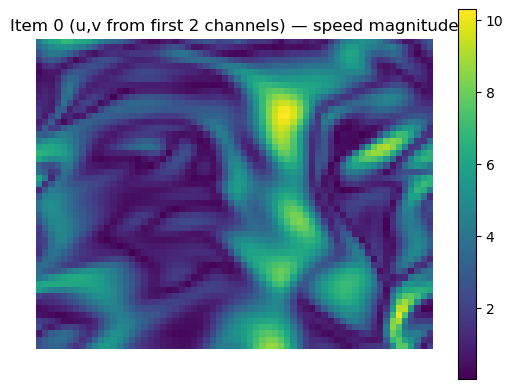

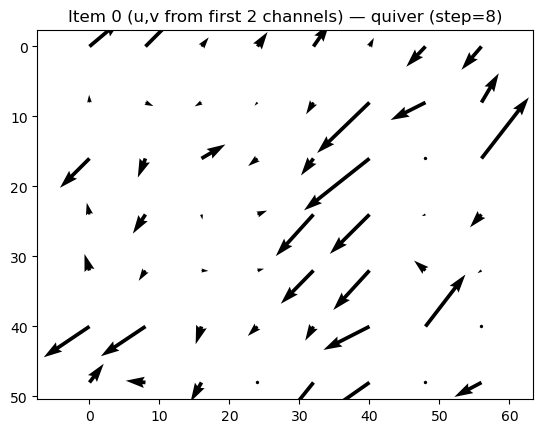

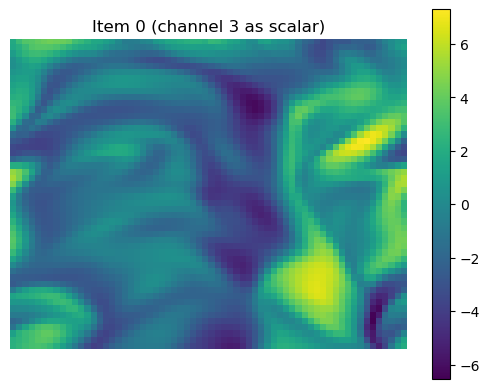

In [8]:
idx = 0  # change this to browse different samples
x = mem[idx]
print("Sample", idx, "shape:", getattr(x, "shape", None), "dtype:", getattr(x, "dtype", None))

if hasattr(x, "shape") and x.ndim == 2:
    # Likely a scalar field (e.g., pressure/vorticity)
    show_scalar_field(x, title=f"Item {idx} (scalar)")

elif hasattr(x, "shape") and x.ndim == 3:
    H, W, C = x.shape
    if C == 2:
        # Likely (u, v)
        show_vector_field(x, title=f"Item {idx} (u,v)")
    elif C >= 3:
        # Heuristic: first two channels are velocity, third could be pressure
        uv = x[..., :2]
        show_vector_field(uv, title=f"Item {idx} (u,v from first 2 channels)")
        # Optional: show channel 3 as scalar if present
        if C >= 3:
            show_scalar_field(x[..., 2], title=f"Item {idx} (channel 3 as scalar)")
    else:
        # Another layout? try treating as scalar stack
        show_scalar_field(x[..., 0], title=f"Item {idx} (channel 0)")

else:
    print("Item is not a NumPy-like array, or has unexpected shape. Inspect the object directly:")
    print(type(x), dir(x)[:25])


In [9]:
import numpy as np

# If you already have mem or memmap_obj from earlier, this will use it.
mm = mem if 'mem' in globals() else memmap_obj

item_idx = 0  # change to browse other samples in the mmap
X = mm[item_idx]
print("Item shape:", getattr(X, "shape", None), "dtype:", getattr(X, "dtype", None))

# Expect (T, H, W). If it's not, we can rearrange, but based on your note it is (50, 64, 64).
T, H, W = X.shape


Item shape: (50, 64, 64) dtype: float64


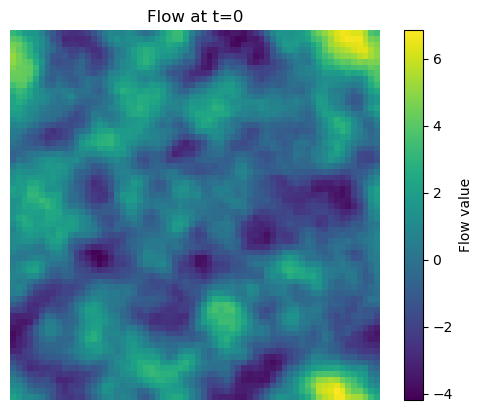

In [13]:
import matplotlib.pyplot as plt

# Pick the item and time step you want
item_idx = 0
time_step = 0  # from 0 to 49

# Load from your mmap
flow = mem[item_idx]  # shape (50, 64, 64)
frame = flow[time_step]  # shape (64, 64)

plt.imshow(frame, cmap='viridis')  # or 'jet', 'plasma', etc.
plt.colorbar(label="Flow value")
plt.title(f"Flow at t={time_step}")
plt.axis("off")
plt.show()


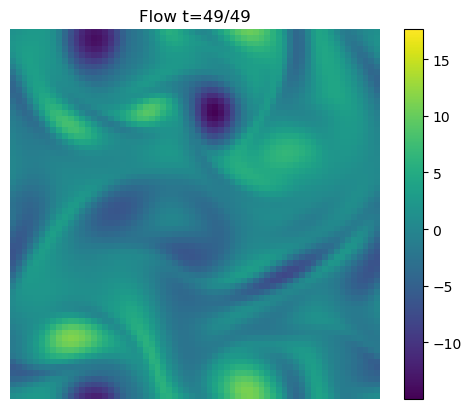

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- config ---
item_idx = 0          # which item in your mmap
start_t, end_t = 0, None  # time range (None = last frame)

# --- load data ---
flow = mem[item_idx]          # shape (T, 64, 64)
T = flow.shape[0]
if end_t is None or end_t > T:
    end_t = T
frames = flow[start_t:end_t]

# consistent color scale across all frames
vmin = float(np.nanmin(frames))
vmax = float(np.nanmax(frames))

# --- build animation ---
fig, ax = plt.subplots()
im = ax.imshow(frames[0], vmin=vmin, vmax=vmax)  # let matplotlib pick default colormap
ax.set_title(f"Flow t={start_t}/{end_t-1}")
ax.axis("off")
cb = plt.colorbar(im, ax=ax)

def update(frame_idx):
    im.set_data(frames[frame_idx])
    ax.set_title(f"Flow t={start_t+frame_idx}/{end_t-1}")
    return (im,)

ani = FuncAnimation(fig, update, frames=frames.shape[0], interval=100, blit=True)

# Display as HTML5 video (no external dependencies)
HTML(ani.to_jshtml())

# If you prefer to save:
# ani.save("flow_animation.mp4", fps=10)      # requires ffmpeg available on system
# ani.save("flow_animation.gif", fps=10)      # slower; uses Pillow writer


In [16]:
import os
import numpy as np

# If you already have `mem` defined from earlier, this will just use it.
try:
    _ = len(mem)  # will raise if not defined
except NameError:
    from mmap_ninja import RaggedMmap
    BASE_DIR = "/home/idies/workspace/Temporary/dpark1/scratch/data"
    NAME = "100k"
    mmap_path = os.path.join(BASE_DIR, NAME)
    mem = RaggedMmap(mmap_path, mode="r")

print(f"RaggedMmap ready. Items: {len(mem)}")


RaggedMmap ready. Items: 106000


In [17]:
import numpy as np

# How many items to use out of the full dataset
MAX_ITEMS = 1000
rng = np.random.default_rng(0)  # seed for reproducibility

num_items_total = len(mem)
chosen_item_idxs = rng.choice(num_items_total, size=min(MAX_ITEMS, num_items_total), replace=False)
chosen_item_idxs = np.sort(chosen_item_idxs)

# We’ll assume each item has T>=2 (you said T=50). For each chosen item,
# we create pairs (t -> t+1) for all t in [0, T-2].
# We'll *not* materialize data; just store (item_idx, t) pairs as an index list.

index_pairs = []
# Peek one item to get T (assumes all items have same T)
T = mem[int(chosen_item_idxs[0])].shape[0]
assert T >= 2, "Each item must have at least 2 time steps for next-step prediction."

for it in chosen_item_idxs:
    for t in range(T - 1):
        index_pairs.append((int(it), int(t)))

index_pairs = np.array(index_pairs, dtype=np.int64)
print(f"Using {len(chosen_item_idxs)} items, built {len(index_pairs)} (t→t+1) pairs "
      f"({T-1} per item; T={T}).")


Using 1000 items, built 49000 (t→t+1) pairs (49 per item; T=50).


In [35]:
import torch
import numpy as np
from torch.utils.data import Dataset

class RaggedNextStepDataset(Dataset):
    """
    Returns (x_t, x_{t+1}) as float32 tensors shaped (1, H, W).
    Applies optional z-normalization and a persistent sparsity mask per image (item_idx, t).
    """
    def __init__(self, memmap, index_pairs, normalize=False, sparsity=0.2, seed=None,
                 mean=0.0, std=2.4036, persist_masks=True, use_nan=False):
        self.mem = memmap
        self.index_pairs = index_pairs           # array of (item_idx, t)
        self.normalize = normalize
        self.sparsity = float(sparsity)
        self.seed = int(seed) if seed is not None else None
        self.mean = float(mean)
        self.std = float(std)
        self.persist_masks = bool(persist_masks)
        self.use_nan = bool(use_nan)             # if True, drop pixels -> NaN instead of 0
        self._mask_cache = {}                    # cache by (item_idx, t, H, W)

    def z_normalize(self, arr):
        return (arr - self.mean) / self.std

    def z_unnormalize(self, arr):
        return arr * self.std + self.mean

    def __len__(self):
        return len(self.index_pairs)

    def _per_image_mask(self, item_idx, t, shape):
        if self.sparsity >= 1.0:
            return None
    
        key = (int(item_idx), int(t), int(shape[0]), int(shape[1]))
        if self.persist_masks and key in self._mask_cache:
            return self._mask_cache[key]
    
        # Robust, overflow-free seeding:
        # - If self.seed is provided, include it so runs are reproducible.
        # - item_idx and t make each image's mask unique & stable.
        if self.seed is None:
            ss = np.random.SeedSequence([int(item_idx), int(t)])
        else:
            ss = np.random.SeedSequence([int(self.seed), int(item_idx), int(t)])
    
        rng = np.random.default_rng(np.random.PCG64(ss))
    
        mask = (rng.random(shape) < self.sparsity).astype(np.float32)
    
        if self.persist_masks:
            self._mask_cache[key] = mask
        return mask


    def __getitem__(self, i):
        item_idx, t = self.index_pairs[i]
        seq = self.mem[item_idx]                      # (T, H, W)
        x  = np.asarray(seq[t],   dtype=np.float32)   # (H, W)
        y  = np.asarray(seq[t+1], dtype=np.float32)   # (H, W)

        if self.normalize:
            x = self.z_normalize(x)
            y = self.z_normalize(y)

        if self.sparsity < 1.0:
            mask = self._per_image_mask(item_idx, t, x.shape)
            if mask is not None:
                if self.use_nan:
                    x = np.where(mask > 0, x, np.nan)
                else:
                    x = x * mask

        x = torch.from_numpy(x[None, ...])            # (1, H, W)
        y = torch.from_numpy(y[None, ...])
        return x, y


Train batches: 1379 | Val batches: 154
xb: torch.Size([32, 1, 64, 64]) torch.float32
yb: torch.Size([32, 1, 64, 64]) torch.float32


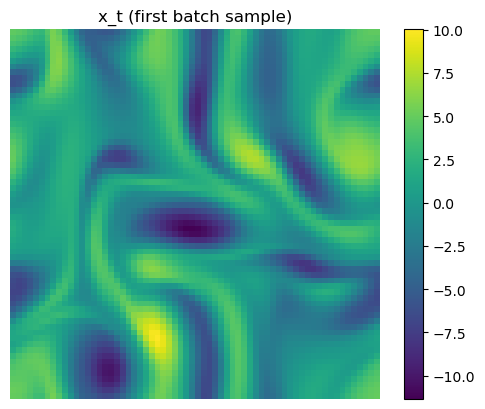

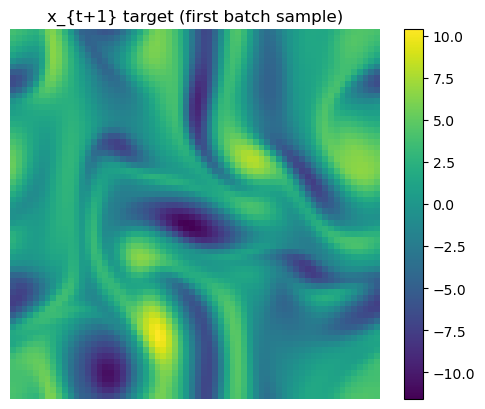

In [20]:


# Create the full dataset (choose normalization if you like)
full_ds = RaggedNextStepDataset(mem, index_pairs, normalize=None)  # or 'per_sample'

# Split (e.g., 90% train / 10% val)
val_frac = 0.10
val_len = int(len(full_ds) * val_frac)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(0))

# DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2  # tweak for your node; can be 0 if workers misbehave on NFS-backed storage
PIN_MEMORY = False

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

import matplotlib.pyplot as plt

xb, yb = next(iter(train_loader))
print("xb:", xb.shape, xb.dtype)  # [B, 1, 64, 64]
print("yb:", yb.shape, yb.dtype)

# visualize first sample in the batch
i = 0
plt.figure()
plt.imshow(xb[i, 0].cpu().numpy())
plt.colorbar()
plt.title("x_t (first batch sample)")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(yb[i, 0].cpu().numpy())
plt.colorbar()
plt.title("x_{t+1} target (first batch sample)")
plt.axis("off")
plt.show()



x: torch.Size([1, 64, 64]) y: torch.Size([1, 64, 64])
x min/max: -2.2787702083587646 2.0786828994750977


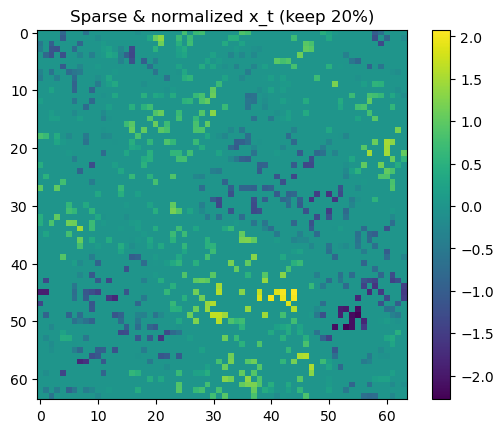

In [24]:
SPARSITY = 0.2

dataset = RaggedNextStepDataset(
    mem,
    index_pairs,
    normalize=True,       # apply fixed mean/std normalization
    sparsity=SPARSITY,
    seed=42,
    mean=0.0,
    std=2.4036
)

x, y = dataset[0]
print("x:", x.shape, "y:", y.shape)
print("x min/max:", x.min().item(), x.max().item())

import matplotlib.pyplot as plt
plt.imshow(x[0].numpy(), cmap="viridis")
plt.colorbar()
plt.title(f"Sparse & normalized x_t (keep {SPARSITY*100:.0f}%)")
plt.show()


Training on cuda
Total parameters: 34.99M
Using 1000 items; built 49000 (t→t+1) pairs with T=50.


Epoch 1/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   1/50] train 1.8603 | val 1.8411 | lr 2.00e-04


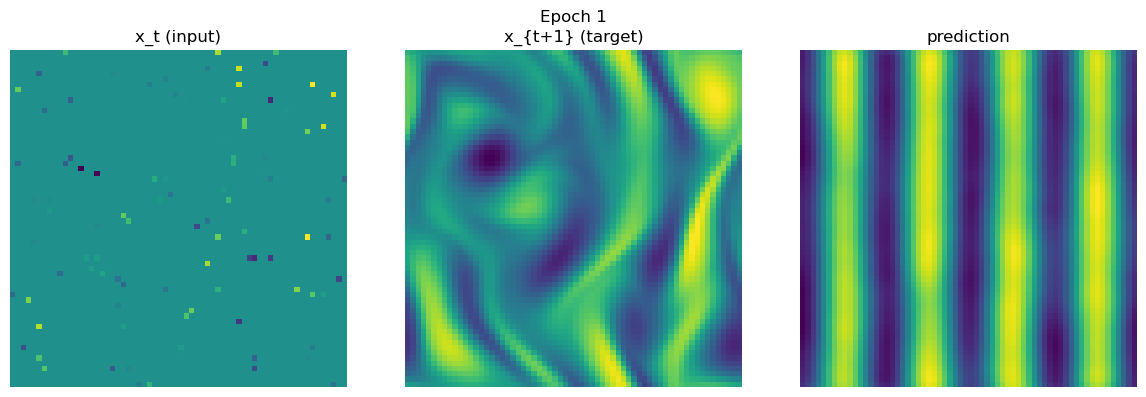

Epoch 2/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   2/50] train 1.8430 | val 1.8397 | lr 1.99e-04


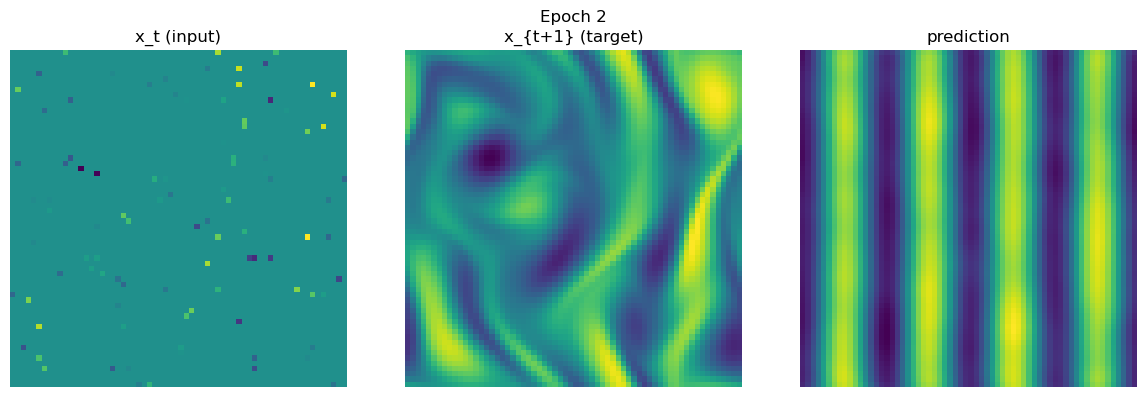

Epoch 3/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   3/50] train 1.8418 | val 1.8397 | lr 1.98e-04


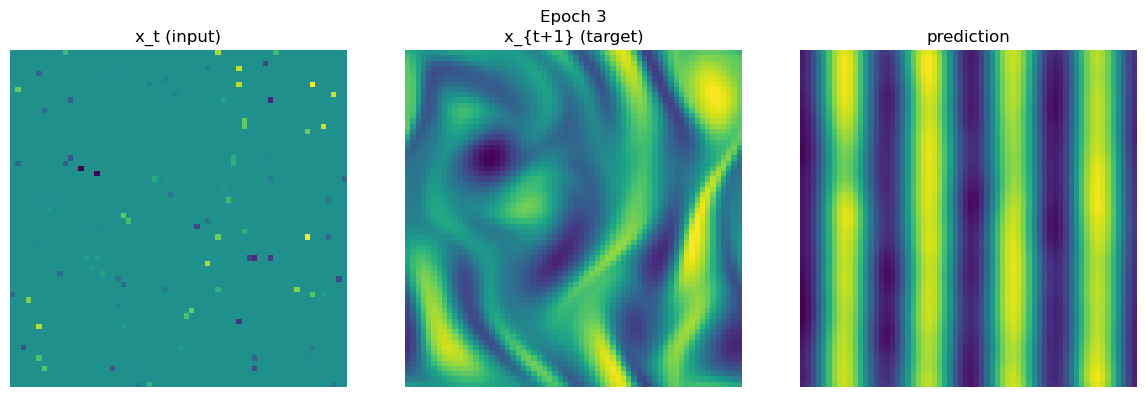

Epoch 4/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   4/50] train 1.8413 | val 1.8414 | lr 1.97e-04


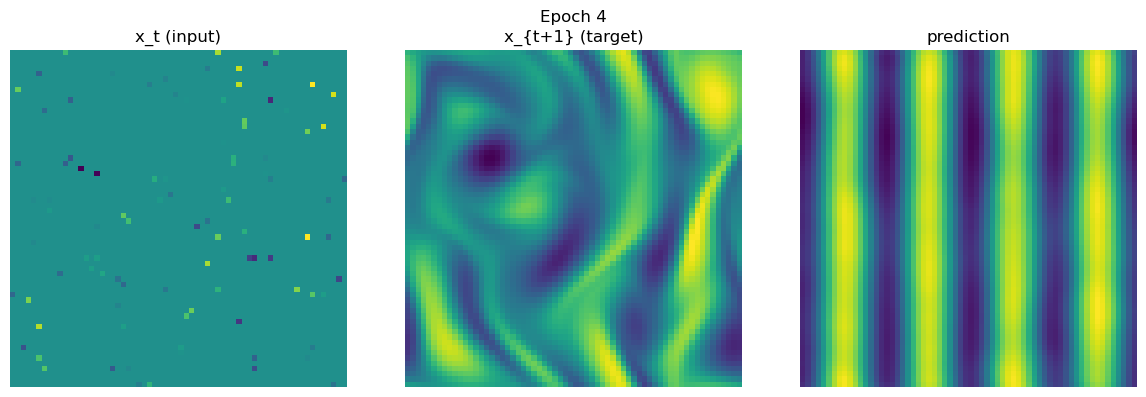

Epoch 5/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   5/50] train 1.8414 | val 1.8399 | lr 1.95e-04


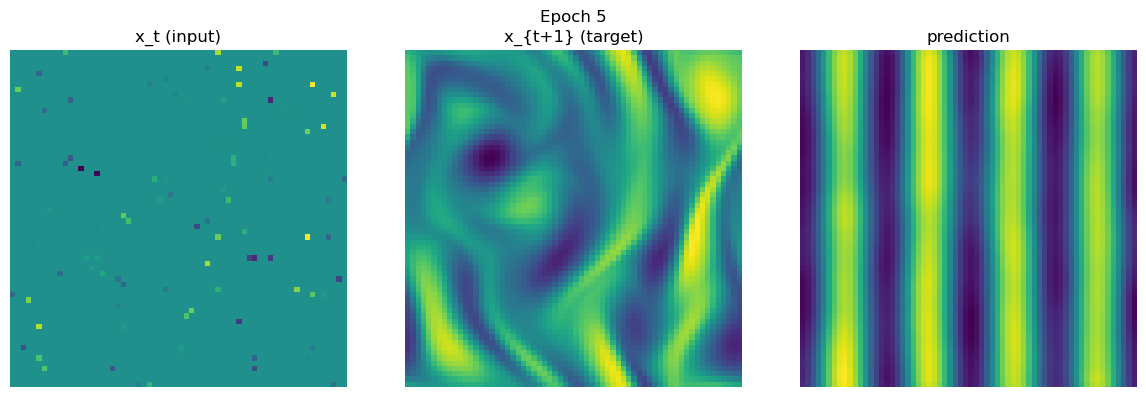

Epoch 6/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   6/50] train 1.8409 | val 1.8390 | lr 1.93e-04


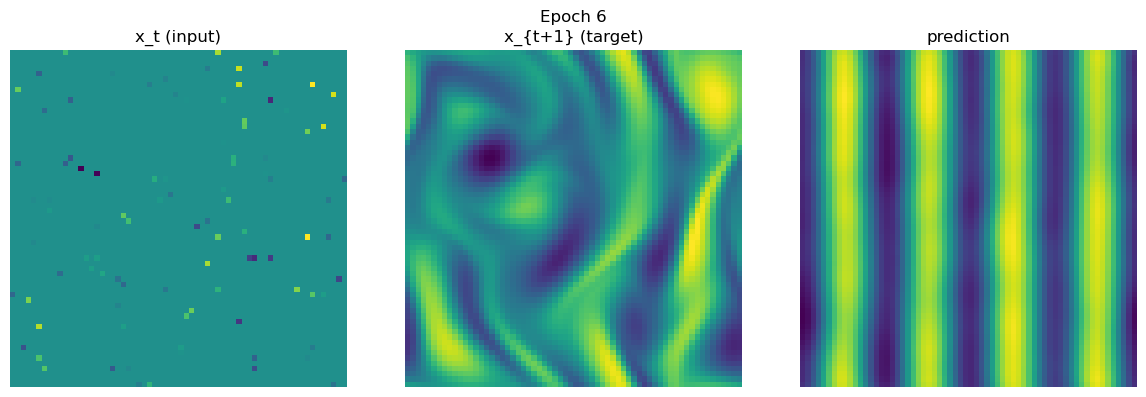

Epoch 7/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 7/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   7/50] train 1.5358 | val 1.1642 | lr 1.90e-04


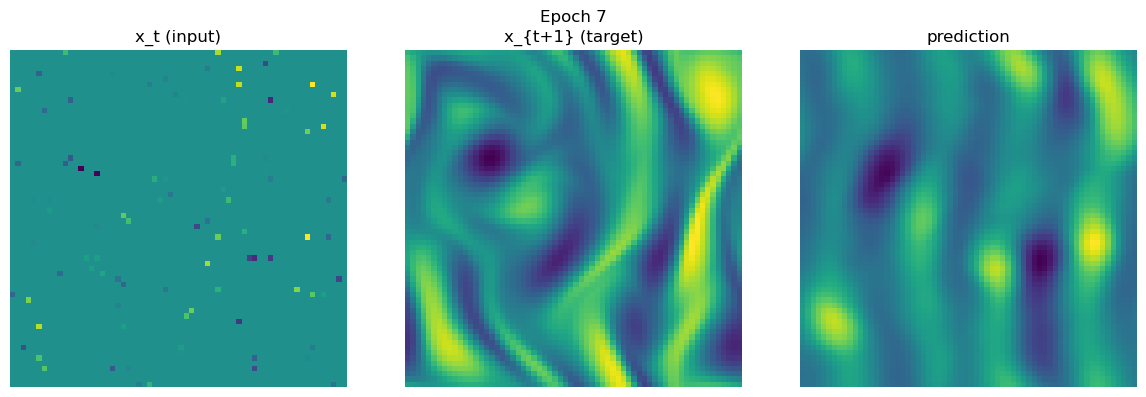

Epoch 8/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 8/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   8/50] train 1.0210 | val 0.9684 | lr 1.88e-04


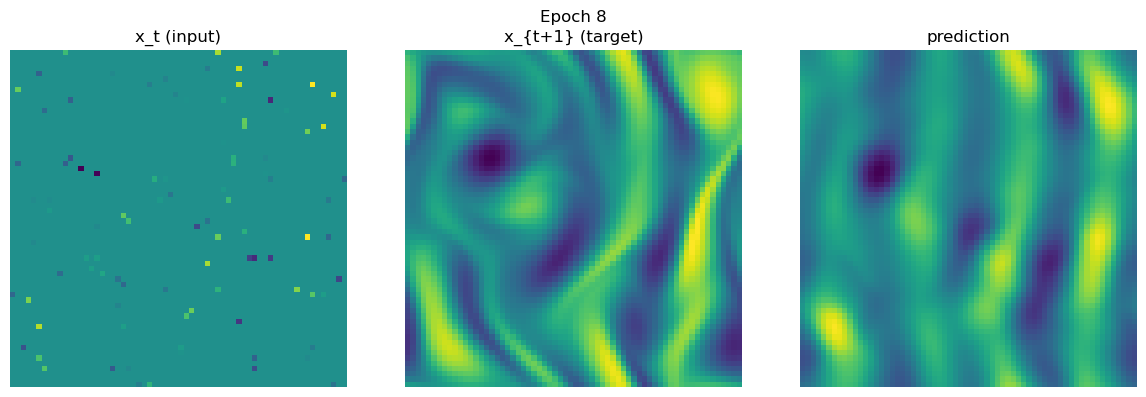

Epoch 9/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 9/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   9/50] train 0.9006 | val 0.9024 | lr 1.84e-04


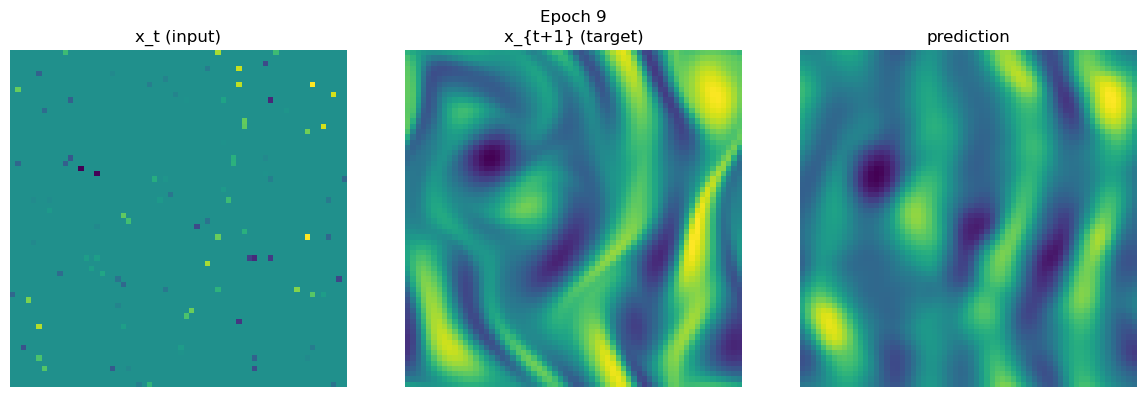

Epoch 10/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 10/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  10/50] train 0.8376 | val 0.8603 | lr 1.81e-04


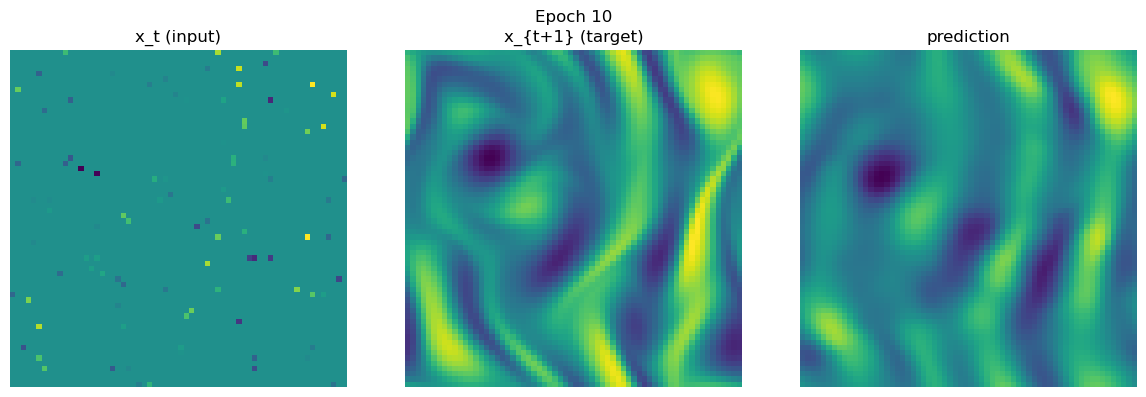

Epoch 11/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 11/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  11/50] train 0.7872 | val 0.8301 | lr 1.77e-04


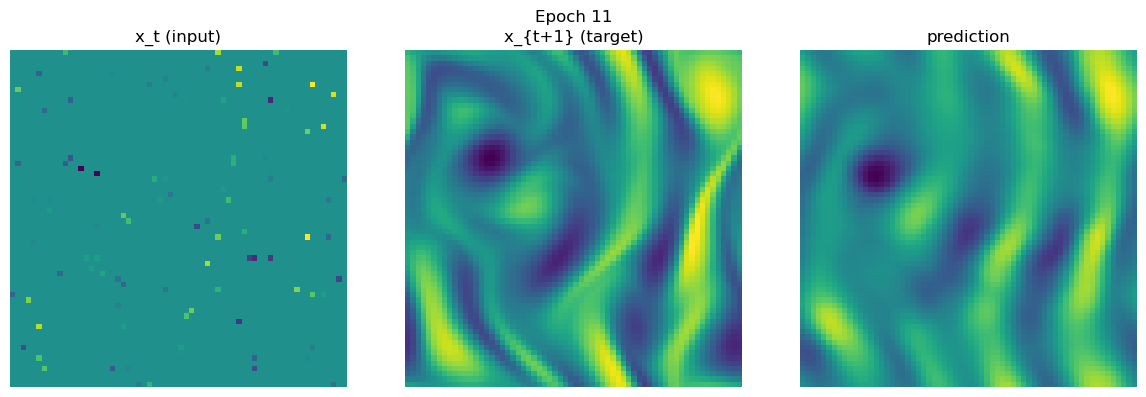

Epoch 12/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 12/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  12/50] train 0.7384 | val 0.8225 | lr 1.73e-04


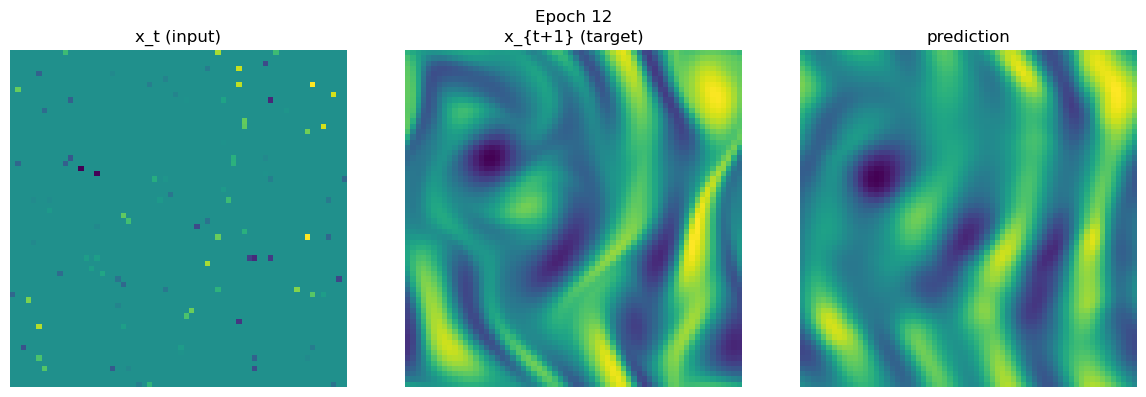

Epoch 13/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 13/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  13/50] train 0.6898 | val 0.8165 | lr 1.68e-04


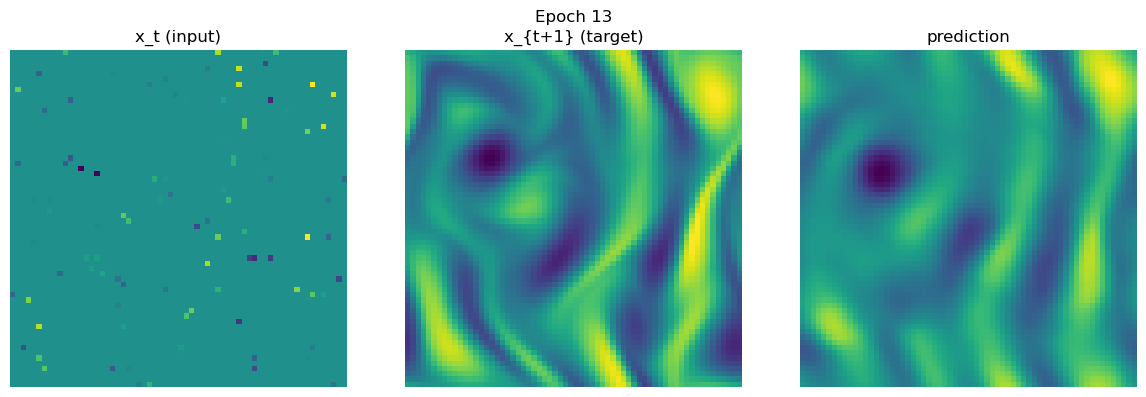

Epoch 14/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 14/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  14/50] train 0.6359 | val 0.8132 | lr 1.64e-04


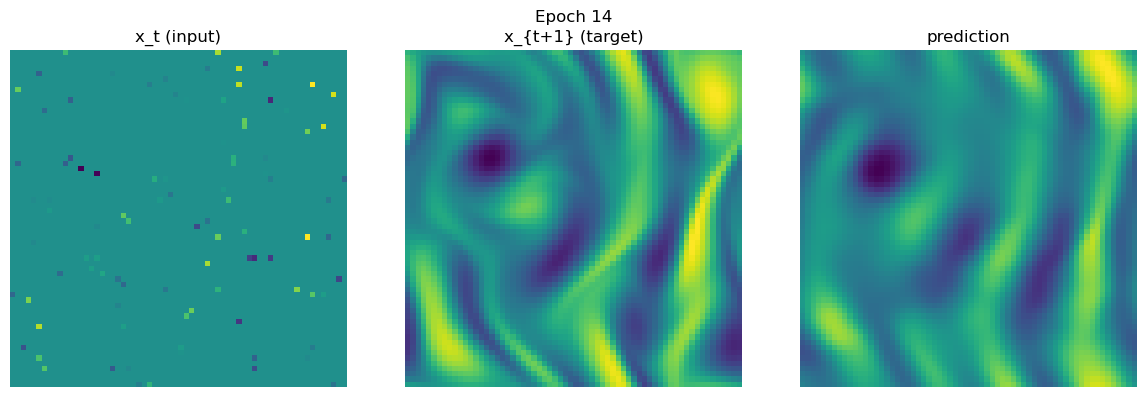

Epoch 15/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 15/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  15/50] train 0.5818 | val 0.8186 | lr 1.59e-04


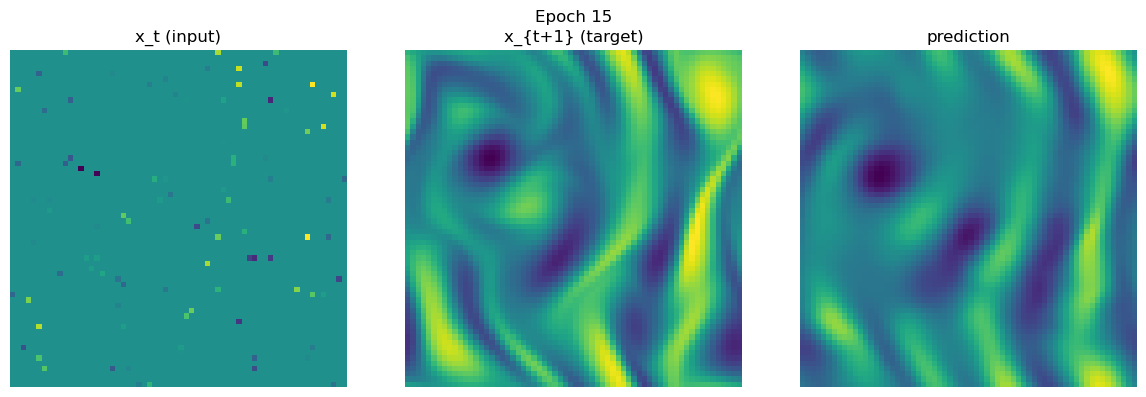

Epoch 16/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 16/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  16/50] train 0.5295 | val 0.8265 | lr 1.54e-04


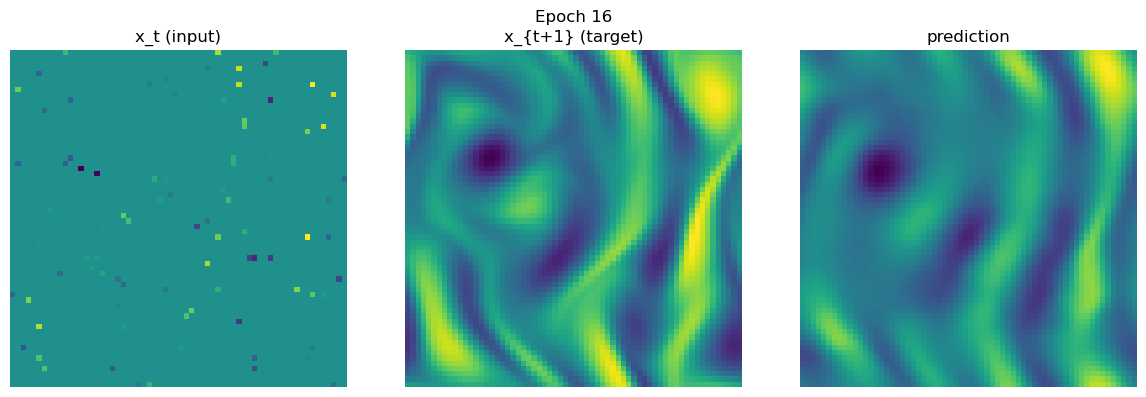

Epoch 17/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 17/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  17/50] train 0.4824 | val 0.8290 | lr 1.48e-04


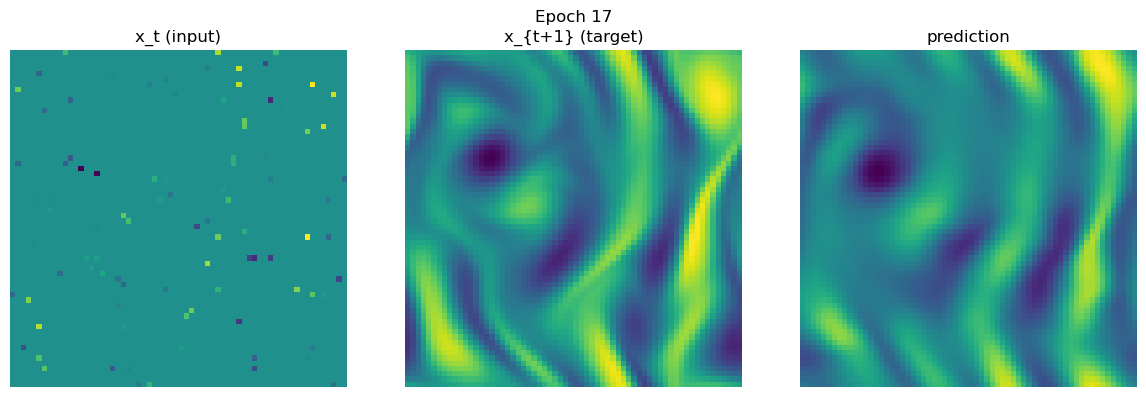

Epoch 18/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from einops import rearrange, repeat
import ssl
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log
from functools import wraps
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
# Fix for torchvision dataset download issue
ssl._create_default_https_context = ssl._create_unverified_context
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ===============================================================
# --- 1. The One True Perceiver IO Model Architecture ---
# ===============================================================
D = 256
# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, query_dim)
        self.latest_attn = None

    def forward(self, x, context = None, mask = None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)
        attn = sim.softmax(dim = -1)
        self.latest_attn = attn.detach()
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)

from math import log

# This helper function creates the sinusoidal embeddings
def get_sinusoidal_embeddings(n, d):
    """
    Generates sinusoidal positional embeddings.
    
    Args:
        n (int): The number of positions (num_latents).
        d (int): The embedding dimension (latent_dim).

    Returns:
        torch.Tensor: A tensor of shape (n, d) with sinusoidal embeddings.
    """
    # Ensure latent_dim is even for sin/cos pairs
    assert d % 2 == 0, "latent_dim must be an even number for sinusoidal embeddings"
    
    position = torch.arange(n, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(log(10000.0) / d))
    
    pe = torch.zeros(n, d)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def add_white_noise(coords, scale=0.01):
    return coords + torch.randn_like(coords) * scale




class CascadedBlock(nn.Module):
    def __init__(self, dim, n_latents, input_dim, cross_heads, cross_dim_head, self_heads, self_dim_head, residual_dim=None):
        super().__init__()
        self.latents = nn.Parameter(get_sinusoidal_embeddings(n_latents, dim), requires_grad=False)
        self.cross_attn = PreNorm(dim, Attention(dim, input_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=input_dim)
        self.self_attn = PreNorm(dim, Attention(dim, heads=self_heads, dim_head=self_dim_head))
        self.residual_proj = nn.Linear(residual_dim, dim) if residual_dim and residual_dim != dim else None
        self.ff = PreNorm(dim, FeedForward(dim))

    def forward(self, x, context, mask=None, residual=None):
        b = context.size(0)
        latents = repeat(self.latents, 'n d -> b n d', b=b)
        latents = self.cross_attn(latents, context=context, mask=mask) + latents
        if residual is not None:
            if self.residual_proj:
                residual = self.residual_proj(residual)
            latents = latents + residual
        latents = self.self_attn(latents) + latents
        latents = self.ff(latents) + latents
        return latents


class CascadedPerceiverIO(nn.Module):
    def __init__(
        self,
        *,
        input_dim,
        queries_dim,
        logits_dim = None,
        latent_dims=(512, 512, 512),
        num_latents=(256, 256, 256),
        cross_heads = 4,
        cross_dim_head = 128,
        self_heads = 8,
        self_dim_head = 128,
        decoder_ff = False,
        
    ):
        super().__init__()
        
        assert len(latent_dims) == len(num_latents), "latent_dims and num_latents must have same length"
        
    
        # self.input_proj = nn.Linear(4, 128)
        self.input_proj = nn.Sequential(
                nn.Linear(4, 128),
                nn.GELU(),
                nn.Linear(128, 128)
            )
        self.projection_matrix = nn.Parameter(torch.randn(4, 128) / np.sqrt(4)).to(DEVICE)
        # proj = torch.randn(4, 128) / np.sqrt(4)
        # self.projection_matrix = nn.Parameter(proj.detach())  # make it a leaf tenso

        # Cascaded encoder blocks
        self.encoder_blocks = nn.ModuleList()
        prev_dim = None
        for dim, n_latents in zip(latent_dims, num_latents):
            block = CascadedBlock(
                dim=dim,
                n_latents=n_latents,
                input_dim=input_dim,
                cross_heads=cross_heads,
                cross_dim_head=cross_dim_head,
                self_heads=self_heads,
                self_dim_head=self_dim_head,
                residual_dim=prev_dim
            )
            self.encoder_blocks.append(block)
            prev_dim = dim

        # Decoder
        final_latent_dim = latent_dims[-1]
        self.decoder_cross_attn = PreNorm(queries_dim, Attention(queries_dim, final_latent_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=final_latent_dim)
        self.decoder_ff = PreNorm(queries_dim, FeedForward(queries_dim)) if decoder_ff else None
        self.to_logits = nn.Linear(queries_dim, logits_dim) if exists(logits_dim) else nn.Identity()
        

        # self.decoder_swin = SwinTransformerLayer(
        #     dim=queries_dim,
        #     depth=2,                  # or 4 if you want deeper decoding
        #     num_heads=4,
        #     window_size=16,           # assuming 64x64 → 4096 tokens → 256 windows of size 16
        #     mlp_ratio=4.0,
        #     drop_path=0.1,
        #     use_checkpoint=False
        # )
        self.self_attn_blocks = nn.Sequential(*[
        nn.Sequential(
            PreNorm(latent_dims[-1], Attention(latent_dims[-1], heads=self_heads, dim_head=self_dim_head)),
            PreNorm(latent_dims[-1], FeedForward(latent_dims[-1]))
        )
        for _ in range(4)  # or 3
    ])

    def forward(self, data, mask=None, queries=None):
        b = data.size(0)
        residual = None

        
        for block in self.encoder_blocks:
            residual = block(x=residual, context=data, mask=mask, residual=residual)

            
            
            
        for sa_block in self.self_attn_blocks:
            residual = sa_block[0](residual) + residual
            residual = sa_block[1](residual) + residual
        
        if  b == 1:  # Optional: only log for one sample
            latent_std = residual.std(dim=1).mean().item()
            print(f"[Latent std]: {latent_std:.4f}")
        
        if queries is None:
            return latents

        if queries.ndim == 2:
            queries = repeat(queries, 'n d -> b n d', b=b)

        x = self.decoder_cross_attn(queries, context=residual)

        # Optional: skip connection to preserve input query encoding
        x = x + queries

        # Local refinement (like SCENT)
        # x = self.decoder_swin(x)

        # Final FF
        if self.decoder_ff:
            x = x + self.decoder_ff(x)

        return self.to_logits(x)


# %% Imports
import os, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange, repeat

# # =========================================================
# # 1) Hyperparams (64x64, 1-channel)
# # =========================================================
# BATCH_SIZE   = 64
# EPOCHS       = 50
# LEARNING_RATE = 2e-4
# DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# H = W = 64          # training resolution matches your data
# CHANNELS = 1        # scalar field

# FOURIER_MAPPING_SIZE = 96
# POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
# INPUT_DIM  = CHANNELS + POS_EMBED_DIM
# QUERIES_DIM = POS_EMBED_DIM
# LOGITS_DIM  = CHANNELS

# # =========================================================
# # 2) Positional encoder (Fourier features)
# # =========================================================
# class GaussianFourierFeatures(nn.Module):
#     def __init__(self, in_features, mapping_size, scale=5.0):
#         super().__init__()
#         self.in_features = in_features
#         self.mapping_size = mapping_size
#         self.register_buffer('B', torch.randn((in_features, mapping_size)) * scale)

#     def forward(self, coords):
#         # coords: [B or N, 2]
#         proj = coords @ self.B   # [..., mapping_size]
#         return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # [..., 2*mapping_size]

# fourier_encoder = GaussianFourierFeatures(
#     in_features=2, mapping_size=FOURIER_MAPPING_SIZE, scale=5.0
# ).to(DEVICE)

# # =========================================================
# # 3) Coordinate grids (64x64 for training; optional 128x128 for eval)
# # =========================================================
# def create_coordinate_grid(h, w, device):
#     yy, xx = torch.meshgrid(
#         torch.linspace(-1.0, 1.0, h, device=device),
#         torch.linspace(-1.0, 1.0, w, device=device),
#         indexing='ij'
#     )
#     grid = torch.stack([yy, xx], dim=-1)    # [H, W, 2]
#     return rearrange(grid, 'h w c -> (h w) c')  # [H*W, 2]

# coords_64 = create_coordinate_grid(H, W, DEVICE)                # [4096, 2]
# coords_128 = create_coordinate_grid(128, 128, DEVICE)           # optional high-res

# # =========================================================
# # 4) Model (assumes CascadedPerceiverIO is available)
# # =========================================================
# # from your_module import CascadedPerceiverIO
# model = CascadedPerceiverIO(
#     input_dim=INPUT_DIM,
#     queries_dim=QUERIES_DIM,
#     logits_dim=LOGITS_DIM,
#     latent_dims=(256, 384, 512),
#     num_latents=(256, 256, 256),
#     decoder_ff=True
# ).to(DEVICE)

# optimizer = AdamW(list(model.parameters()) + list(fourier_encoder.parameters()), lr=LEARNING_RATE)
# loss_fn = nn.MSELoss()

# print(f"Training on {DEVICE}")
# total_params = sum(p.numel() for p in model.parameters()) + sum(p.numel() for p in fourier_encoder.parameters())
# print(f"Total parameters: {total_params/1e6:.2f}M")

# # =========================================================
# # 5) Build index_pairs for next-step prediction and DataLoaders
# #    (uses only up to 1,000 items; loader already does sparsity & normalization)
# # =========================================================
# rng = np.random.default_rng(0)
# MAX_ITEMS = 1000

# num_items_total = len(mem)
# chosen_item_idxs = rng.choice(num_items_total, size=min(MAX_ITEMS, num_items_total), replace=False)
# chosen_item_idxs = np.sort(chosen_item_idxs)

# # assume uniform T across items, e.g., T=50
# T = int(mem[int(chosen_item_idxs[0])].shape[0])
# assert T >= 2, "Need at least 2 frames per item."

# index_pairs = []
# for it in chosen_item_idxs:
#     for t in range(T - 1):
#         index_pairs.append((int(it), int(t)))
# index_pairs = np.asarray(index_pairs, dtype=np.int64)

# print(f"Using {len(chosen_item_idxs)} items; built {len(index_pairs)} (t→t+1) pairs with T={T}.")

# # Dataset from earlier (fixed z-norm + sparsity already inside; keep it as you configured)
# # If you want to keep the same settings as before:
# SPARSITY = 0.2     # keep 20% (loader applies to x_t only); change if desired
# MEAN = 0.0
# STD  = 2.4036

# # If RaggedNextStepDataset is not in scope, re-define it quickly:
# try:
#     RaggedNextStepDataset
# except NameError:
#     class RaggedNextStepDataset(torch.utils.data.Dataset):
#         def __init__(self, memmap, index_pairs, normalize=True, sparsity=1.0, seed=None,
#                      mean=0.0, std=2.4036):
#             self.mem = memmap
#             self.index_pairs = index_pairs
#             self.normalize = normalize
#             self.sparsity = sparsity
#             self.rng = np.random.default_rng(seed)
#             self.mean = mean
#             self.std = std
#         def z_normalize(self, arr):   return (arr - self.mean) / self.std
#         def z_unnormalize(self, arr): return arr * self.std + self.mean
#         def __len__(self): return len(self.index_pairs)
#         def __getitem__(self, i):
#             item_idx, t = self.index_pairs[i]
#             seq = self.mem[item_idx]               # (T, H, W)
#             x  = np.asarray(seq[t],   dtype=np.float32)
#             y  = np.asarray(seq[t+1], dtype=np.float32)
#             if self.normalize:
#                 x = self.z_normalize(x); y = self.z_normalize(y)
#             if self.sparsity < 1.0:
#                 mask = self.rng.random(x.shape) < self.sparsity
#                 x = x * mask.astype(np.float32)
#             x = torch.from_numpy(x[None, ...])   # (1,H,W)
#             y = torch.from_numpy(y[None, ...])
#             return x, y

# full_ds = RaggedNextStepDataset(mem, index_pairs, normalize=True,
#                                 sparsity=SPARSITY, seed=42, mean=MEAN, std=STD)

# # Split
# val_frac = 0.10
# val_len = int(len(full_ds) * val_frac)
# train_len = len(full_ds) - val_len
# train_ds, val_ds = random_split(full_ds, [train_len, val_len],
#                                 generator=torch.Generator().manual_seed(0))

# # Loaders
# NUM_WORKERS = 2   # set to 0 if workers misbehave on shared FS
# PIN_MEMORY  = (DEVICE == "cuda")

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
#                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
#                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

# # Scheduler after loaders exist (needs steps per epoch)
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))

# # =========================================================
# # 6) Helper: prepare model inputs (concat pixels + pos enc)
# # =========================================================
# def prepare_model_input(images, coords, fourier_encoder_fn):
#     """
#     images: [B, 1, H, W]
#     coords: [N=H*W, 2]
#     returns:
#       input_with_pos: [B, N, 1 + Dpos]
#       target_pixels : [B, N, 1] (if you pass y through this helper)
#       pos_embeddings: [B, N, Dpos]
#     """
#     b, c, h, w = images.shape
#     assert c == 1 and h == H and w == W, f"expected [B,1,{H},{W}], got {images.shape}"
#     pixels = rearrange(images, 'b c h w -> b (h w) c')  # [B, N, 1]
#     batch_coords = repeat(coords, 'n d -> b n d', b=b)  # [B, N, 2]
#     pos_embeddings = fourier_encoder_fn(batch_coords)   # [B, N, Dpos]
#     input_with_pos = torch.cat((pixels, pos_embeddings), dim=-1)  # [B, N, 1+Dpos]
#     return input_with_pos, pixels, pos_embeddings

# # =========================================================
# # 7) Train / Validate
# # =========================================================
# def show_example(xb, yb, pred_pixels, title=""):
#     """Quick viz for a single sample."""
#     with torch.no_grad():
#         x_img = xb[0, 0].detach().cpu().numpy()
#         y_img = yb[0, 0].detach().cpu().numpy()
#         p_img = rearrange(pred_pixels[0], '(h w) c -> c h w', h=H, w=W)[0].detach().cpu().numpy()

#         fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#         axs[0].imshow(x_img); axs[0].set_title("x_t (input)"); axs[0].axis('off')
#         axs[1].imshow(y_img); axs[1].set_title("x_{t+1} (target)"); axs[1].axis('off')
#         axs[2].imshow(p_img); axs[2].set_title("prediction"); axs[2].axis('off')
#         fig.suptitle(title)
#         plt.tight_layout(); plt.show()

# for epoch in range(EPOCHS):
#     # ---------- Train ----------
#     model.train(); fourier_encoder.train()
#     total_train_loss = 0.0

#     for xb, yb in train_loader:
#         xb = xb.to(DEVICE, non_blocking=True)  # [B,1,64,64] (sparse + normalized)
#         yb = yb.to(DEVICE, non_blocking=True)  # [B,1,64,64] (normalized)

#         # Prepare inputs
#         input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder)      # [B,N,1+Dpos]
#         target_pixels = rearrange(yb, 'b c h w -> b (h w) c')                        # [B,N,1]
#         queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))  # [B,N,Dpos]

#         # Forward
#         optimizer.zero_grad(set_to_none=True)
#         pred_pixels = model(input_data, queries=queries)  # [B,N,1]
#         loss = loss_fn(pred_pixels, target_pixels)

#         # Backprop
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         total_train_loss += loss.item()

#     avg_train_loss = total_train_loss / len(train_loader)

#     # ---------- Validate ----------
#     model.eval(); fourier_encoder.eval()
#     total_val_loss = 0.0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             xb = xb.to(DEVICE, non_blocking=True)
#             yb = yb.to(DEVICE, non_blocking=True)
#             input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder)
#             target_pixels = rearrange(yb, 'b c h w -> b (h w) c')
#             queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))
#             pred_pixels = model(input_data, queries=queries)
#             total_val_loss += loss_fn(pred_pixels, target_pixels).item()

#     avg_val_loss = total_val_loss / len(val_loader)
#     print(f"[Epoch {epoch+1:3d}/{EPOCHS}] train {avg_train_loss:.4f} | val {avg_val_loss:.4f} | lr {scheduler.get_last_lr()[0]:.6e}")

#     # ---------- Quick visualization ----------
#     with torch.no_grad():
#         xb_vis, yb_vis = next(iter(val_loader))
#         xb_vis = xb_vis.to(DEVICE)[:8]
#         yb_vis = yb_vis.to(DEVICE)[:8]
#         input_data, _, _ = prepare_model_input(xb_vis, coords_64, fourier_encoder)
#         queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb_vis.size(0))
#         pred_pixels = model(input_data, queries=queries)     # [B,N,1]
#         show_example(xb_vis, yb_vis, pred_pixels, title=f"Epoch {epoch+1}")

# print("--- Training finished. ---")



# %% ------------- 64x64 next-step training with tqdm progress -------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from tqdm.auto import tqdm

# ----------------- Hyperparams -----------------
BATCH_SIZE    = 64
EPOCHS        = 50
LEARNING_RATE = 2e-4
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

H = W = 64            # your data resolution
CHANNELS = 1          # scalar field (single channel)

FOURIER_MAPPING_SIZE = 96
POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
INPUT_DIM   = CHANNELS + POS_EMBED_DIM
QUERIES_DIM = POS_EMBED_DIM
LOGITS_DIM  = CHANNELS

MAX_ITEMS = 1000      # use up to 1000 items
VAL_FRAC  = 0.10
NUM_WORKERS = 2       # set to 0 if shared FS workers cause issues
PIN_MEMORY  = (DEVICE == "cuda")

# ----------------- Fourier PE -----------------
class GaussianFourierFeatures(nn.Module):
    def __init__(self, in_features, mapping_size, scale=5.0):
        super().__init__()
        self.register_buffer('B', torch.randn((in_features, mapping_size)) * scale)

    def forward(self, coords):
        proj = coords @ self.B                    # [..., M]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # [..., 2M]

fourier_encoder = GaussianFourierFeatures(2, FOURIER_MAPPING_SIZE, scale=5.0).to(DEVICE)

# ----------------- Coords -----------------
def create_coordinate_grid(h, w, device):
    yy, xx = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, device=device),
        torch.linspace(-1.0, 1.0, w, device=device),
        indexing='ij'
    )
    grid = torch.stack([yy, xx], dim=-1)     # [H, W, 2]
    return rearrange(grid, 'h w c -> (h w) c')  # [H*W, 2]

coords_64  = create_coordinate_grid(H, W, DEVICE)                # [4096, 2]
coords_128 = create_coordinate_grid(128, 128, DEVICE)            # optional high-res

# Optional small speedup: precompute pos encodings (B is a buffer -> fixed)
# PRECOMPUTE_POS = True
# pos_64_const = fourier_encoder(coords_64) if PRECOMPUTE_POS else None

# ----------------- Model -----------------
# Assumes CascadedPerceiverIO is already imported/available
model = CascadedPerceiverIO(
    input_dim=INPUT_DIM,
    queries_dim=QUERIES_DIM,
    logits_dim=LOGITS_DIM,
    latent_dims=(256, 384, 512),
    num_latents=(256, 256, 256),
    decoder_ff=True
).to(DEVICE)

optimizer = AdamW(list(model.parameters()) + list(fourier_encoder.parameters()), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print(f"Training on {DEVICE}")
total_params = sum(p.numel() for p in model.parameters()) + sum(p.numel() for p in fourier_encoder.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")

# ----------------- Build (item, t) pairs -----------------
rng = np.random.default_rng(0)
num_items_total = len(mem)
chosen_item_idxs = rng.choice(num_items_total, size=min(MAX_ITEMS, num_items_total), replace=False)
chosen_item_idxs = np.sort(chosen_item_idxs)

T = int(mem[int(chosen_item_idxs[0])].shape[0])  # e.g., 50
assert T >= 2, "Need at least 2 frames per item."
index_pairs = [(int(it), int(t)) for it in chosen_item_idxs for t in range(T - 1)]
index_pairs = np.asarray(index_pairs, dtype=np.int64)

print(f"Using {len(chosen_item_idxs)} items; built {len(index_pairs)} (t→t+1) pairs with T={T}.")

# ----------------- Dataset & Loaders -----------------
# Uses your RaggedNextStepDataset already defined in your notebook.
# Example: RaggedNextStepDataset(mem, index_pairs, normalize=True, sparsity=0.2, seed=42, mean=0.0, std=2.4036)
full_ds = RaggedNextStepDataset(mem, index_pairs, normalize=True, sparsity=0.025, seed=42, mean=0.0, std=2.4036)  # keep your own ctor args if you want (normalize/sparsity/mean/std)

val_len = int(len(full_ds) * VAL_FRAC)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))

# ----------------- Helpers -----------------
def prepare_model_input(images, coords, fourier_encoder_fn, pos_embeddings_const=None):
    """
    images: [B,1,H,W]
    returns input_with_pos:[B,N,1+Dpos], target_pixels:[B,N,1], pos_embeddings:[B,N,Dpos]
    """
    b, c, h, w = images.shape
    assert c == 1 and h == H and w == W, f"expected [B,1,{H},{W}], got {images.shape}"
    pixels = rearrange(images, 'b c h w -> b (h w) c')  # [B, N, 1]

    if pos_embeddings_const is None:
        batch_coords = repeat(coords, 'n d -> b n d', b=b)
        pos_embeddings = fourier_encoder_fn(batch_coords)        # [B,N,Dpos]
    else:
        pos_embeddings = repeat(pos_embeddings_const, 'n d -> b n d', b=b)

    input_with_pos = torch.cat((pixels, pos_embeddings), dim=-1)  # [B,N,1+Dpos]
    return input_with_pos, pixels, pos_embeddings

def show_example(xb, yb, pred_pixels, title=""):
    with torch.no_grad():
        x_img = xb[0, 0].detach().cpu().numpy()
        y_img = yb[0, 0].detach().cpu().numpy()
        p_img = rearrange(pred_pixels[0], '(h w) c -> c h w', h=H, w=W)[0].detach().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_img); axs[0].set_title("x_t (input)"); axs[0].axis('off')
        axs[1].imshow(y_img); axs[1].set_title("x_{t+1} (target)"); axs[1].axis('off')
        axs[2].imshow(p_img); axs[2].set_title("prediction"); axs[2].axis('off')
        fig.suptitle(title); plt.tight_layout(); plt.show()

# ----------------- Train / Validate with tqdm -----------------
for epoch in range(EPOCHS):
    # ----- Train -----
    model.train(); fourier_encoder.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)
    for xb, yb in pbar:
        xb = xb.to(DEVICE, non_blocking=True)  # [B,1,64,64]
        yb = yb.to(DEVICE, non_blocking=True)  # [B,1,64,64]

        input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
        # queries are just positional encodings
        if PRECOMPUTE_POS:
            queries = repeat(pos_64_const, 'n d -> b n d', b=xb.size(0))
        else:
            queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))

        target_pixels = rearrange(yb, 'b c h w -> b (h w) c')

        optimizer.zero_grad(set_to_none=True)
        pred_pixels = model(input_data, queries=queries)
        loss = loss_fn(pred_pixels, target_pixels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_train += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

    avg_train = running_train / len(train_loader)

    # ----- Validate -----
    model.eval(); fourier_encoder.eval()
    running_val = 0.0
    with torch.no_grad():
        pbar_v = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]  ", leave=False)
        for xb, yb in pbar_v:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
            if PRECOMPUTE_POS:
                queries = repeat(pos_64_const, 'n d -> b n d', b=xb.size(0))
            else:
                queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))

            target_pixels = rearrange(yb, 'b c h w -> b (h w) c')
            pred_pixels = model(input_data, queries=queries)
            running_val += loss_fn(pred_pixels, target_pixels).item()

    avg_val = running_val / len(val_loader)
    print(f"[Epoch {epoch+1:3d}/{EPOCHS}] train {avg_train:.4f} | val {avg_val:.4f} | lr {scheduler.get_last_lr()[0]:.2e}")

    # Quick visualization each epoch
    with torch.no_grad():
        xb_vis, yb_vis = next(iter(val_loader))
        xb_vis = xb_vis.to(DEVICE)[:8]
        yb_vis = yb_vis.to(DEVICE)[:8]
        input_data, _, _ = prepare_model_input(xb_vis, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
        if PRECOMPUTE_POS:
            queries = repeat(pos_64_const, 'n d -> b n d', b=xb_vis.size(0))
        else:
            queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb_vis.size(0))
        pred_pixels = model(input_data, queries=queries)
        show_example(xb_vis, yb_vis, pred_pixels, title=f"Epoch {epoch+1}")

print("--- Training finished. ---")



In [42]:
torch.save(model.state_dict(), "NS_2.5percent.pth")
torch.save(fourier_encoder.state_dict(), "fourierNS_2.5percent.pth")

Training on cuda
Total parameters: 34.99M
Using 1000 items; built 49000 (t→t+1) pairs with T=50.


Epoch 1/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   1/50] train 1.8645 | val 1.8415 | lr 2.00e-04


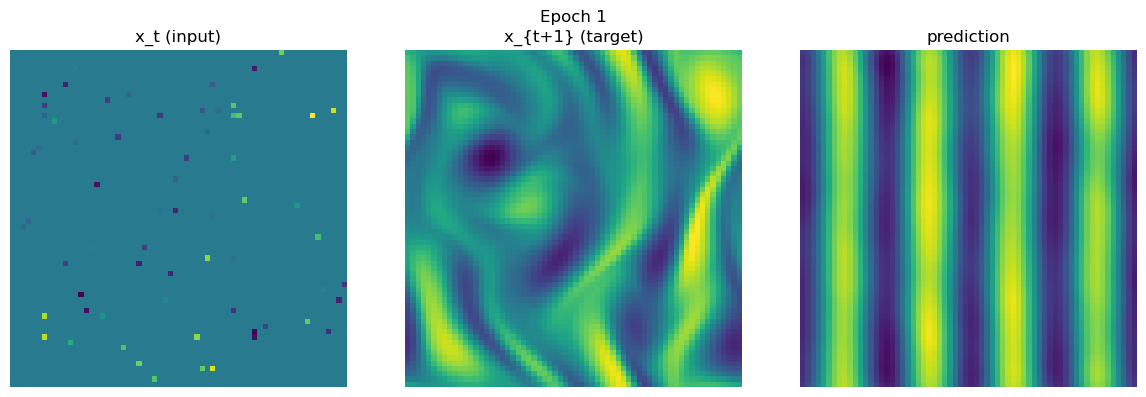

Epoch 2/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   2/50] train 1.8425 | val 1.8404 | lr 1.99e-04


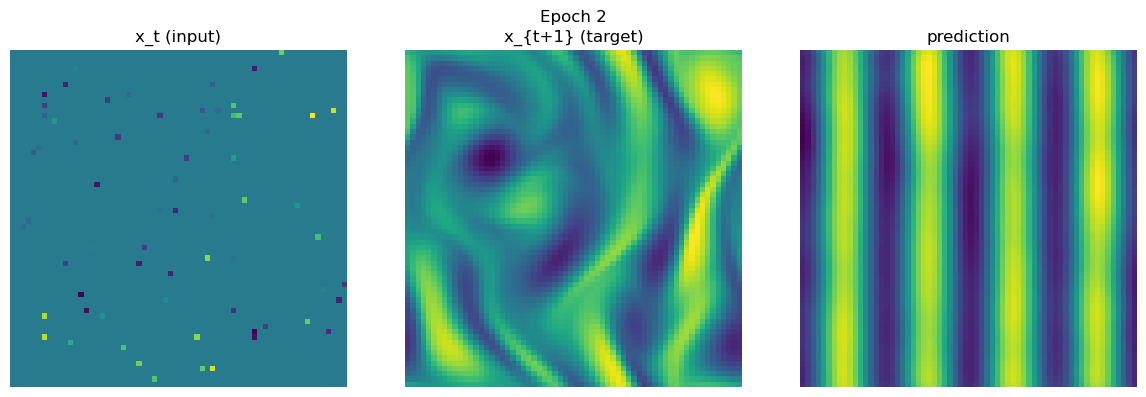

Epoch 3/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   3/50] train 1.8416 | val 1.8402 | lr 1.98e-04


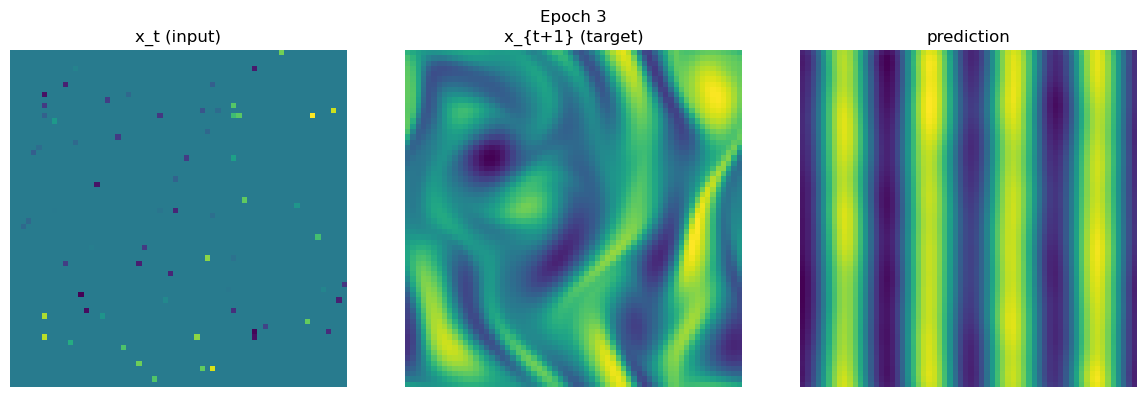

Epoch 4/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   4/50] train 1.8417 | val 1.8402 | lr 1.97e-04


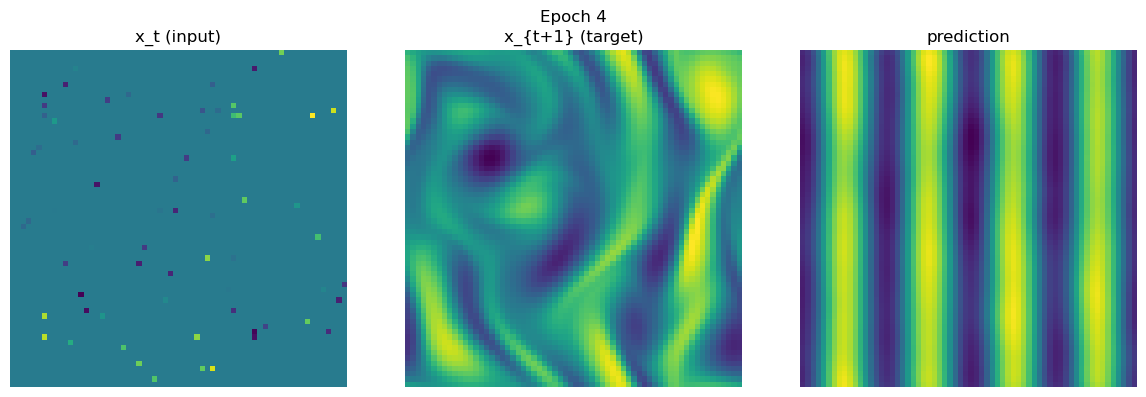

Epoch 5/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   5/50] train 1.8411 | val 1.8403 | lr 1.95e-04


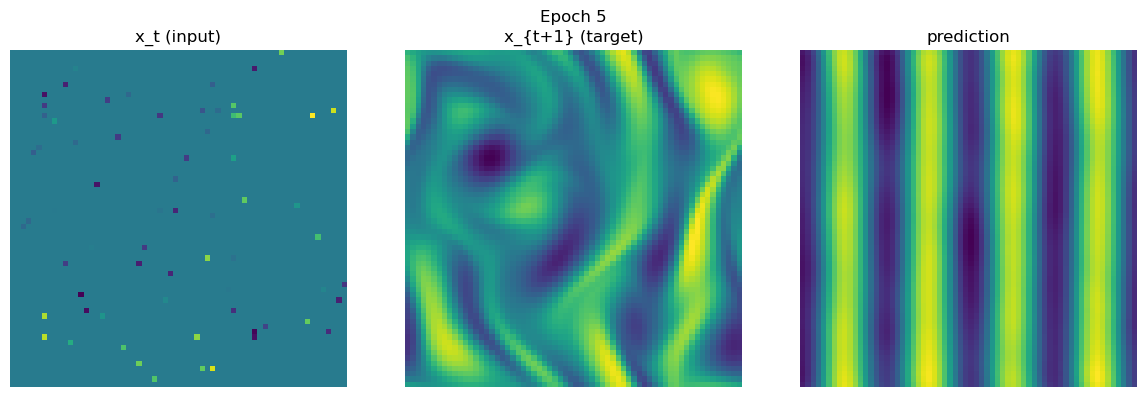

Epoch 6/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   6/50] train 1.8399 | val 1.8083 | lr 1.93e-04


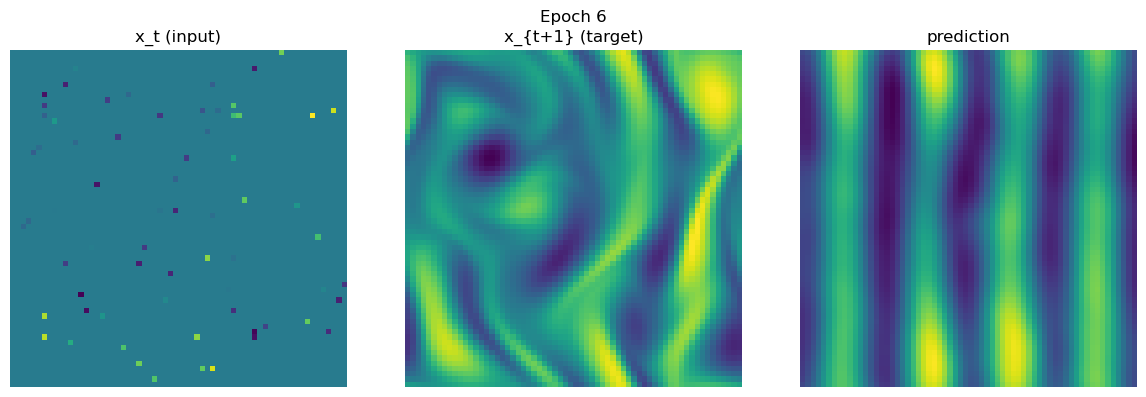

Epoch 7/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 7/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec013172a60>
Traceback (most recent call last):
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec013172a60>
Traceback (most recent call last):
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-p

[Epoch   7/50] train 1.4356 | val 1.1655 | lr 1.90e-04


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec013172a60>
Traceback (most recent call last):
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ec013172a60>
Traceback (most recent call last):
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/idies/miniconda3/envs/py39/lib/python3.9/site-p

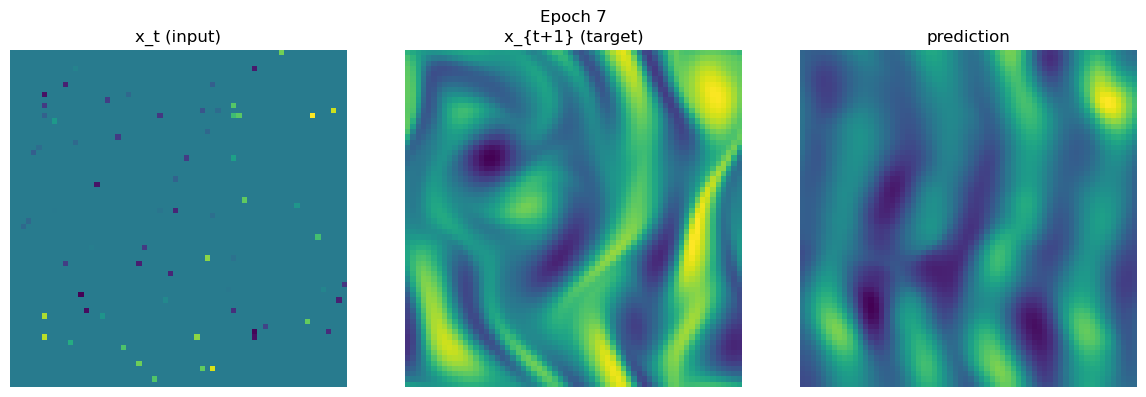

Epoch 8/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 8/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   8/50] train 1.0750 | val 1.0369 | lr 1.88e-04


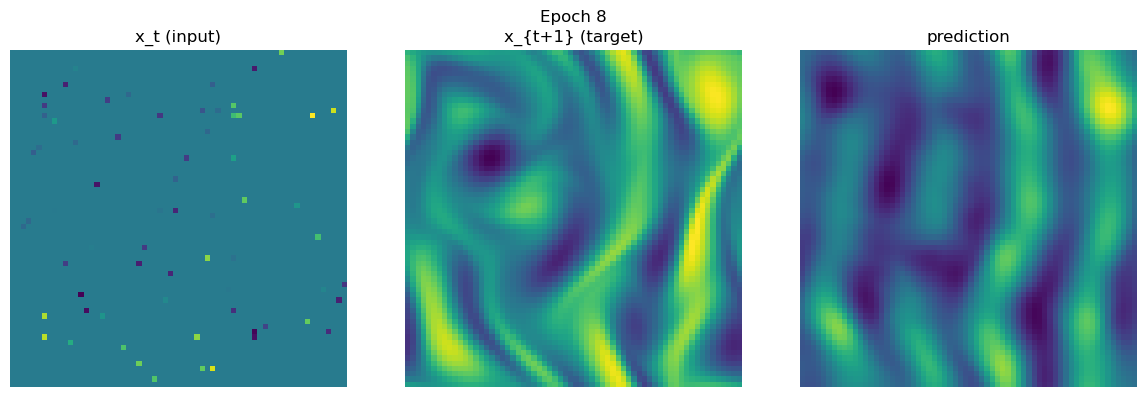

Epoch 9/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 9/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch   9/50] train 0.9950 | val 0.9738 | lr 1.84e-04


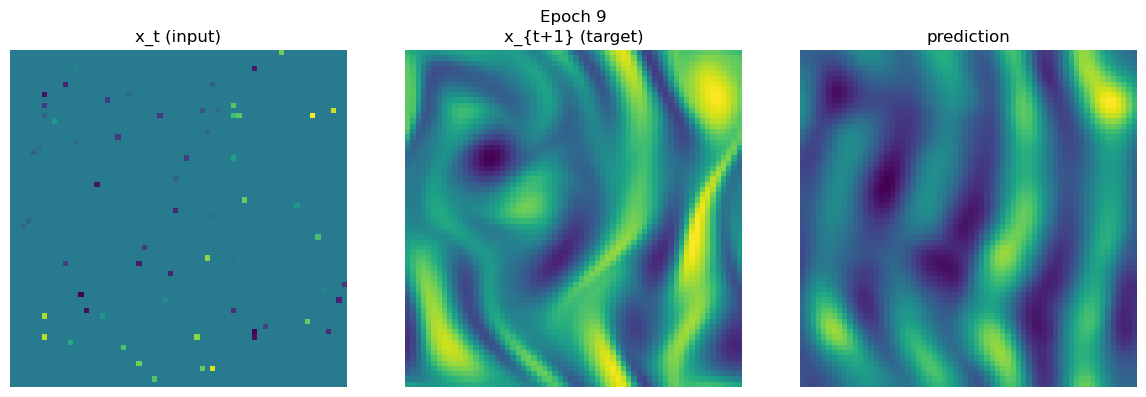

Epoch 10/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 10/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  10/50] train 0.9495 | val 0.9568 | lr 1.81e-04


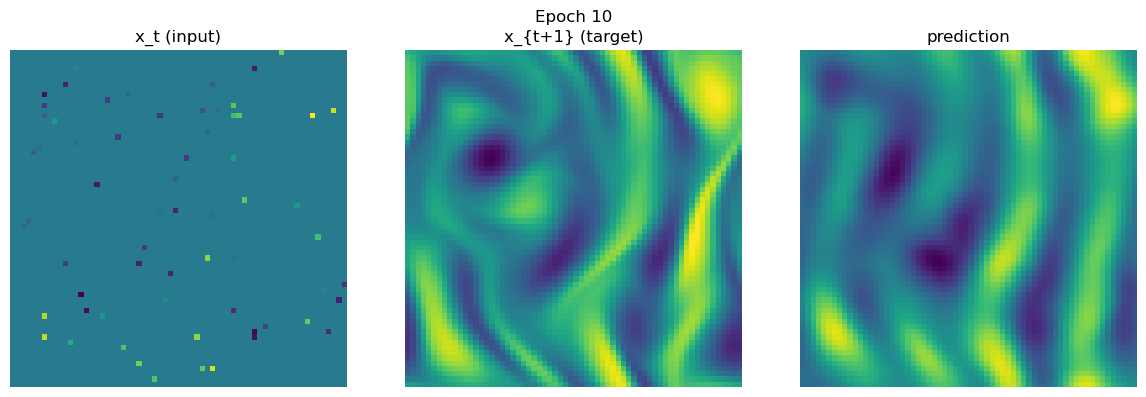

Epoch 11/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 11/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  11/50] train 0.9180 | val 0.9080 | lr 1.77e-04


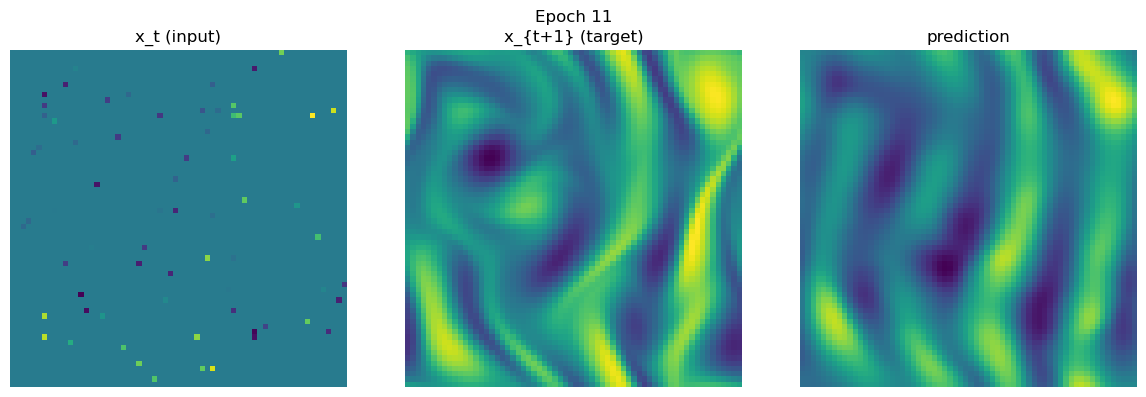

Epoch 12/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 12/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  12/50] train 0.8918 | val 0.8890 | lr 1.73e-04


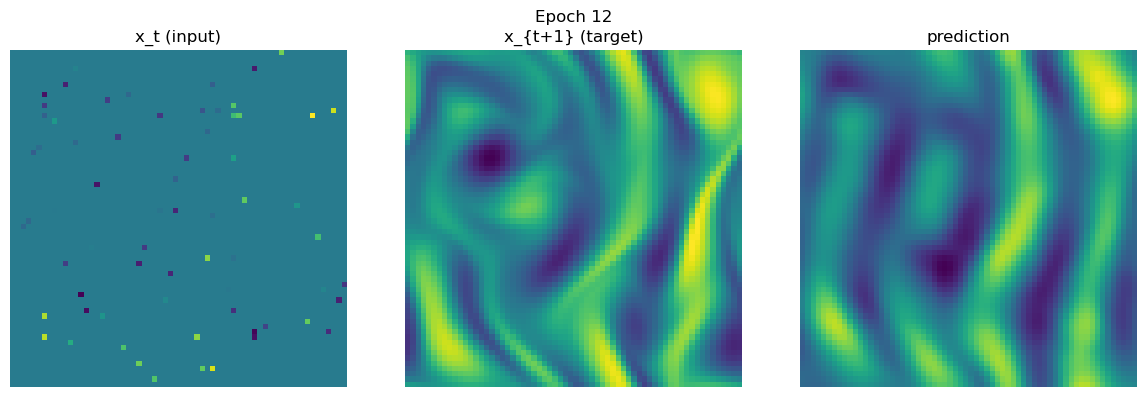

Epoch 13/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 13/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  13/50] train 0.8714 | val 0.8734 | lr 1.68e-04


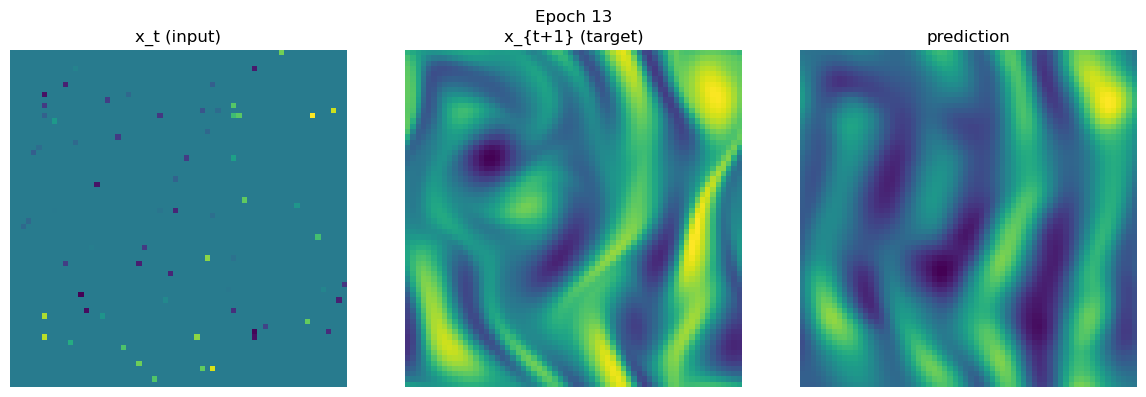

Epoch 14/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 14/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  14/50] train 0.8551 | val 0.8525 | lr 1.64e-04


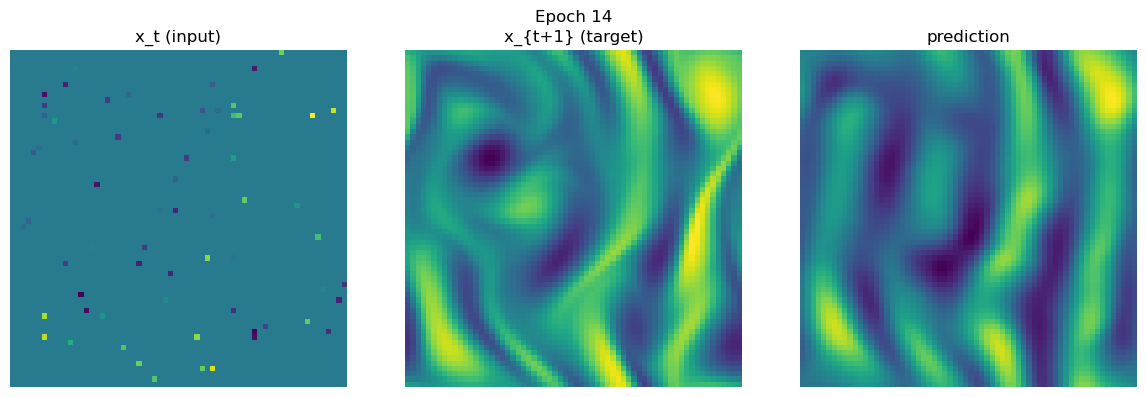

Epoch 15/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 15/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  15/50] train 0.8379 | val 0.8417 | lr 1.59e-04


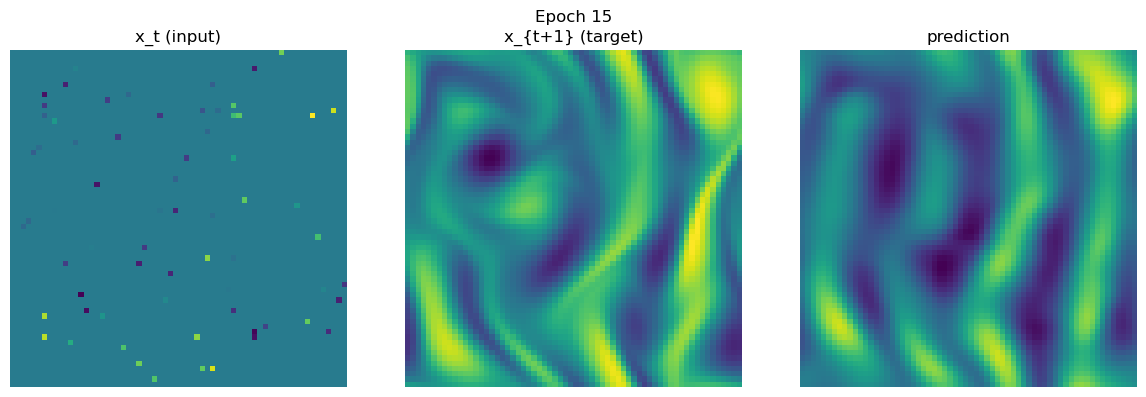

Epoch 16/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 16/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  16/50] train 0.8260 | val 0.8248 | lr 1.54e-04


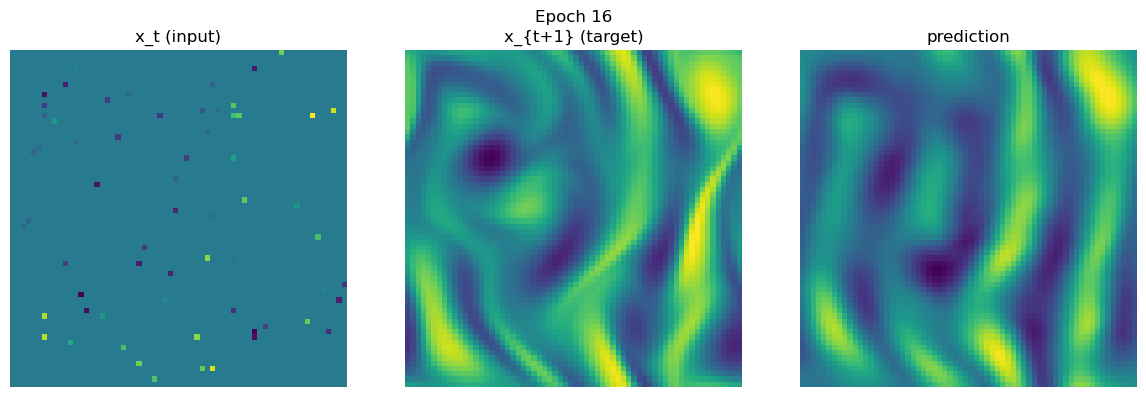

Epoch 17/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 17/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  17/50] train 0.8155 | val 0.8211 | lr 1.48e-04


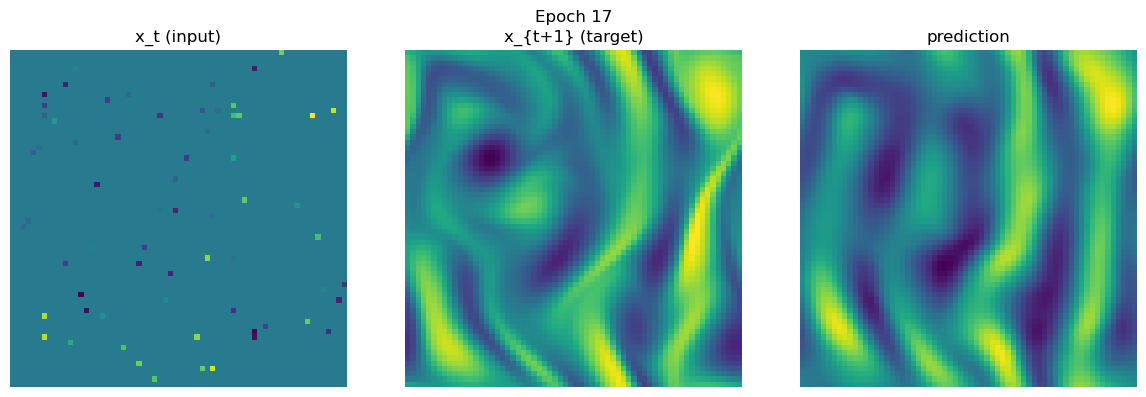

Epoch 18/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 18/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  18/50] train 0.8038 | val 0.8028 | lr 1.43e-04


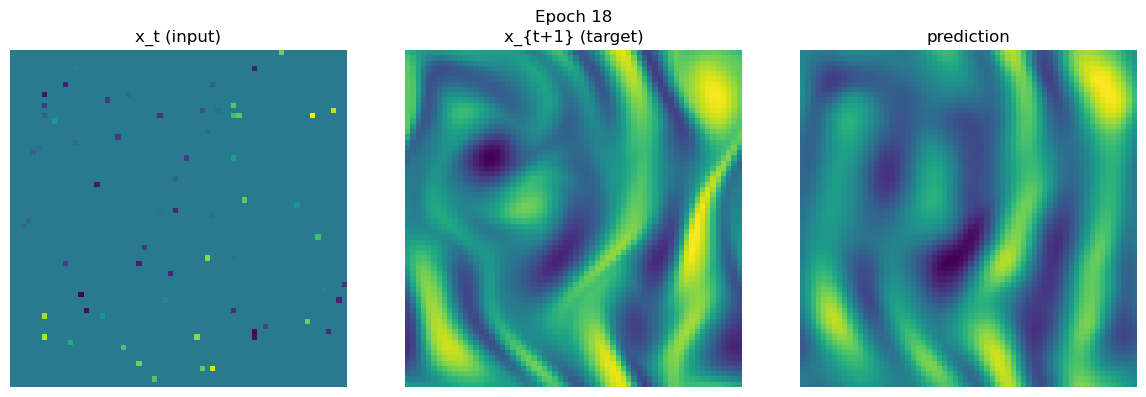

Epoch 19/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 19/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  19/50] train 0.7921 | val 0.7944 | lr 1.37e-04


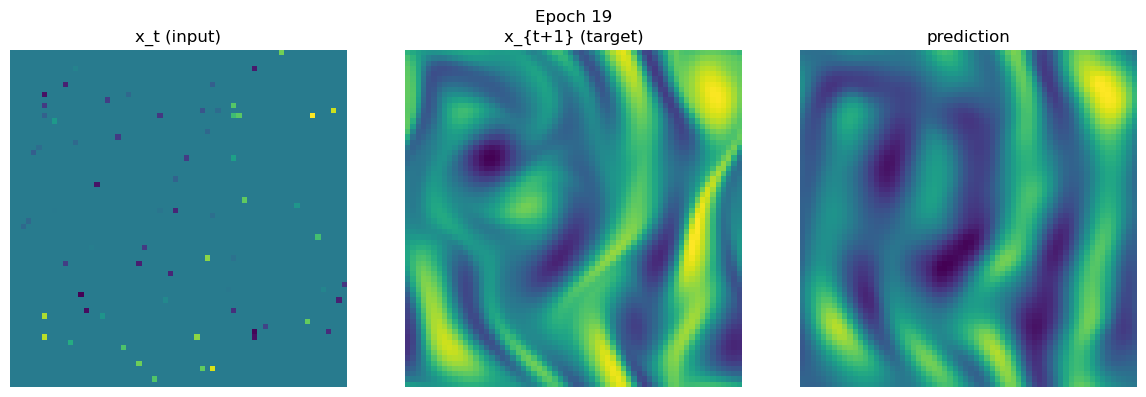

Epoch 20/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 20/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  20/50] train 0.7821 | val 0.7820 | lr 1.31e-04


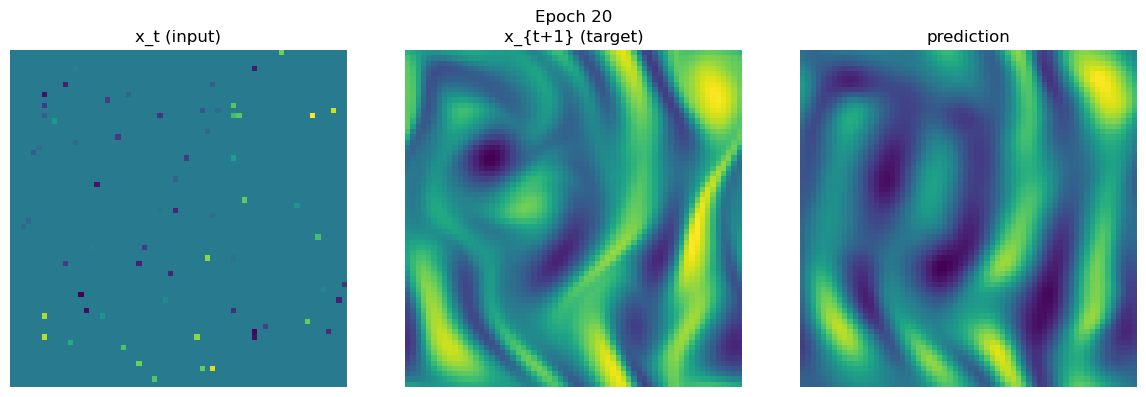

Epoch 21/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 21/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  21/50] train 0.7741 | val 0.7773 | lr 1.25e-04


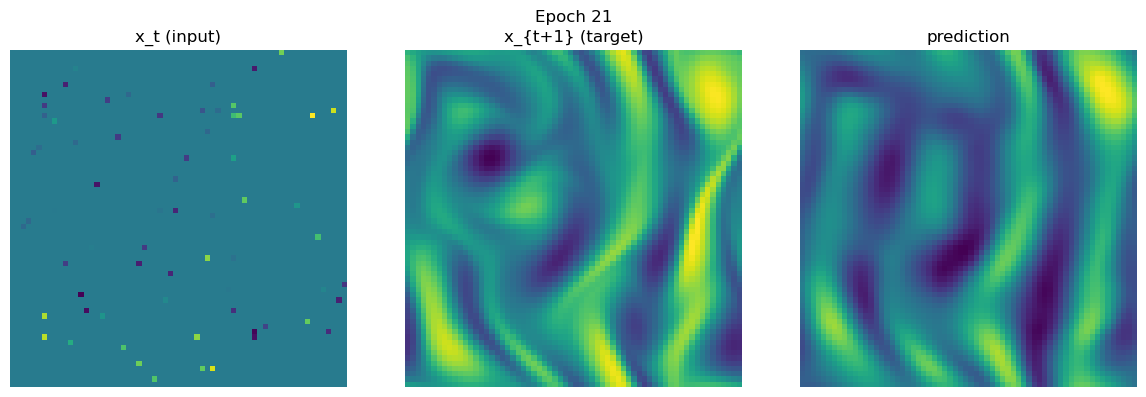

Epoch 22/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 22/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  22/50] train 0.7651 | val 0.7692 | lr 1.19e-04


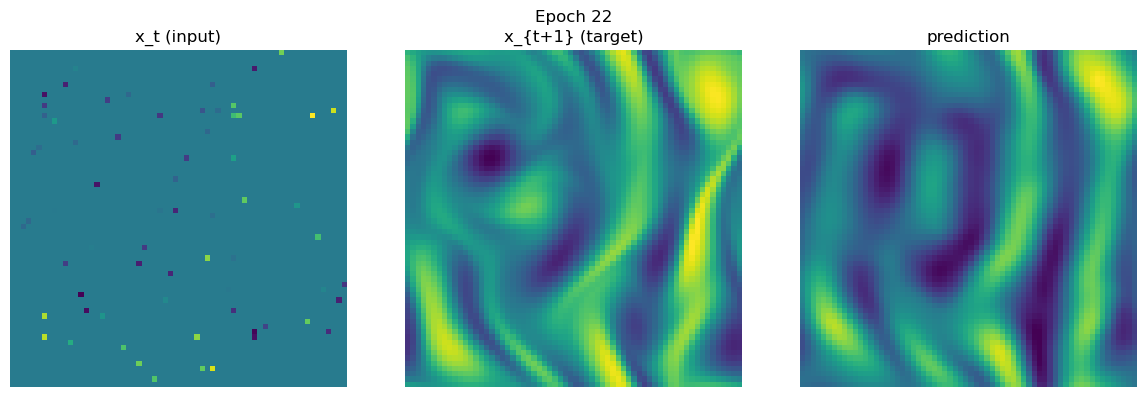

Epoch 23/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 23/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  23/50] train 0.7554 | val 0.7598 | lr 1.13e-04


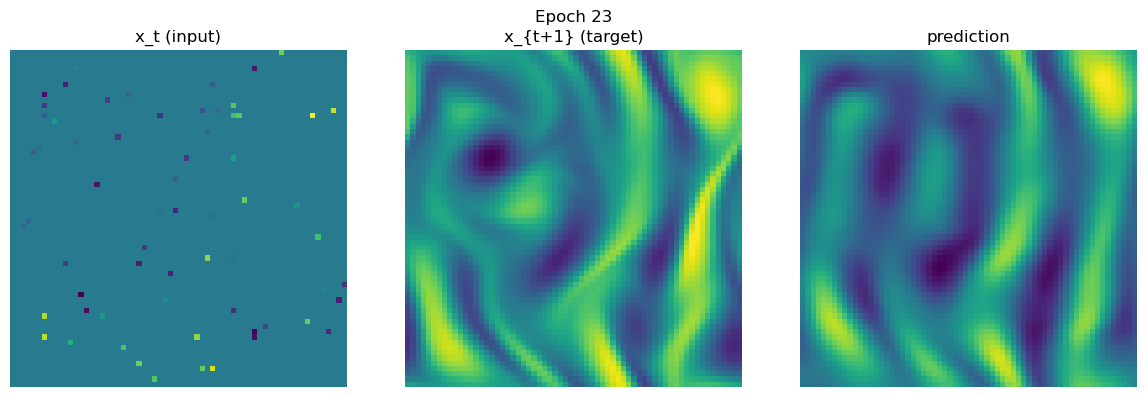

Epoch 24/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 24/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  24/50] train 0.7482 | val 0.7524 | lr 1.06e-04


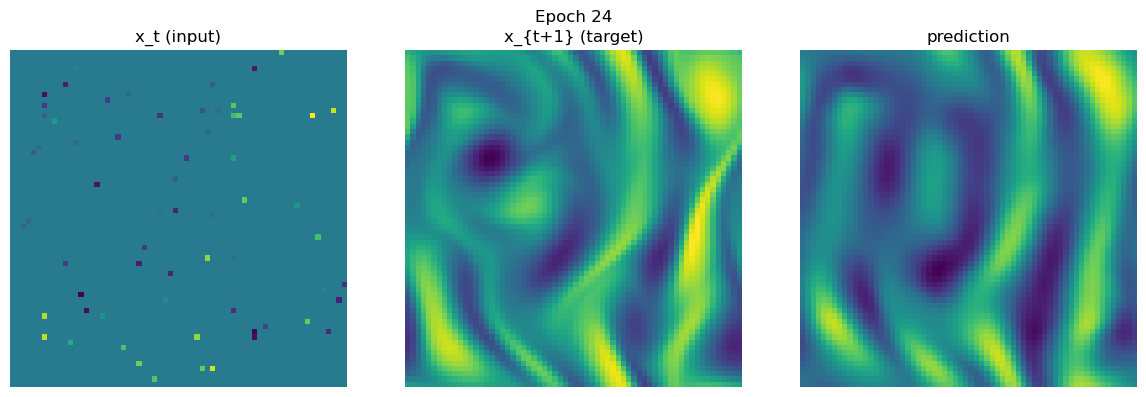

Epoch 25/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 25/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  25/50] train 0.7401 | val 0.7445 | lr 1.00e-04


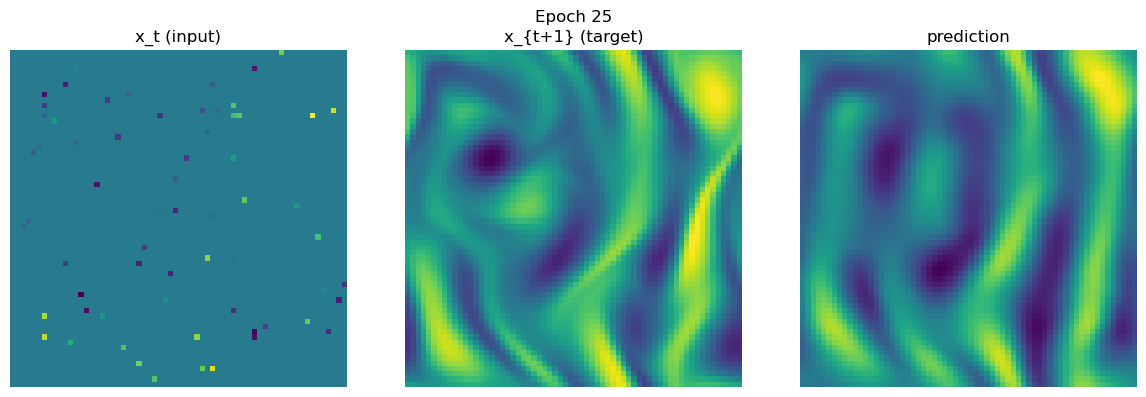

Epoch 26/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 26/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  26/50] train 0.7337 | val 0.7390 | lr 9.37e-05


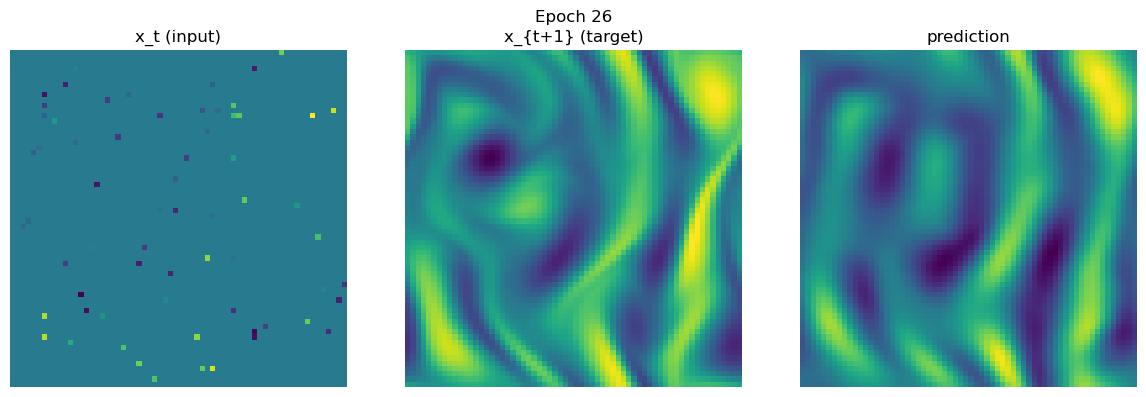

Epoch 27/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 27/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  27/50] train 0.7254 | val 0.7311 | lr 8.75e-05


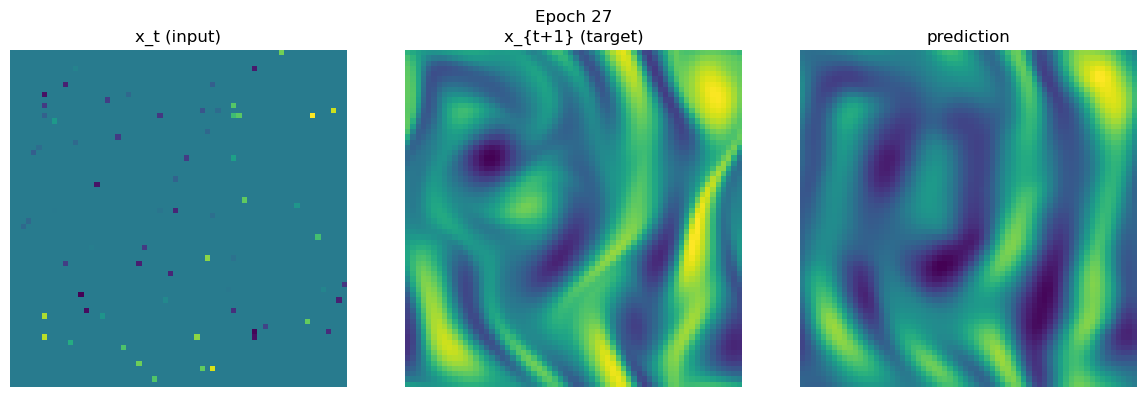

Epoch 28/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 28/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  28/50] train 0.7196 | val 0.7243 | lr 8.13e-05


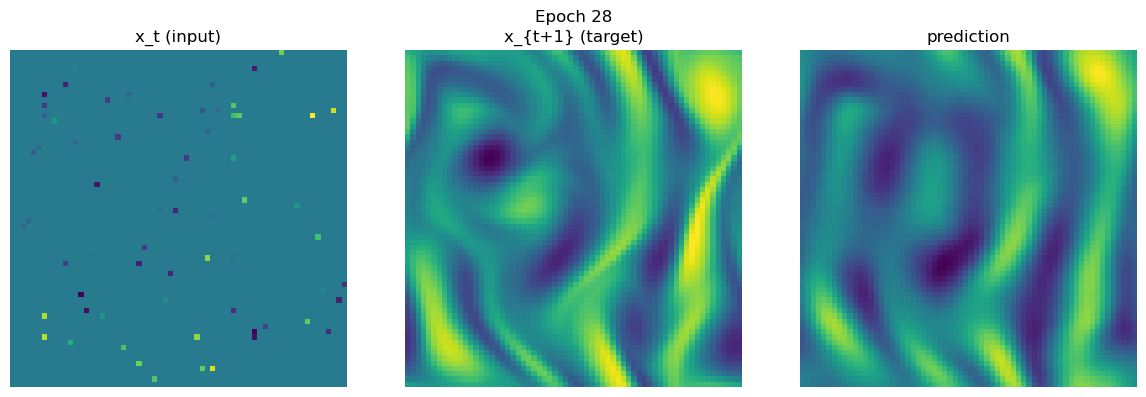

Epoch 29/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 29/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  29/50] train 0.7133 | val 0.7200 | lr 7.51e-05


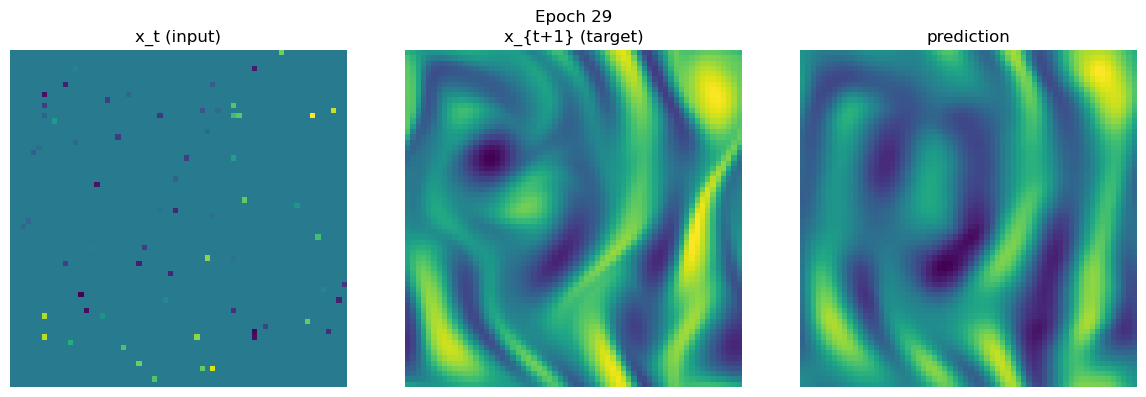

Epoch 30/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 30/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  30/50] train 0.7078 | val 0.7138 | lr 6.91e-05


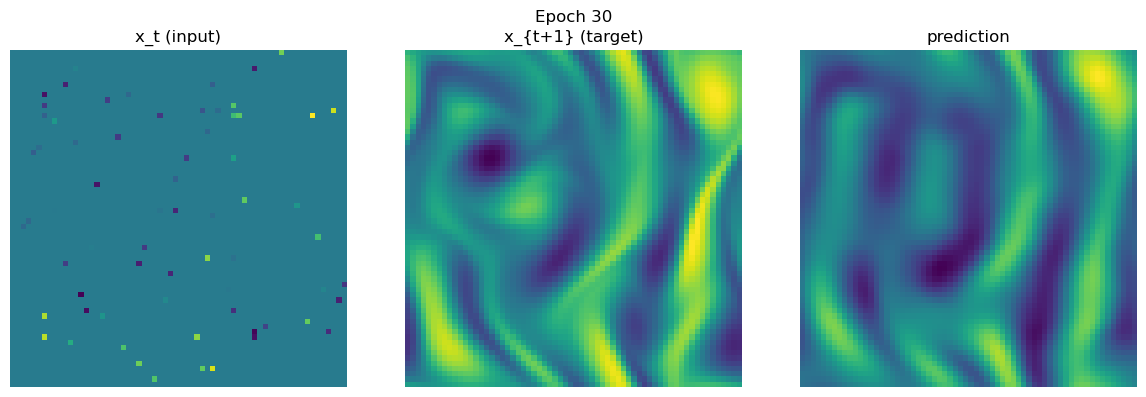

Epoch 31/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 31/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  31/50] train 0.7010 | val 0.7083 | lr 6.32e-05


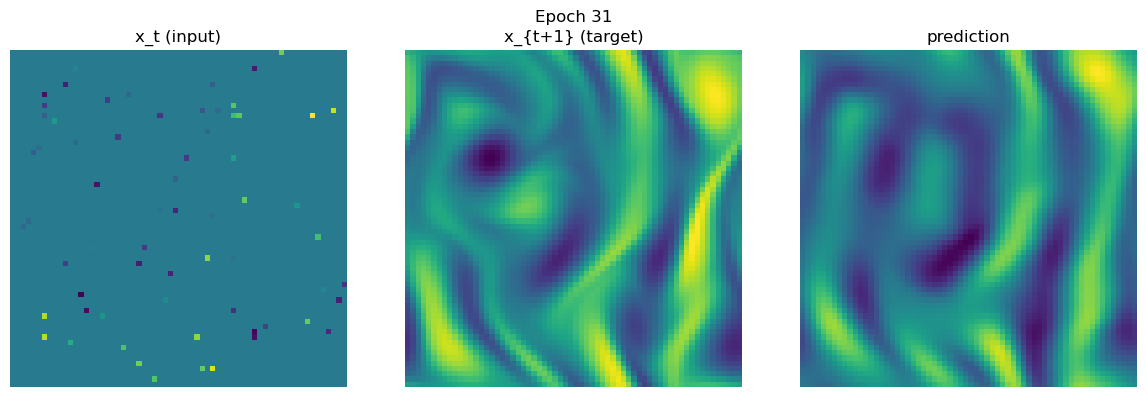

Epoch 32/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 32/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  32/50] train 0.6972 | val 0.7047 | lr 5.74e-05


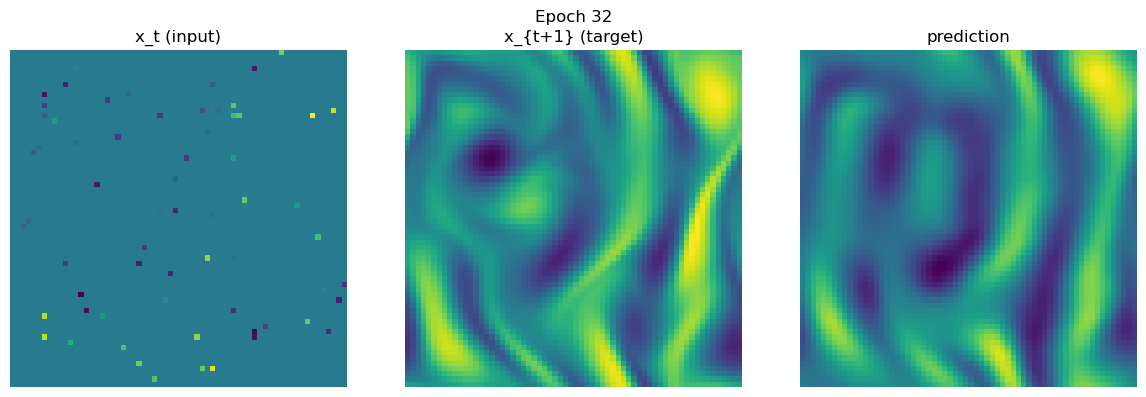

Epoch 33/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 33/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  33/50] train 0.6926 | val 0.6982 | lr 5.18e-05


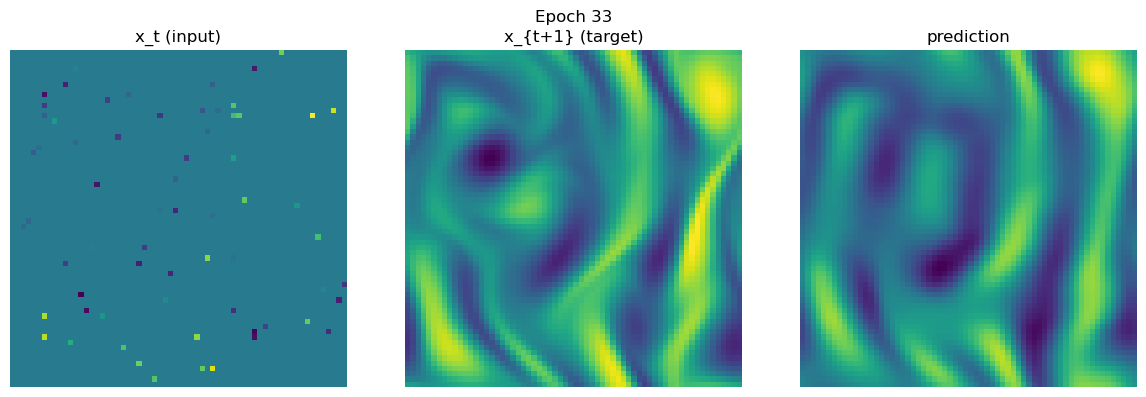

Epoch 34/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 34/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  34/50] train 0.6854 | val 0.6953 | lr 4.64e-05


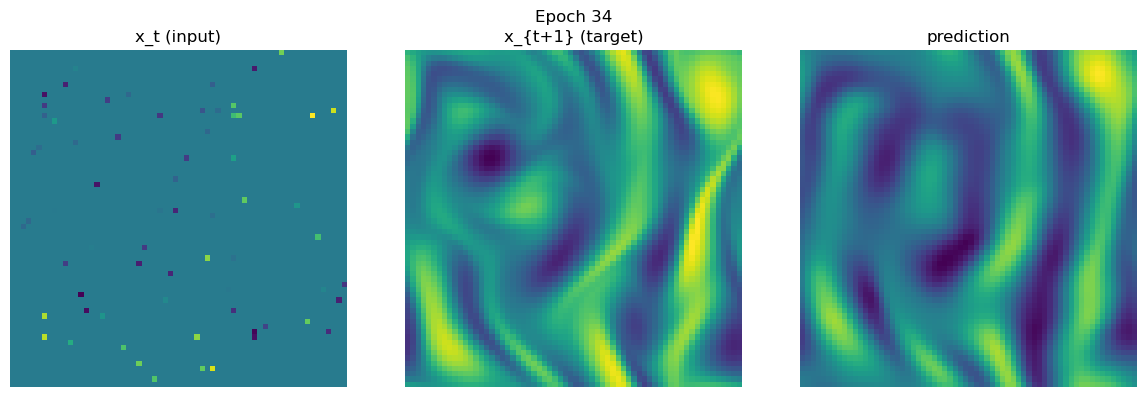

Epoch 35/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 35/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  35/50] train 0.6806 | val 0.6887 | lr 4.12e-05


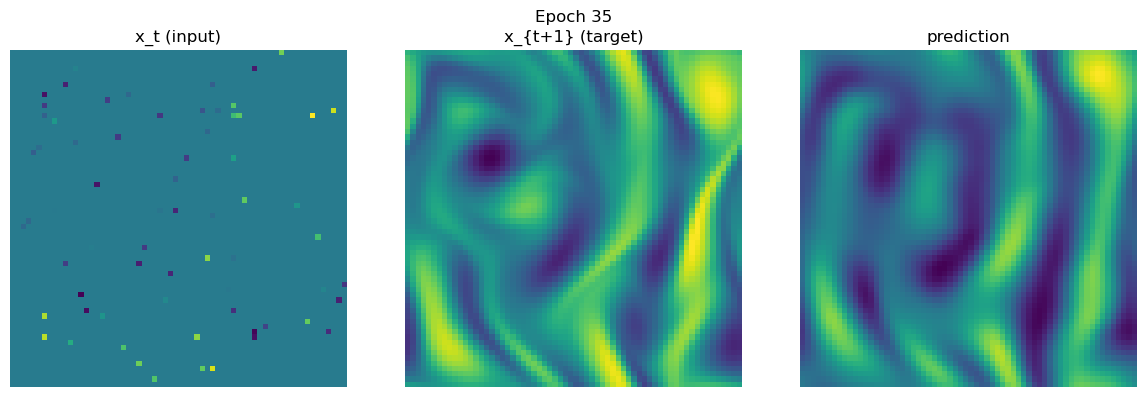

Epoch 36/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 36/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  36/50] train 0.6776 | val 0.6856 | lr 3.63e-05


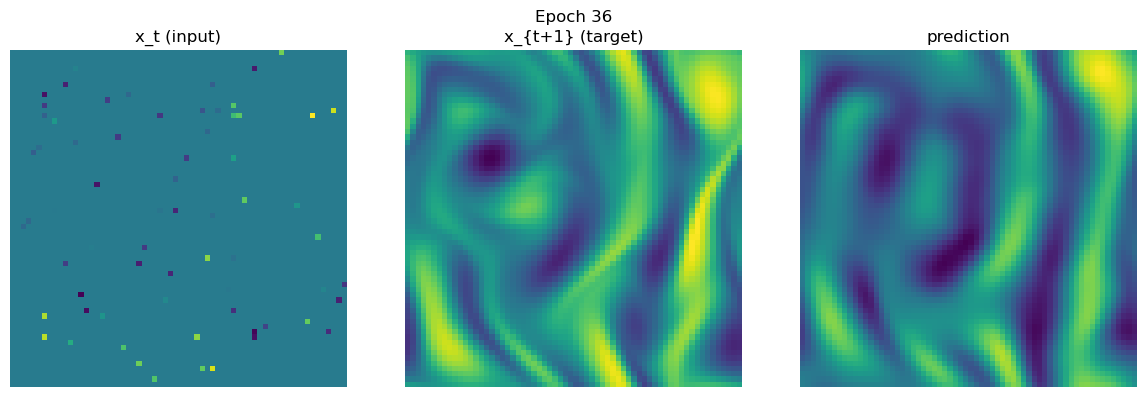

Epoch 37/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 37/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  37/50] train 0.6725 | val 0.6819 | lr 3.15e-05


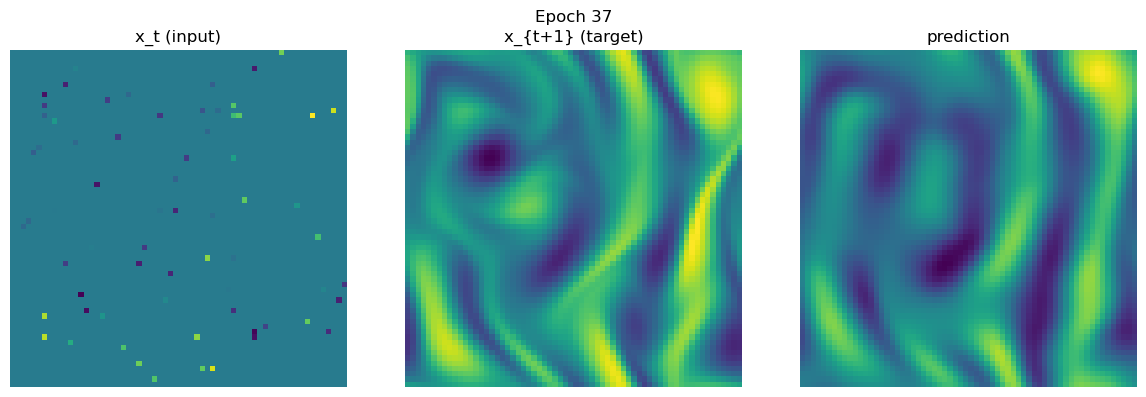

Epoch 38/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 38/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  38/50] train 0.6686 | val 0.6784 | lr 2.71e-05


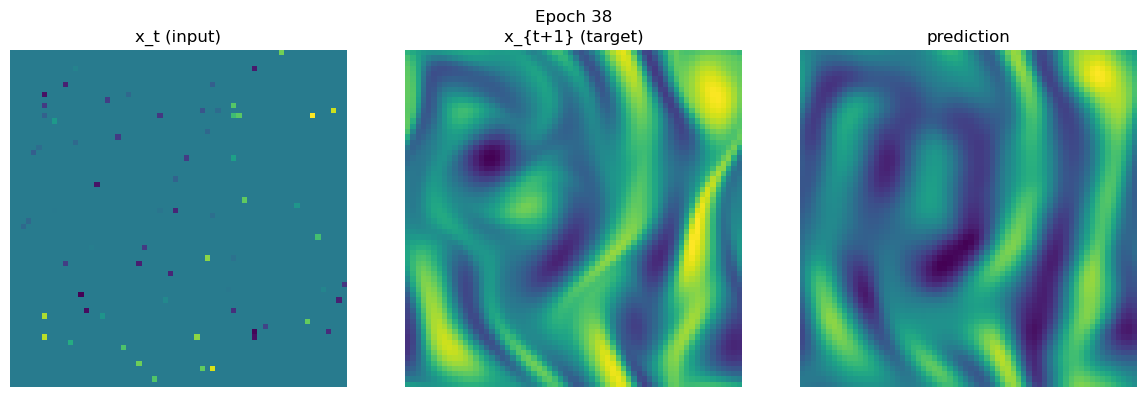

Epoch 39/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 39/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  39/50] train 0.6629 | val 0.6745 | lr 2.29e-05


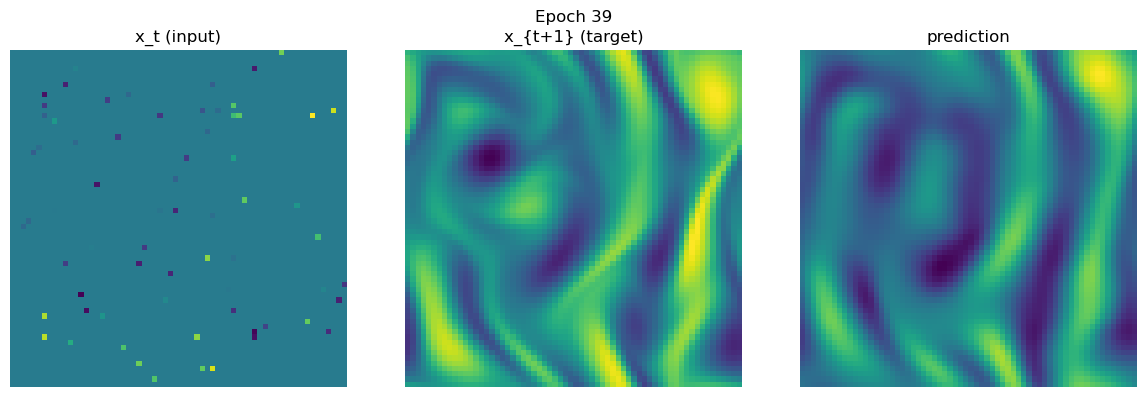

Epoch 40/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 40/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  40/50] train 0.6596 | val 0.6725 | lr 1.91e-05


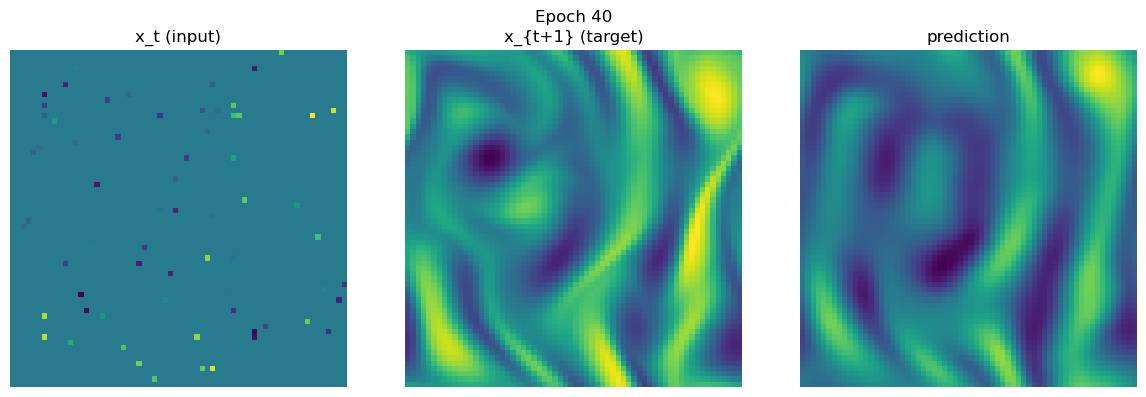

Epoch 41/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 41/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  41/50] train 0.6582 | val 0.6700 | lr 1.56e-05


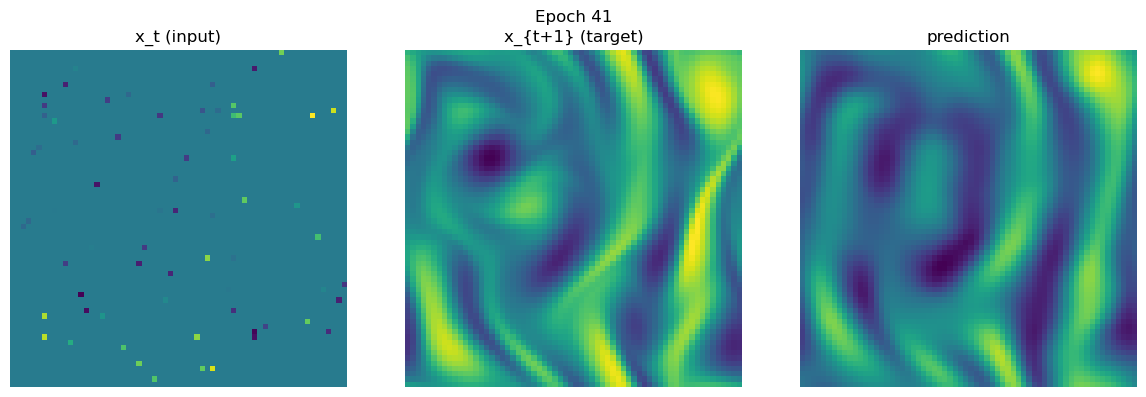

Epoch 42/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 42/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  42/50] train 0.6549 | val 0.6682 | lr 1.24e-05


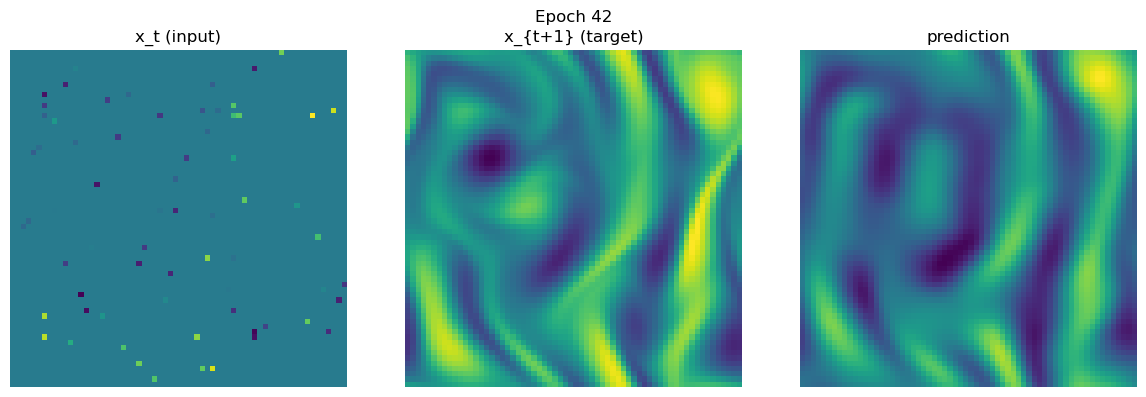

Epoch 43/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 43/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  43/50] train 0.6519 | val 0.6658 | lr 9.52e-06


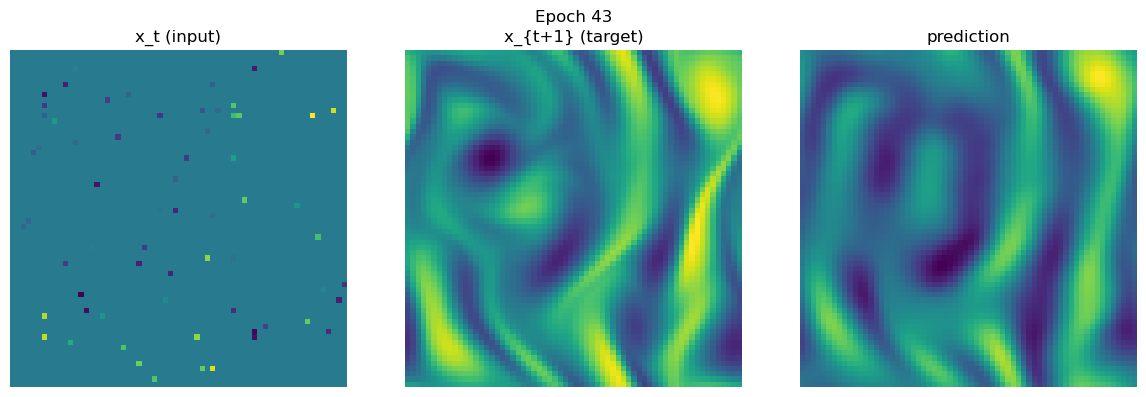

Epoch 44/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 44/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  44/50] train 0.6502 | val 0.6643 | lr 7.02e-06


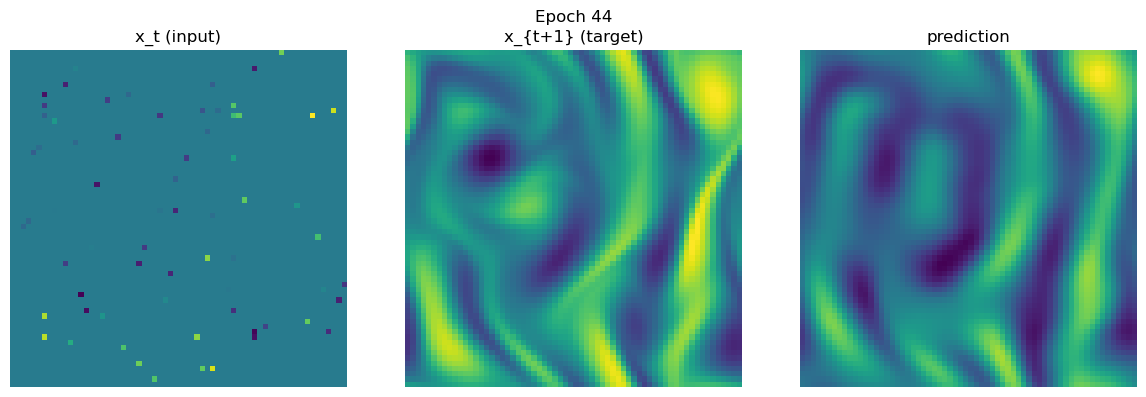

Epoch 45/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 45/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  45/50] train 0.6493 | val 0.6628 | lr 4.89e-06


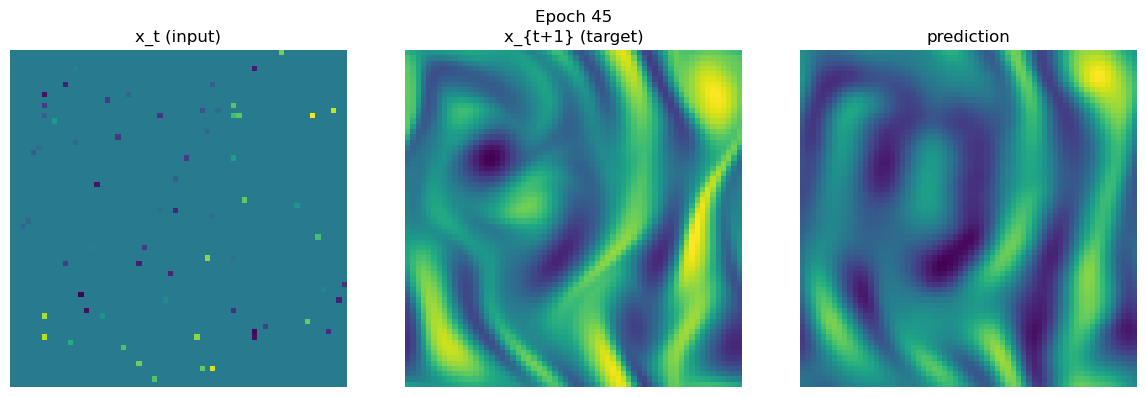

Epoch 46/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 46/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  46/50] train 0.6474 | val 0.6620 | lr 3.14e-06


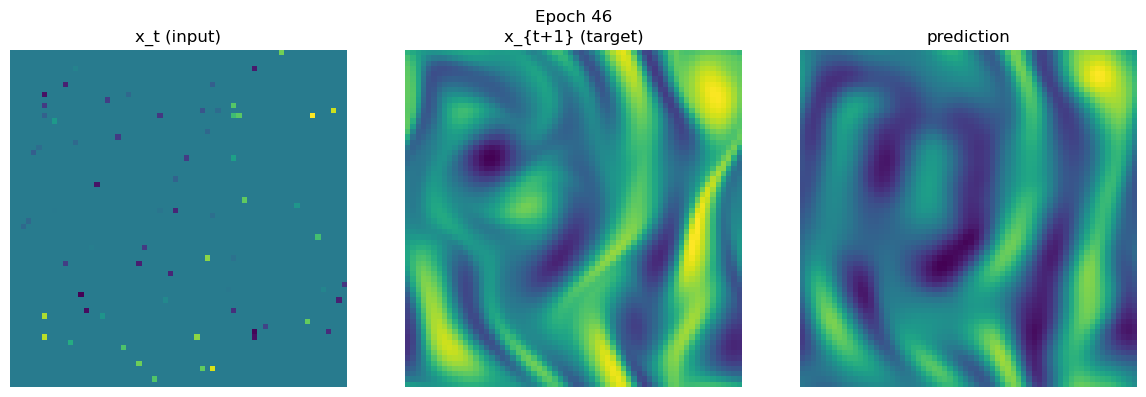

Epoch 47/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 47/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  47/50] train 0.6473 | val 0.6614 | lr 1.77e-06


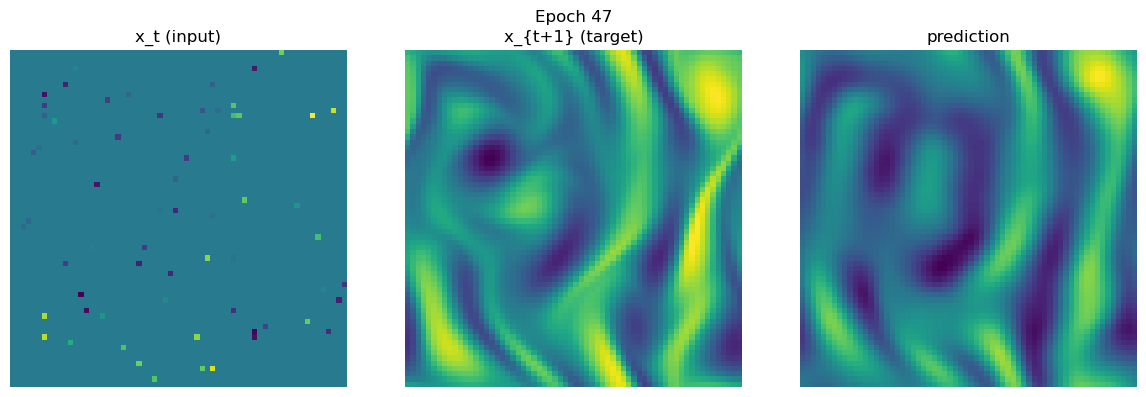

Epoch 48/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 48/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  48/50] train 0.6463 | val 0.6610 | lr 7.89e-07


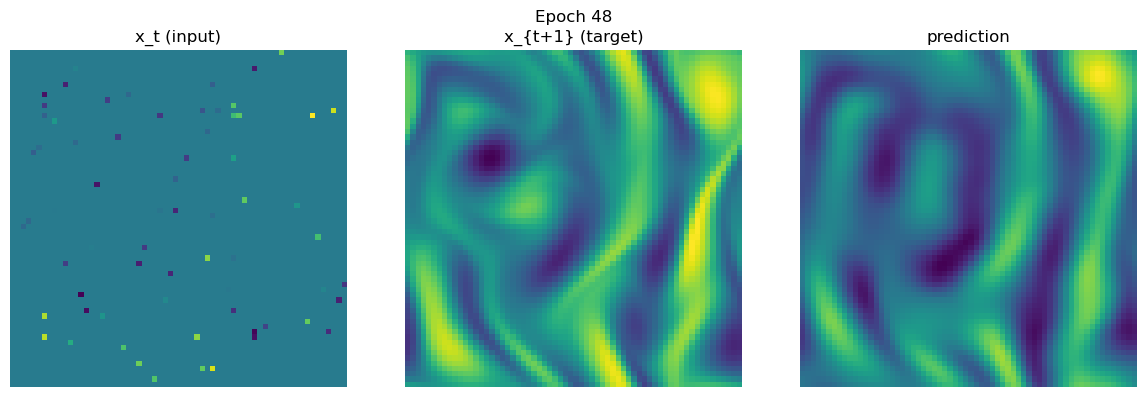

Epoch 49/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 49/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  49/50] train 0.6443 | val 0.6608 | lr 1.97e-07


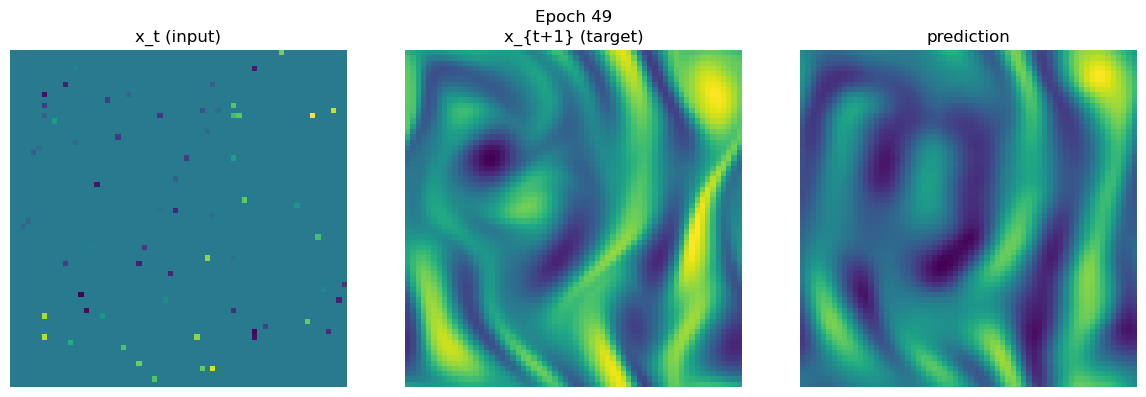

Epoch 50/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 50/50 [val]  :   0%|          | 0/77 [00:00<?, ?it/s]

[Epoch  50/50] train 0.6454 | val 0.6608 | lr 0.00e+00


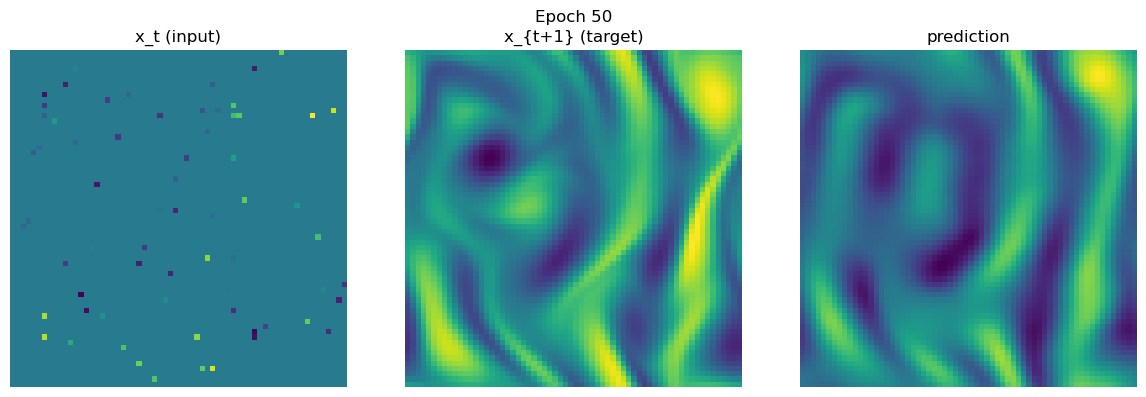

--- Training finished. ---


In [32]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from einops import rearrange, repeat
import ssl
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log
from functools import wraps
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
# Fix for torchvision dataset download issue
ssl._create_default_https_context = ssl._create_unverified_context
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ===============================================================
# --- 1. The One True Perceiver IO Model Architecture ---
# ===============================================================
D = 256
# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# helper classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, query_dim)
        self.latest_attn = None

    def forward(self, x, context = None, mask = None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)
        attn = sim.softmax(dim = -1)
        self.latest_attn = attn.detach()
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)

from math import log

# This helper function creates the sinusoidal embeddings
def get_sinusoidal_embeddings(n, d):
    """
    Generates sinusoidal positional embeddings.
    
    Args:
        n (int): The number of positions (num_latents).
        d (int): The embedding dimension (latent_dim).

    Returns:
        torch.Tensor: A tensor of shape (n, d) with sinusoidal embeddings.
    """
    # Ensure latent_dim is even for sin/cos pairs
    assert d % 2 == 0, "latent_dim must be an even number for sinusoidal embeddings"
    
    position = torch.arange(n, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2).float() * -(log(10000.0) / d))
    
    pe = torch.zeros(n, d)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def add_white_noise(coords, scale=0.01):
    return coords + torch.randn_like(coords) * scale




class CascadedBlock(nn.Module):
    def __init__(self, dim, n_latents, input_dim, cross_heads, cross_dim_head, self_heads, self_dim_head, residual_dim=None):
        super().__init__()
        self.latents = nn.Parameter(get_sinusoidal_embeddings(n_latents, dim), requires_grad=False)
        self.cross_attn = PreNorm(dim, Attention(dim, input_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=input_dim)
        self.self_attn = PreNorm(dim, Attention(dim, heads=self_heads, dim_head=self_dim_head))
        self.residual_proj = nn.Linear(residual_dim, dim) if residual_dim and residual_dim != dim else None
        self.ff = PreNorm(dim, FeedForward(dim))

    def forward(self, x, context, mask=None, residual=None):
        b = context.size(0)
        latents = repeat(self.latents, 'n d -> b n d', b=b)
        latents = self.cross_attn(latents, context=context, mask=mask) + latents
        if residual is not None:
            if self.residual_proj:
                residual = self.residual_proj(residual)
            latents = latents + residual
        latents = self.self_attn(latents) + latents
        latents = self.ff(latents) + latents
        return latents


class CascadedPerceiverIO(nn.Module):
    def __init__(
        self,
        *,
        input_dim,
        queries_dim,
        logits_dim = None,
        latent_dims=(512, 512, 512),
        num_latents=(256, 256, 256),
        cross_heads = 4,
        cross_dim_head = 128,
        self_heads = 8,
        self_dim_head = 128,
        decoder_ff = False,
        
    ):
        super().__init__()
        
        assert len(latent_dims) == len(num_latents), "latent_dims and num_latents must have same length"
        
    
        # self.input_proj = nn.Linear(4, 128)
        self.input_proj = nn.Sequential(
                nn.Linear(4, 128),
                nn.GELU(),
                nn.Linear(128, 128)
            )
        self.projection_matrix = nn.Parameter(torch.randn(4, 128) / np.sqrt(4)).to(DEVICE)
        # proj = torch.randn(4, 128) / np.sqrt(4)
        # self.projection_matrix = nn.Parameter(proj.detach())  # make it a leaf tenso

        # Cascaded encoder blocks
        self.encoder_blocks = nn.ModuleList()
        prev_dim = None
        for dim, n_latents in zip(latent_dims, num_latents):
            block = CascadedBlock(
                dim=dim,
                n_latents=n_latents,
                input_dim=input_dim,
                cross_heads=cross_heads,
                cross_dim_head=cross_dim_head,
                self_heads=self_heads,
                self_dim_head=self_dim_head,
                residual_dim=prev_dim
            )
            self.encoder_blocks.append(block)
            prev_dim = dim

        # Decoder
        final_latent_dim = latent_dims[-1]
        self.decoder_cross_attn = PreNorm(queries_dim, Attention(queries_dim, final_latent_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=final_latent_dim)
        self.decoder_ff = PreNorm(queries_dim, FeedForward(queries_dim)) if decoder_ff else None
        self.to_logits = nn.Linear(queries_dim, logits_dim) if exists(logits_dim) else nn.Identity()
        

        # self.decoder_swin = SwinTransformerLayer(
        #     dim=queries_dim,
        #     depth=2,                  # or 4 if you want deeper decoding
        #     num_heads=4,
        #     window_size=16,           # assuming 64x64 → 4096 tokens → 256 windows of size 16
        #     mlp_ratio=4.0,
        #     drop_path=0.1,
        #     use_checkpoint=False
        # )
        self.self_attn_blocks = nn.Sequential(*[
        nn.Sequential(
            PreNorm(latent_dims[-1], Attention(latent_dims[-1], heads=self_heads, dim_head=self_dim_head)),
            PreNorm(latent_dims[-1], FeedForward(latent_dims[-1]))
        )
        for _ in range(4)  # or 3
    ])

    def forward(self, data, mask=None, queries=None):
        b = data.size(0)
        residual = None

        
        for block in self.encoder_blocks:
            residual = block(x=residual, context=data, mask=mask, residual=residual)

            
            
            
        for sa_block in self.self_attn_blocks:
            residual = sa_block[0](residual) + residual
            residual = sa_block[1](residual) + residual
        
        if  b == 1:  # Optional: only log for one sample
            latent_std = residual.std(dim=1).mean().item()
            print(f"[Latent std]: {latent_std:.4f}")
        
        if queries is None:
            return latents

        if queries.ndim == 2:
            queries = repeat(queries, 'n d -> b n d', b=b)

        x = self.decoder_cross_attn(queries, context=residual)

        # Optional: skip connection to preserve input query encoding
        x = x + queries

        # Local refinement (like SCENT)
        # x = self.decoder_swin(x)

        # Final FF
        if self.decoder_ff:
            x = x + self.decoder_ff(x)

        return self.to_logits(x)


# %% Imports
import os, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange, repeat

# # =========================================================
# # 1) Hyperparams (64x64, 1-channel)
# # =========================================================
# BATCH_SIZE   = 64
# EPOCHS       = 50
# LEARNING_RATE = 2e-4
# DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# H = W = 64          # training resolution matches your data
# CHANNELS = 1        # scalar field

# FOURIER_MAPPING_SIZE = 96
# POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
# INPUT_DIM  = CHANNELS + POS_EMBED_DIM
# QUERIES_DIM = POS_EMBED_DIM
# LOGITS_DIM  = CHANNELS

# # =========================================================
# # 2) Positional encoder (Fourier features)
# # =========================================================
# class GaussianFourierFeatures(nn.Module):
#     def __init__(self, in_features, mapping_size, scale=5.0):
#         super().__init__()
#         self.in_features = in_features
#         self.mapping_size = mapping_size
#         self.register_buffer('B', torch.randn((in_features, mapping_size)) * scale)

#     def forward(self, coords):
#         # coords: [B or N, 2]
#         proj = coords @ self.B   # [..., mapping_size]
#         return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # [..., 2*mapping_size]

# fourier_encoder = GaussianFourierFeatures(
#     in_features=2, mapping_size=FOURIER_MAPPING_SIZE, scale=5.0
# ).to(DEVICE)

# # =========================================================
# # 3) Coordinate grids (64x64 for training; optional 128x128 for eval)
# # =========================================================
# def create_coordinate_grid(h, w, device):
#     yy, xx = torch.meshgrid(
#         torch.linspace(-1.0, 1.0, h, device=device),
#         torch.linspace(-1.0, 1.0, w, device=device),
#         indexing='ij'
#     )
#     grid = torch.stack([yy, xx], dim=-1)    # [H, W, 2]
#     return rearrange(grid, 'h w c -> (h w) c')  # [H*W, 2]

# coords_64 = create_coordinate_grid(H, W, DEVICE)                # [4096, 2]
# coords_128 = create_coordinate_grid(128, 128, DEVICE)           # optional high-res

# # =========================================================
# # 4) Model (assumes CascadedPerceiverIO is available)
# # =========================================================
# # from your_module import CascadedPerceiverIO
# model = CascadedPerceiverIO(
#     input_dim=INPUT_DIM,
#     queries_dim=QUERIES_DIM,
#     logits_dim=LOGITS_DIM,
#     latent_dims=(256, 384, 512),
#     num_latents=(256, 256, 256),
#     decoder_ff=True
# ).to(DEVICE)

# optimizer = AdamW(list(model.parameters()) + list(fourier_encoder.parameters()), lr=LEARNING_RATE)
# loss_fn = nn.MSELoss()

# print(f"Training on {DEVICE}")
# total_params = sum(p.numel() for p in model.parameters()) + sum(p.numel() for p in fourier_encoder.parameters())
# print(f"Total parameters: {total_params/1e6:.2f}M")

# # =========================================================
# # 5) Build index_pairs for next-step prediction and DataLoaders
# #    (uses only up to 1,000 items; loader already does sparsity & normalization)
# # =========================================================
# rng = np.random.default_rng(0)
# MAX_ITEMS = 1000

# num_items_total = len(mem)
# chosen_item_idxs = rng.choice(num_items_total, size=min(MAX_ITEMS, num_items_total), replace=False)
# chosen_item_idxs = np.sort(chosen_item_idxs)

# # assume uniform T across items, e.g., T=50
# T = int(mem[int(chosen_item_idxs[0])].shape[0])
# assert T >= 2, "Need at least 2 frames per item."

# index_pairs = []
# for it in chosen_item_idxs:
#     for t in range(T - 1):
#         index_pairs.append((int(it), int(t)))
# index_pairs = np.asarray(index_pairs, dtype=np.int64)

# print(f"Using {len(chosen_item_idxs)} items; built {len(index_pairs)} (t→t+1) pairs with T={T}.")

# # Dataset from earlier (fixed z-norm + sparsity already inside; keep it as you configured)
# # If you want to keep the same settings as before:
# SPARSITY = 0.2     # keep 20% (loader applies to x_t only); change if desired
# MEAN = 0.0
# STD  = 2.4036

# # If RaggedNextStepDataset is not in scope, re-define it quickly:
# try:
#     RaggedNextStepDataset
# except NameError:
#     class RaggedNextStepDataset(torch.utils.data.Dataset):
#         def __init__(self, memmap, index_pairs, normalize=True, sparsity=1.0, seed=None,
#                      mean=0.0, std=2.4036):
#             self.mem = memmap
#             self.index_pairs = index_pairs
#             self.normalize = normalize
#             self.sparsity = sparsity
#             self.rng = np.random.default_rng(seed)
#             self.mean = mean
#             self.std = std
#         def z_normalize(self, arr):   return (arr - self.mean) / self.std
#         def z_unnormalize(self, arr): return arr * self.std + self.mean
#         def __len__(self): return len(self.index_pairs)
#         def __getitem__(self, i):
#             item_idx, t = self.index_pairs[i]
#             seq = self.mem[item_idx]               # (T, H, W)
#             x  = np.asarray(seq[t],   dtype=np.float32)
#             y  = np.asarray(seq[t+1], dtype=np.float32)
#             if self.normalize:
#                 x = self.z_normalize(x); y = self.z_normalize(y)
#             if self.sparsity < 1.0:
#                 mask = self.rng.random(x.shape) < self.sparsity
#                 x = x * mask.astype(np.float32)
#             x = torch.from_numpy(x[None, ...])   # (1,H,W)
#             y = torch.from_numpy(y[None, ...])
#             return x, y

# full_ds = RaggedNextStepDataset(mem, index_pairs, normalize=True,
#                                 sparsity=SPARSITY, seed=42, mean=MEAN, std=STD)

# # Split
# val_frac = 0.10
# val_len = int(len(full_ds) * val_frac)
# train_len = len(full_ds) - val_len
# train_ds, val_ds = random_split(full_ds, [train_len, val_len],
#                                 generator=torch.Generator().manual_seed(0))

# # Loaders
# NUM_WORKERS = 2   # set to 0 if workers misbehave on shared FS
# PIN_MEMORY  = (DEVICE == "cuda")

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
#                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
#                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

# # Scheduler after loaders exist (needs steps per epoch)
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))

# # =========================================================
# # 6) Helper: prepare model inputs (concat pixels + pos enc)
# # =========================================================
# def prepare_model_input(images, coords, fourier_encoder_fn):
#     """
#     images: [B, 1, H, W]
#     coords: [N=H*W, 2]
#     returns:
#       input_with_pos: [B, N, 1 + Dpos]
#       target_pixels : [B, N, 1] (if you pass y through this helper)
#       pos_embeddings: [B, N, Dpos]
#     """
#     b, c, h, w = images.shape
#     assert c == 1 and h == H and w == W, f"expected [B,1,{H},{W}], got {images.shape}"
#     pixels = rearrange(images, 'b c h w -> b (h w) c')  # [B, N, 1]
#     batch_coords = repeat(coords, 'n d -> b n d', b=b)  # [B, N, 2]
#     pos_embeddings = fourier_encoder_fn(batch_coords)   # [B, N, Dpos]
#     input_with_pos = torch.cat((pixels, pos_embeddings), dim=-1)  # [B, N, 1+Dpos]
#     return input_with_pos, pixels, pos_embeddings

# # =========================================================
# # 7) Train / Validate
# # =========================================================
# def show_example(xb, yb, pred_pixels, title=""):
#     """Quick viz for a single sample."""
#     with torch.no_grad():
#         x_img = xb[0, 0].detach().cpu().numpy()
#         y_img = yb[0, 0].detach().cpu().numpy()
#         p_img = rearrange(pred_pixels[0], '(h w) c -> c h w', h=H, w=W)[0].detach().cpu().numpy()

#         fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#         axs[0].imshow(x_img); axs[0].set_title("x_t (input)"); axs[0].axis('off')
#         axs[1].imshow(y_img); axs[1].set_title("x_{t+1} (target)"); axs[1].axis('off')
#         axs[2].imshow(p_img); axs[2].set_title("prediction"); axs[2].axis('off')
#         fig.suptitle(title)
#         plt.tight_layout(); plt.show()

# for epoch in range(EPOCHS):
#     # ---------- Train ----------
#     model.train(); fourier_encoder.train()
#     total_train_loss = 0.0

#     for xb, yb in train_loader:
#         xb = xb.to(DEVICE, non_blocking=True)  # [B,1,64,64] (sparse + normalized)
#         yb = yb.to(DEVICE, non_blocking=True)  # [B,1,64,64] (normalized)

#         # Prepare inputs
#         input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder)      # [B,N,1+Dpos]
#         target_pixels = rearrange(yb, 'b c h w -> b (h w) c')                        # [B,N,1]
#         queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))  # [B,N,Dpos]

#         # Forward
#         optimizer.zero_grad(set_to_none=True)
#         pred_pixels = model(input_data, queries=queries)  # [B,N,1]
#         loss = loss_fn(pred_pixels, target_pixels)

#         # Backprop
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         total_train_loss += loss.item()

#     avg_train_loss = total_train_loss / len(train_loader)

#     # ---------- Validate ----------
#     model.eval(); fourier_encoder.eval()
#     total_val_loss = 0.0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             xb = xb.to(DEVICE, non_blocking=True)
#             yb = yb.to(DEVICE, non_blocking=True)
#             input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder)
#             target_pixels = rearrange(yb, 'b c h w -> b (h w) c')
#             queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))
#             pred_pixels = model(input_data, queries=queries)
#             total_val_loss += loss_fn(pred_pixels, target_pixels).item()

#     avg_val_loss = total_val_loss / len(val_loader)
#     print(f"[Epoch {epoch+1:3d}/{EPOCHS}] train {avg_train_loss:.4f} | val {avg_val_loss:.4f} | lr {scheduler.get_last_lr()[0]:.6e}")

#     # ---------- Quick visualization ----------
#     with torch.no_grad():
#         xb_vis, yb_vis = next(iter(val_loader))
#         xb_vis = xb_vis.to(DEVICE)[:8]
#         yb_vis = yb_vis.to(DEVICE)[:8]
#         input_data, _, _ = prepare_model_input(xb_vis, coords_64, fourier_encoder)
#         queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb_vis.size(0))
#         pred_pixels = model(input_data, queries=queries)     # [B,N,1]
#         show_example(xb_vis, yb_vis, pred_pixels, title=f"Epoch {epoch+1}")

# print("--- Training finished. ---")



# %% ------------- 64x64 next-step training with tqdm progress -------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from tqdm.auto import tqdm

# ----------------- Hyperparams -----------------
BATCH_SIZE    = 64
EPOCHS        = 50
LEARNING_RATE = 2e-4
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

H = W = 64            # your data resolution
CHANNELS = 1          # scalar field (single channel)

FOURIER_MAPPING_SIZE = 96
POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
INPUT_DIM   = CHANNELS + POS_EMBED_DIM
QUERIES_DIM = POS_EMBED_DIM
LOGITS_DIM  = CHANNELS

MAX_ITEMS = 1000      # use up to 1000 items
VAL_FRAC  = 0.10
NUM_WORKERS = 2       # set to 0 if shared FS workers cause issues
PIN_MEMORY  = (DEVICE == "cuda")

# ----------------- Fourier PE -----------------
class GaussianFourierFeatures(nn.Module):
    def __init__(self, in_features, mapping_size, scale=5.0):
        super().__init__()
        self.register_buffer('B', torch.randn((in_features, mapping_size)) * scale)

    def forward(self, coords):
        proj = coords @ self.B                    # [..., M]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # [..., 2M]

fourier_encoder = GaussianFourierFeatures(2, FOURIER_MAPPING_SIZE, scale=5.0).to(DEVICE)

# ----------------- Coords -----------------
def create_coordinate_grid(h, w, device):
    yy, xx = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, device=device),
        torch.linspace(-1.0, 1.0, w, device=device),
        indexing='ij'
    )
    grid = torch.stack([yy, xx], dim=-1)     # [H, W, 2]
    return rearrange(grid, 'h w c -> (h w) c')  # [H*W, 2]

coords_64  = create_coordinate_grid(H, W, DEVICE)                # [4096, 2]
coords_128 = create_coordinate_grid(128, 128, DEVICE)            # optional high-res

# Optional small speedup: precompute pos encodings (B is a buffer -> fixed)
PRECOMPUTE_POS = True
pos_64_const = fourier_encoder(coords_64) if PRECOMPUTE_POS else None

# ----------------- Model -----------------
# Assumes CascadedPerceiverIO is already imported/available
model = CascadedPerceiverIO(
    input_dim=INPUT_DIM,
    queries_dim=QUERIES_DIM,
    logits_dim=LOGITS_DIM,
    latent_dims=(256, 384, 512),
    num_latents=(256, 256, 256),
    decoder_ff=True
).to(DEVICE)

optimizer = AdamW(list(model.parameters()) + list(fourier_encoder.parameters()), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print(f"Training on {DEVICE}")
total_params = sum(p.numel() for p in model.parameters()) + sum(p.numel() for p in fourier_encoder.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")

# ----------------- Build (item, t) pairs -----------------
rng = np.random.default_rng(0)
num_items_total = len(mem)
chosen_item_idxs = rng.choice(num_items_total, size=min(MAX_ITEMS, num_items_total), replace=False)
chosen_item_idxs = np.sort(chosen_item_idxs)

T = int(mem[int(chosen_item_idxs[0])].shape[0])  # e.g., 50
assert T >= 2, "Need at least 2 frames per item."
index_pairs = [(int(it), int(t)) for it in chosen_item_idxs for t in range(T - 1)]
index_pairs = np.asarray(index_pairs, dtype=np.int64)

print(f"Using {len(chosen_item_idxs)} items; built {len(index_pairs)} (t→t+1) pairs with T={T}.")

# ----------------- Dataset & Loaders -----------------
# Uses your RaggedNextStepDataset already defined in your notebook.
# Example: RaggedNextStepDataset(mem, index_pairs, normalize=True, sparsity=0.2, seed=42, mean=0.0, std=2.4036)
full_ds = RaggedNextStepDataset(mem, index_pairs, normalize=True, sparsity=0.02, seed=42, mean=0.0, std=2.4036)  # keep your own ctor args if you want (normalize/sparsity/mean/std)

val_len = int(len(full_ds) * VAL_FRAC)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))

# ----------------- Helpers -----------------
def prepare_model_input(images, coords, fourier_encoder_fn, pos_embeddings_const=None):
    """
    images: [B,1,H,W]
    returns input_with_pos:[B,N,1+Dpos], target_pixels:[B,N,1], pos_embeddings:[B,N,Dpos]
    """
    b, c, h, w = images.shape
    assert c == 1 and h == H and w == W, f"expected [B,1,{H},{W}], got {images.shape}"
    pixels = rearrange(images, 'b c h w -> b (h w) c')  # [B, N, 1]

    if pos_embeddings_const is None:
        batch_coords = repeat(coords, 'n d -> b n d', b=b)
        pos_embeddings = fourier_encoder_fn(batch_coords)        # [B,N,Dpos]
    else:
        pos_embeddings = repeat(pos_embeddings_const, 'n d -> b n d', b=b)

    input_with_pos = torch.cat((pixels, pos_embeddings), dim=-1)  # [B,N,1+Dpos]
    return input_with_pos, pixels, pos_embeddings

def show_example(xb, yb, pred_pixels, title=""):
    with torch.no_grad():
        x_img = xb[0, 0].detach().cpu().numpy()
        y_img = yb[0, 0].detach().cpu().numpy()
        p_img = rearrange(pred_pixels[0], '(h w) c -> c h w', h=H, w=W)[0].detach().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_img); axs[0].set_title("x_t (input)"); axs[0].axis('off')
        axs[1].imshow(y_img); axs[1].set_title("x_{t+1} (target)"); axs[1].axis('off')
        axs[2].imshow(p_img); axs[2].set_title("prediction"); axs[2].axis('off')
        fig.suptitle(title); plt.tight_layout(); plt.show()

# ----------------- Train / Validate with tqdm -----------------
for epoch in range(EPOCHS):
    # ----- Train -----
    model.train(); fourier_encoder.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)
    for xb, yb in pbar:
        xb = xb.to(DEVICE, non_blocking=True)  # [B,1,64,64]
        yb = yb.to(DEVICE, non_blocking=True)  # [B,1,64,64]

        input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
        # queries are just positional encodings
        if PRECOMPUTE_POS:
            queries = repeat(pos_64_const, 'n d -> b n d', b=xb.size(0))
        else:
            queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))

        target_pixels = rearrange(yb, 'b c h w -> b (h w) c')

        optimizer.zero_grad(set_to_none=True)
        pred_pixels = model(input_data, queries=queries)
        loss = loss_fn(pred_pixels, target_pixels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_train += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

    avg_train = running_train / len(train_loader)

    # ----- Validate -----
    model.eval(); fourier_encoder.eval()
    running_val = 0.0
    with torch.no_grad():
        pbar_v = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]  ", leave=False)
        for xb, yb in pbar_v:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            input_data, _, _ = prepare_model_input(xb, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
            if PRECOMPUTE_POS:
                queries = repeat(pos_64_const, 'n d -> b n d', b=xb.size(0))
            else:
                queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb.size(0))

            target_pixels = rearrange(yb, 'b c h w -> b (h w) c')
            pred_pixels = model(input_data, queries=queries)
            running_val += loss_fn(pred_pixels, target_pixels).item()

    avg_val = running_val / len(val_loader)
    print(f"[Epoch {epoch+1:3d}/{EPOCHS}] train {avg_train:.4f} | val {avg_val:.4f} | lr {scheduler.get_last_lr()[0]:.2e}")

    # Quick visualization each epoch
    with torch.no_grad():
        xb_vis, yb_vis = next(iter(val_loader))
        xb_vis = xb_vis.to(DEVICE)[:8]
        yb_vis = yb_vis.to(DEVICE)[:8]
        input_data, _, _ = prepare_model_input(xb_vis, coords_64, fourier_encoder, pos_embeddings_const=pos_64_const)
        if PRECOMPUTE_POS:
            queries = repeat(pos_64_const, 'n d -> b n d', b=xb_vis.size(0))
        else:
            queries = repeat(fourier_encoder(coords_64), 'n d -> b n d', b=xb_vis.size(0))
        pred_pixels = model(input_data, queries=queries)
        show_example(xb_vis, yb_vis, pred_pixels, title=f"Epoch {epoch+1}")

print("--- Training finished. ---")



In [3]:
# %% [markdown]
# PerceiverIO for Navier–Stokes next-step forecasting (fixed per-sample mask)
# - Fixed, deterministic sparsity mask per (item_idx, t)
# - Val prints MSE, RMSE, MAE, CRPS (K=10), plus unnormalized versions
# - Best checkpoint saved under NavierStokesCheckpoints/SCENT/<dataset_tag>/<sparsity_tag>/best.pt

# %%
import os, ssl, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context
from mmap_ninja import RaggedMmap

# -----------------------
# Config (EDIT THESE)
# -----------------------
DEVICE   = "cuda:1" if torch.cuda.is_available() else "cpu"
H = W    = 64
CHANNELS = 1
BATCH_SIZE = 64
EPOCHS     = 50
LR         = 2e-4
SPARSITY   = 0.2          # e.g., 0.20 -> 20% visible
MEAN, STD  = 0.0, 2.4036
FOURIER_MAPPING_SIZE = 96
POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
INPUT_DIM   = CHANNELS + POS_EMBED_DIM
QUERIES_DIM = POS_EMBED_DIM
LOGITS_DIM  = CHANNELS
CRPS_K      = 10           # ensemble members for CRPS

# memmap dir
BASE_DIR = "/pscratch/sd/d/dpark1/NSData"  # <-- EDIT
NAME     = "100k"                          # <-- EDIT
mmap_path = os.path.join(BASE_DIR, NAME)

# -----------------------
# Helpers
# -----------------------
def exists(x): return x is not None
def default(val, d): return val if exists(val) else d

def create_coordinate_grid(h, w, device):
    yy, xx = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, device=device),
        torch.linspace(-1.0, 1.0, w, device=device),
        indexing='ij'
    )
    return rearrange(torch.stack([yy, xx], dim=-1), 'h w c -> (h w) c')

def build_index_pairs(mem, max_items=100, seed=0):
    rng = np.random.default_rng(seed)
    num_items_total = len(mem)
    pick = min(max_items, num_items_total)
    chosen_item_idxs = np.sort(rng.choice(num_items_total, size=pick, replace=False))
    T = int(mem[int(chosen_item_idxs[0])].shape[0])
    assert T >= 2, "Need T>=2"
    pairs = [(int(it), int(t)) for it in chosen_item_idxs for t in range(T-1)]
    pairs = np.asarray(pairs, dtype=np.int64)
    print(f"Using {len(chosen_item_idxs)} items; built {len(pairs)} (t→t+1) pairs with T={T}.")
    return pairs, T

# -----------------------
# Dataset (fixed per-sample mask)
# -----------------------
class NavierStokesSparseNextStep(Dataset):
    def __init__(self, memmap, index_pairs, sparsity=0.05,
                 normalize=True, mean=0.0, std=1.0,
                 to_unit_range=False, seed=42, verbose=True,
                 fixed_mask_per_sample=True, mask_seed=0):
        self.mem = memmap
        self.index_pairs = np.asarray(index_pairs, dtype=np.int64)
        self.normalize = bool(normalize)
        self.mean = float(mean)
        self.std  = float(std)
        self.to_unit_range = bool(to_unit_range)
        self.sparsity = float(sparsity)
        self.rng = np.random.default_rng(seed)  # only used if not fixed
        self.fixed_mask_per_sample = bool(fixed_mask_per_sample)
        self.mask_seed = int(mask_seed)

        it0 = int(self.index_pairs[0, 0])
        self.T = int(self.mem[it0].shape[0])
        if verbose:
            print(f"[NS Sparse] pairs={len(self.index_pairs)}, T={self.T}, "
                  f"sparsity={self.sparsity}, normalize={self.normalize}, "
                  f"unit_range={self.to_unit_range}, fixed_mask_per_sample={self.fixed_mask_per_sample}")

    def __len__(self): return len(self.index_pairs)
    def _z(self, a): return (a - self.mean) / self.std
    def _unit(self, a): return np.tanh(a)

    def __getitem__(self, i):
        item_idx, t = map(int, self.index_pairs[i])
        seq = self.mem[item_idx]  # (T,H,W)
        x = np.asarray(seq[t],   dtype=np.float32)
        y = np.asarray(seq[t+1], dtype=np.float32)

        if self.normalize:
            x = self._z(x); y = self._z(y)
        if self.to_unit_range:
            x = self._unit(x); y = self._unit(y)

        # deterministic per-sample mask keyed by sample_id
        sid = int(item_idx * self.T + t)
        if self.fixed_mask_per_sample:
            rng = np.random.default_rng(self.mask_seed + sid)
            mask = rng.random(x.shape, dtype=np.float32) < self.sparsity
        else:
            mask = self.rng.random(x.shape, dtype=np.float32) < self.sparsity

        x_sparse = x * mask.astype(np.float32)

        x_sparse = torch.from_numpy(x_sparse[None, ...])       # (1,H,W)
        y        = torch.from_numpy(y[None, ...])              # (1,H,W)
        mask     = torch.from_numpy(mask.astype(np.bool_))     # (H,W)
        sample_id = torch.tensor(sid, dtype=torch.long)
        return x_sparse, y, mask, sample_id

# -----------------------
# PerceiverIO (core)
# -----------------------
class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None
    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            kwargs.update(context=self.norm_context(kwargs['context']))
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x): return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)
    def forward(self, x, context=None, mask=None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg)
        attn = sim.softmax(dim=-1)
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

def cache_fn(f):
    cache = None
    def cached_fn(*args, _cache=True, **kwargs):
        nonlocal cache
        if not _cache: return f(*args, **kwargs)
        if cache is not None: return cache
        cache = f(*args, **kwargs); return cache
    return cached_fn

class PerceiverIO(nn.Module):
    def __init__(self, *, depth, dim, queries_dim, logits_dim=None,
                 num_latents=256, latent_dim=512,
                 cross_heads=1, latent_heads=8,
                 cross_dim_head=64, latent_dim_head=64,
                 weight_tie_layers=False, decoder_ff=True, seq_dropout_prob=0.):
        super().__init__()
        self.seq_dropout_prob = seq_dropout_prob
        self.register_buffer('latents', torch.randn(num_latents, latent_dim))
        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim, dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=dim),
            PreNorm(latent_dim, FeedForward(latent_dim))
        ])
        get_latent_attn = lambda: PreNorm(latent_dim, Attention(latent_dim, heads=latent_heads, dim_head=latent_dim_head))
        get_latent_ff   = lambda: PreNorm(latent_dim, FeedForward(latent_dim))
        get_latent_attn, get_latent_ff = map(cache_fn, (get_latent_attn, get_latent_ff))
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}
        for _ in range(depth):
            self.layers.append(nn.ModuleList([get_latent_attn(**cache_args),
                                              get_latent_ff(**cache_args)]))
        self.decoder_cross_attn = PreNorm(queries_dim, Attention(queries_dim, latent_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=latent_dim)
        self.decoder_ff = PreNorm(queries_dim, FeedForward(queries_dim)) if decoder_ff else None
        self.to_logits = nn.Linear(queries_dim, logits_dim) if exists(logits_dim) else nn.Identity()
    def forward(self, data, mask=None, queries=None):
        b, *_ = data.shape
        x = repeat(self.latents, 'n d -> b n d', b=b)
        cross_attn, cross_ff = self.cross_attend_blocks
        x = cross_attn(x, context=data, mask=mask) + x
        x = cross_ff(x) + x
        for self_attn, self_ff in self.layers:
            x = self_attn(x) + x
            x = self_ff(x) + x
        if not exists(queries): return x
        if queries.ndim == 2:
            queries = repeat(queries, 'n d -> b n d', b=b)
        latents = self.decoder_cross_attn(queries, context=x)
        if exists(self.decoder_ff):
            latents = latents + self.decoder_ff(latents)
        return self.to_logits(latents)

# -----------------------
# Fourier features
# -----------------------
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, n_bands=16):
        super().__init__()
        fourier_dim = in_features * 2 * n_bands
        self.mlp = nn.Sequential(
            nn.Linear(fourier_dim, out_features),
            nn.GELU(),
            nn.Linear(out_features, out_features)
        )
        self.register_buffer('freqs', 2**torch.arange(n_bands) * torch.pi)
    def forward(self, coords):
        b, n, d = coords.shape
        proj = coords.unsqueeze(-1) * self.freqs
        feats = torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        feats = rearrange(feats, 'b n d bands -> b n (d bands)')
        return self.mlp(feats)

fourier_encoder = FourierFeatures(2, POS_EMBED_DIM).to(DEVICE)

coords_64 = create_coordinate_grid(H, W, DEVICE)
with torch.no_grad():
    pos_64_const = fourier_encoder(coords_64.unsqueeze(0)).squeeze(0).detach()
pos_64_const.requires_grad_(False)

def prepare_model_input(xb, coords, fourier_encoder_fn):
    b, c, h, w = xb.shape
    pixels = rearrange(xb, 'b c h w -> b (h w) c')           # (B,N,1)
    pos = repeat(coords, 'n d -> b n d', b=b)                # (B,N,2)
    pos_emb = fourier_encoder_fn(pos)                        # (B,N,Dpos)
    inp = torch.cat([pixels, pos_emb], dim=-1)               # (B,N,1+Dpos)
    return inp, pos_emb

# -----------------------
# Load memmap + build pairs
# -----------------------
# -----------------------
# Deterministic global splits (val=4900, disjoint from train)
# -----------------------
VAL_SEED   = 12345
TRAIN_SEED = 0
TARGET_TRAIN_PAIRS = 49000   # <-- set to 49000 or 4900 for your experiment

def build_fixed_item_splits(mem, target_train_pairs, val_pairs=4900,
                            train_seed=TRAIN_SEED, val_seed=VAL_SEED):
    """
    Build deterministic, disjoint item splits. We assume fixed T across items.
    Returns (train_pairs, val_pairs, T, train_items, val_items).
    """
    num_items_total = len(mem)
    assert num_items_total > 0

    # infer T from item 0
    T = int(mem[0].shape[0])
    assert T >= 2, "Need T>=2"
    pairs_per_item = T - 1

    # number of items needed for train / val
    items_for_val   = int(np.ceil(val_pairs / pairs_per_item))
    items_for_train = int(np.ceil(target_train_pairs / pairs_per_item))

    rng_val = np.random.default_rng(val_seed)
    val_items = np.sort(rng_val.choice(num_items_total, size=items_for_val, replace=False))

    remaining = np.setdiff1d(np.arange(num_items_total), val_items, assume_unique=True)
    assert len(remaining) >= items_for_train, "Not enough remaining items to satisfy train size"

    rng_tr = np.random.default_rng(train_seed)
    train_items = np.sort(rng_tr.choice(remaining, size=items_for_train, replace=False))

    # build (item_idx, t) pairs for each split
    def pairs_from_items(items):
        pairs = [(int(it), int(t)) for it in items for t in range(T-1)]
        return np.asarray(pairs, dtype=np.int64)

    val_ip   = pairs_from_items(val_items)[:val_pairs]                 # exact 4900
    train_ip = pairs_from_items(train_items)[:target_train_pairs]      # exact 49k or 4.9k

    # sanity
    assert set(map(tuple, val_ip)).isdisjoint(set(map(tuple, train_ip))), "Train/val pairs overlap!"

    print(f"[splits] T={T} -> pairs/item={pairs_per_item} | "
          f"val_items={len(val_items)} -> val_pairs={len(val_ip)} | "
          f"train_items={len(train_items)} -> train_pairs={len(train_ip)}")

    return train_ip, val_ip, T, train_items, val_items

# -----------------------
# Build fixed splits
# -----------------------
mem = RaggedMmap(mmap_path, mode="r")
train_pairs, val_pairs_fixed, T = build_fixed_item_splits(mem, TARGET_TRAIN_PAIRS)[:3]

# checkpoint tags/paths (based on TRAIN size)
if len(train_pairs) == 49000:   dataset_tag = "full"
elif len(train_pairs) == 4900:  dataset_tag = "10pct"
else:                            dataset_tag = f"{len(train_pairs)}pairs"
sparsity_tag = f"{int(round(SPARSITY * 100))}pct"

CKPT_ROOT = os.path.join("NavierStokesCheckpoints", "SCENT", dataset_tag, sparsity_tag)
os.makedirs(CKPT_ROOT, exist_ok=True)
BEST_CKPT_PATH = os.path.join(CKPT_ROOT, "best.pt")
print(f"[ckpt dir] {CKPT_ROOT}")

# -----------------------
# Datasets & Loaders (fixed masks; fixed val set)
# -----------------------
train_ds = NavierStokesSparseNextStep(
    mem, train_pairs,
    sparsity=SPARSITY,
    normalize=True, mean=MEAN, std=STD,
    to_unit_range=False, seed=42, verbose=True,
    fixed_mask_per_sample=True, mask_seed=0
)
val_ds = NavierStokesSparseNextStep(
    mem, val_pairs_fixed,
    sparsity=SPARSITY,
    normalize=True, mean=MEAN, std=STD,
    to_unit_range=False, seed=42, verbose=True,
    fixed_mask_per_sample=True, mask_seed=0
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# -----------------------
# Model, Opt, Sched (unchanged)
# -----------------------
model = PerceiverIO(
    depth=6,
    dim=INPUT_DIM,
    queries_dim=QUERIES_DIM,
    logits_dim=LOGITS_DIM,
    num_latents=256,
    latent_dim=512,
    cross_heads=1,
    latent_heads=8,
    cross_dim_head=64,
    latent_dim_head=64,
    decoder_ff=True
).to(DEVICE)

optimizer = AdamW(list(model.parameters()) + list(fourier_encoder.parameters()), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS * len(train_loader)))
loss_fn = nn.MSELoss()

print(f"Training on {DEVICE}. Params ~ {(sum(p.numel() for p in model.parameters()) + sum(p.numel() for p in fourier_encoder.parameters()))/1e6:.2f}M")

# -----------------------
# CRPS (K=10) for deterministic model
# -----------------------
CRPS_K = 10
def crps_from_ensemble(preds_K: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    preds_K: [K, B, N, C]; target: [B, N, C]
    """
    term1 = (preds_K - target.unsqueeze(0)).abs().mean(dim=0)          # [B,N,C]
    diffs = (preds_K.unsqueeze(0) - preds_K.unsqueeze(1)).abs()         # [K,K,B,N,C]
    term2 = 0.5 * diffs.mean(dim=(0, 1))                                # [B,N,C]
    return (term1 - term2).mean()                                       # scalar

# -----------------------
# Train / Validate (+ best ckpt on val MSE)
# -----------------------
best_val_mse = float("inf")
best_val_mae = float("inf")
best_epoch   = -1

for epoch in range(EPOCHS):
    # ----- TRAIN -----
    model.train(); fourier_encoder.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)
    for x_sparse, y, mask, sid in pbar:
        x_sparse, y, mask = x_sparse.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
        inp, _ = prepare_model_input(x_sparse, coords_64, fourier_encoder)
        tgt = rearrange(y, 'b c h w -> b (h w) c')
        queries = repeat(pos_64_const, 'n d -> b n d', b=x_sparse.size(0))
        optimizer.zero_grad(set_to_none=True)
        pred = model(inp, mask=mask, queries=queries)
        loss = loss_fn(pred, tgt)
        loss.backward(); optimizer.step(); scheduler.step()
        train_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")
    avg_train = train_loss / max(1, len(train_loader))

    # ----- VALIDATE -----
    model.eval(); fourier_encoder.eval()
    val_mse = 0.0; val_mae = 0.0; val_crps = 0.0
    with torch.no_grad():
        for x_sparse, y, mask, sid in val_loader:
            x_sparse, y, mask = x_sparse.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
            inp, _ = prepare_model_input(x_sparse, coords_64, fourier_encoder)
            tgt = rearrange(y, 'b c h w -> b (h w) c')
            queries = repeat(pos_64_const, 'n d -> b n d', b=x_sparse.size(0))
            pred = model(inp, mask=mask, queries=queries)

            mse_b  = F.mse_loss(pred, tgt, reduction='mean')
            mae_b  = F.l1_loss(pred, tgt, reduction='mean')
            preds_K = pred.unsqueeze(0).repeat(CRPS_K, 1, 1, 1)
            crps_b = crps_from_ensemble(preds_K, tgt)

            # sanity: deterministic ⇒ MAE == CRPS (up to fp noise)
            delta = (mae_b - crps_b).abs().item()
            if delta > 1e-7:
                print(f"[warn] MAE != CRPS (deterministic): mae={mae_b.item():.6g}, crps={crps_b.item():.6g}, |Δ|={delta:.3g}")

            val_mse  += mse_b.item()
            val_mae  += mae_b.item()
            val_crps += crps_b.item()

    avg_val_mse  = val_mse  / max(1, len(val_loader))
    avg_val_mae  = val_mae  / max(1, len(val_loader))
    avg_val_crps = val_crps / max(1, len(val_loader))

    # normalized + unnormalized
    val_rmse_norm = avg_val_mse ** 0.5
    val_rmse_unn  = val_rmse_norm * STD
    val_mae_unn   = avg_val_mae * STD
    val_crps_unn  = avg_val_crps * STD

    # ----- CHECKPOINT (best by val MSE) -----
    if avg_val_mse < best_val_mse:
        best_val_mse = avg_val_mse
        best_val_mae = avg_val_mae
        best_epoch   = epoch + 1
        torch.save({
            "epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "fourier_encoder_state_dict": fourier_encoder.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_val_mse": best_val_mse,
            "best_val_mae": best_val_mae,
            "pos_queries": pos_64_const.detach().cpu(),   # <-- ADD THIS
            "config": {
                "H": H, "W": W, "SPARSITY": SPARSITY,
                "POS_EMBED_DIM": POS_EMBED_DIM,
                "INPUT_DIM": INPUT_DIM,
                "QUERIES_DIM": QUERIES_DIM,
                "LOGITS_DIM": LOGITS_DIM,
                "LR": LR, "BATCH_SIZE": BATCH_SIZE
            }
        }, BEST_CKPT_PATH)
        print(
            f"  ✓ New best! Saved to {BEST_CKPT_PATH} (epoch {best_epoch}, "
            f"val_MSE={best_val_mse:.4f}, val_RMSE={val_rmse_norm:.4f}, val_MAE={best_val_mae:.4f}, "
            f"val_CRPS={avg_val_crps:.4f}, unnorm_RMSE={val_rmse_unn:.4f}, "
            f"unnorm_MAE={val_mae_unn:.4f}, unnorm_CRPS={val_crps_unn:.4f})"
        )

    print(
        f"[Epoch {epoch+1}] train={avg_train:.4f} | "
        f"val_MSE={avg_val_mse:.4f} | val_RMSE={val_rmse_norm:.4f} | "
        f"val_MAE={avg_val_mae:.4f} | val_CRPS={avg_val_crps:.4f} | "
        f"unnorm_RMSE={val_rmse_unn:.4f} | unnorm_MAE={val_mae_unn:.4f} | unnorm_CRPS={val_crps_unn:.4f} | "
        f"best_MSE={best_val_mse:.4f} @ epoch {best_epoch} | "
        f"lr={scheduler.get_last_lr()[0]:.2e}"
    )



# -----------------------
# Quick sanity viz
# -----------------------
with torch.no_grad():
    x_sparse, y, mask, _ = next(iter(val_loader))
    x_sparse, y, mask = x_sparse.to(DEVICE)[:1], y.to(DEVICE)[:1], mask.to(DEVICE)[:1]
    inp, _ = prepare_model_input(x_sparse, coords_64, fourier_encoder)
    q = repeat(pos_64_const, 'n d -> b n d', b=1)
    pred = model(inp, mask=mask, queries=q)
    pred_img = rearrange(pred[0], '(h w) c -> c h w', h=H, w=W).detach().cpu().numpy()
    tgt_img  = y[0,0].detach().cpu().numpy()
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(x_sparse[0,0].detach().cpu(), cmap='viridis'); plt.title("x_t (sparse)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(tgt_img, cmap='viridis'); plt.title("y_{t+1} (target)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_img[0], cmap='viridis'); plt.title("prediction"); plt.axis('off')
    plt.tight_layout(); plt.show()


[splits] T=50 -> pairs/item=49 | val_items=100 -> val_pairs=4900 | train_items=1000 -> train_pairs=49000
[ckpt dir] NavierStokesCheckpoints/SCENT/full/20pct
[NS Sparse] pairs=49000, T=50, sparsity=0.2, normalize=True, unit_range=False, fixed_mask_per_sample=True
[NS Sparse] pairs=4900, T=50, sparsity=0.2, normalize=True, unit_range=False, fixed_mask_per_sample=True
Training on cuda:1. Params ~ 29.04M


Epoch 1/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 1, val_MSE=0.6931, val_RMSE=0.8325, val_MAE=0.6273, val_CRPS=0.6273, unnorm_RMSE=2.0010, unnorm_MAE=1.5078, unnorm_CRPS=1.5078)
[Epoch 1] train=1.5054 | val_MSE=0.6931 | val_RMSE=0.8325 | val_MAE=0.6273 | val_CRPS=0.6273 | unnorm_RMSE=2.0010 | unnorm_MAE=1.5078 | unnorm_CRPS=1.5078 | best_MSE=0.6931 @ epoch 1 | lr=2.00e-04


Epoch 2/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 2, val_MSE=0.3264, val_RMSE=0.5713, val_MAE=0.4211, val_CRPS=0.4211, unnorm_RMSE=1.3732, unnorm_MAE=1.0122, unnorm_CRPS=1.0122)
[Epoch 2] train=0.4302 | val_MSE=0.3264 | val_RMSE=0.5713 | val_MAE=0.4211 | val_CRPS=0.4211 | unnorm_RMSE=1.3732 | unnorm_MAE=1.0122 | unnorm_CRPS=1.0122 | best_MSE=0.3264 @ epoch 2 | lr=1.99e-04


Epoch 3/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 3, val_MSE=0.2435, val_RMSE=0.4935, val_MAE=0.3603, val_CRPS=0.3603, unnorm_RMSE=1.1861, unnorm_MAE=0.8659, unnorm_CRPS=0.8659)
[Epoch 3] train=0.2674 | val_MSE=0.2435 | val_RMSE=0.4935 | val_MAE=0.3603 | val_CRPS=0.3603 | unnorm_RMSE=1.1861 | unnorm_MAE=0.8659 | unnorm_CRPS=0.8659 | best_MSE=0.2435 @ epoch 3 | lr=1.98e-04


Epoch 4/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 4, val_MSE=0.1934, val_RMSE=0.4398, val_MAE=0.3180, val_CRPS=0.3180, unnorm_RMSE=1.0570, unnorm_MAE=0.7643, unnorm_CRPS=0.7643)
[Epoch 4] train=0.2050 | val_MSE=0.1934 | val_RMSE=0.4398 | val_MAE=0.3180 | val_CRPS=0.3180 | unnorm_RMSE=1.0570 | unnorm_MAE=0.7643 | unnorm_CRPS=0.7643 | best_MSE=0.1934 @ epoch 4 | lr=1.97e-04


Epoch 5/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 5, val_MSE=0.1569, val_RMSE=0.3961, val_MAE=0.2854, val_CRPS=0.2854, unnorm_RMSE=0.9522, unnorm_MAE=0.6860, unnorm_CRPS=0.6860)
[Epoch 5] train=0.1658 | val_MSE=0.1569 | val_RMSE=0.3961 | val_MAE=0.2854 | val_CRPS=0.2854 | unnorm_RMSE=0.9522 | unnorm_MAE=0.6860 | unnorm_CRPS=0.6860 | best_MSE=0.1569 @ epoch 5 | lr=1.95e-04


Epoch 6/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 6, val_MSE=0.1376, val_RMSE=0.3709, val_MAE=0.2657, val_CRPS=0.2657, unnorm_RMSE=0.8914, unnorm_MAE=0.6385, unnorm_CRPS=0.6385)
[Epoch 6] train=0.1371 | val_MSE=0.1376 | val_RMSE=0.3709 | val_MAE=0.2657 | val_CRPS=0.2657 | unnorm_RMSE=0.8914 | unnorm_MAE=0.6385 | unnorm_CRPS=0.6385 | best_MSE=0.1376 @ epoch 6 | lr=1.93e-04


Epoch 7/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 7, val_MSE=0.1234, val_RMSE=0.3513, val_MAE=0.2501, val_CRPS=0.2501, unnorm_RMSE=0.8444, unnorm_MAE=0.6010, unnorm_CRPS=0.6010)
[Epoch 7] train=0.1201 | val_MSE=0.1234 | val_RMSE=0.3513 | val_MAE=0.2501 | val_CRPS=0.2501 | unnorm_RMSE=0.8444 | unnorm_MAE=0.6010 | unnorm_CRPS=0.6010 | best_MSE=0.1234 @ epoch 7 | lr=1.90e-04


Epoch 8/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 8, val_MSE=0.1121, val_RMSE=0.3348, val_MAE=0.2386, val_CRPS=0.2386, unnorm_RMSE=0.8047, unnorm_MAE=0.5735, unnorm_CRPS=0.5735)
[Epoch 8] train=0.1076 | val_MSE=0.1121 | val_RMSE=0.3348 | val_MAE=0.2386 | val_CRPS=0.2386 | unnorm_RMSE=0.8047 | unnorm_MAE=0.5735 | unnorm_CRPS=0.5735 | best_MSE=0.1121 @ epoch 8 | lr=1.88e-04


Epoch 9/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 9, val_MSE=0.1024, val_RMSE=0.3200, val_MAE=0.2266, val_CRPS=0.2266, unnorm_RMSE=0.7692, unnorm_MAE=0.5447, unnorm_CRPS=0.5447)
[Epoch 9] train=0.0971 | val_MSE=0.1024 | val_RMSE=0.3200 | val_MAE=0.2266 | val_CRPS=0.2266 | unnorm_RMSE=0.7692 | unnorm_MAE=0.5447 | unnorm_CRPS=0.5447 | best_MSE=0.1024 @ epoch 9 | lr=1.84e-04


Epoch 10/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 10, val_MSE=0.0962, val_RMSE=0.3102, val_MAE=0.2197, val_CRPS=0.2197, unnorm_RMSE=0.7457, unnorm_MAE=0.5282, unnorm_CRPS=0.5282)
[Epoch 10] train=0.0891 | val_MSE=0.0962 | val_RMSE=0.3102 | val_MAE=0.2197 | val_CRPS=0.2197 | unnorm_RMSE=0.7457 | unnorm_MAE=0.5282 | unnorm_CRPS=0.5282 | best_MSE=0.0962 @ epoch 10 | lr=1.81e-04


Epoch 11/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 11, val_MSE=0.0891, val_RMSE=0.2985, val_MAE=0.2112, val_CRPS=0.2112, unnorm_RMSE=0.7175, unnorm_MAE=0.5076, unnorm_CRPS=0.5076)
[Epoch 11] train=0.0823 | val_MSE=0.0891 | val_RMSE=0.2985 | val_MAE=0.2112 | val_CRPS=0.2112 | unnorm_RMSE=0.7175 | unnorm_MAE=0.5076 | unnorm_CRPS=0.5076 | best_MSE=0.0891 @ epoch 11 | lr=1.77e-04


Epoch 12/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 12, val_MSE=0.0840, val_RMSE=0.2898, val_MAE=0.2043, val_CRPS=0.2043, unnorm_RMSE=0.6965, unnorm_MAE=0.4910, unnorm_CRPS=0.4910)
[Epoch 12] train=0.0766 | val_MSE=0.0840 | val_RMSE=0.2898 | val_MAE=0.2043 | val_CRPS=0.2043 | unnorm_RMSE=0.6965 | unnorm_MAE=0.4910 | unnorm_CRPS=0.4910 | best_MSE=0.0840 @ epoch 12 | lr=1.73e-04


Epoch 13/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 13, val_MSE=0.0830, val_RMSE=0.2881, val_MAE=0.2034, val_CRPS=0.2034, unnorm_RMSE=0.6924, unnorm_MAE=0.4889, unnorm_CRPS=0.4889)
[Epoch 13] train=0.0716 | val_MSE=0.0830 | val_RMSE=0.2881 | val_MAE=0.2034 | val_CRPS=0.2034 | unnorm_RMSE=0.6924 | unnorm_MAE=0.4889 | unnorm_CRPS=0.4889 | best_MSE=0.0830 @ epoch 13 | lr=1.68e-04


Epoch 14/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 14, val_MSE=0.0791, val_RMSE=0.2812, val_MAE=0.1983, val_CRPS=0.1983, unnorm_RMSE=0.6760, unnorm_MAE=0.4767, unnorm_CRPS=0.4767)
[Epoch 14] train=0.0674 | val_MSE=0.0791 | val_RMSE=0.2812 | val_MAE=0.1983 | val_CRPS=0.1983 | unnorm_RMSE=0.6760 | unnorm_MAE=0.4767 | unnorm_CRPS=0.4767 | best_MSE=0.0791 @ epoch 14 | lr=1.64e-04


Epoch 15/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 15, val_MSE=0.0761, val_RMSE=0.2759, val_MAE=0.1942, val_CRPS=0.1942, unnorm_RMSE=0.6632, unnorm_MAE=0.4668, unnorm_CRPS=0.4668)
[Epoch 15] train=0.0634 | val_MSE=0.0761 | val_RMSE=0.2759 | val_MAE=0.1942 | val_CRPS=0.1942 | unnorm_RMSE=0.6632 | unnorm_MAE=0.4668 | unnorm_CRPS=0.4668 | best_MSE=0.0761 @ epoch 15 | lr=1.59e-04


Epoch 16/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 16, val_MSE=0.0740, val_RMSE=0.2720, val_MAE=0.1916, val_CRPS=0.1916, unnorm_RMSE=0.6537, unnorm_MAE=0.4606, unnorm_CRPS=0.4606)
[Epoch 16] train=0.0601 | val_MSE=0.0740 | val_RMSE=0.2720 | val_MAE=0.1916 | val_CRPS=0.1916 | unnorm_RMSE=0.6537 | unnorm_MAE=0.4606 | unnorm_CRPS=0.4606 | best_MSE=0.0740 @ epoch 16 | lr=1.54e-04


Epoch 17/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 17, val_MSE=0.0704, val_RMSE=0.2654, val_MAE=0.1861, val_CRPS=0.1861, unnorm_RMSE=0.6378, unnorm_MAE=0.4474, unnorm_CRPS=0.4474)
[Epoch 17] train=0.0568 | val_MSE=0.0704 | val_RMSE=0.2654 | val_MAE=0.1861 | val_CRPS=0.1861 | unnorm_RMSE=0.6378 | unnorm_MAE=0.4474 | unnorm_CRPS=0.4474 | best_MSE=0.0704 @ epoch 17 | lr=1.48e-04


Epoch 18/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 18, val_MSE=0.0688, val_RMSE=0.2624, val_MAE=0.1843, val_CRPS=0.1843, unnorm_RMSE=0.6307, unnorm_MAE=0.4431, unnorm_CRPS=0.4431)
[Epoch 18] train=0.0539 | val_MSE=0.0688 | val_RMSE=0.2624 | val_MAE=0.1843 | val_CRPS=0.1843 | unnorm_RMSE=0.6307 | unnorm_MAE=0.4431 | unnorm_CRPS=0.4431 | best_MSE=0.0688 @ epoch 18 | lr=1.43e-04


Epoch 19/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 19, val_MSE=0.0666, val_RMSE=0.2580, val_MAE=0.1810, val_CRPS=0.1810, unnorm_RMSE=0.6201, unnorm_MAE=0.4351, unnorm_CRPS=0.4351)
[Epoch 19] train=0.0511 | val_MSE=0.0666 | val_RMSE=0.2580 | val_MAE=0.1810 | val_CRPS=0.1810 | unnorm_RMSE=0.6201 | unnorm_MAE=0.4351 | unnorm_CRPS=0.4351 | best_MSE=0.0666 @ epoch 19 | lr=1.37e-04


Epoch 20/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 20, val_MSE=0.0648, val_RMSE=0.2546, val_MAE=0.1782, val_CRPS=0.1782, unnorm_RMSE=0.6119, unnorm_MAE=0.4284, unnorm_CRPS=0.4284)
[Epoch 20] train=0.0487 | val_MSE=0.0648 | val_RMSE=0.2546 | val_MAE=0.1782 | val_CRPS=0.1782 | unnorm_RMSE=0.6119 | unnorm_MAE=0.4284 | unnorm_CRPS=0.4284 | best_MSE=0.0648 @ epoch 20 | lr=1.31e-04


Epoch 21/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 21, val_MSE=0.0641, val_RMSE=0.2532, val_MAE=0.1772, val_CRPS=0.1772, unnorm_RMSE=0.6085, unnorm_MAE=0.4259, unnorm_CRPS=0.4259)
[Epoch 21] train=0.0465 | val_MSE=0.0641 | val_RMSE=0.2532 | val_MAE=0.1772 | val_CRPS=0.1772 | unnorm_RMSE=0.6085 | unnorm_MAE=0.4259 | unnorm_CRPS=0.4259 | best_MSE=0.0641 @ epoch 21 | lr=1.25e-04


Epoch 22/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 22, val_MSE=0.0630, val_RMSE=0.2510, val_MAE=0.1754, val_CRPS=0.1754, unnorm_RMSE=0.6033, unnorm_MAE=0.4216, unnorm_CRPS=0.4216)
[Epoch 22] train=0.0443 | val_MSE=0.0630 | val_RMSE=0.2510 | val_MAE=0.1754 | val_CRPS=0.1754 | unnorm_RMSE=0.6033 | unnorm_MAE=0.4216 | unnorm_CRPS=0.4216 | best_MSE=0.0630 @ epoch 22 | lr=1.19e-04


Epoch 23/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 23, val_MSE=0.0618, val_RMSE=0.2485, val_MAE=0.1736, val_CRPS=0.1736, unnorm_RMSE=0.5973, unnorm_MAE=0.4173, unnorm_CRPS=0.4173)
[Epoch 23] train=0.0424 | val_MSE=0.0618 | val_RMSE=0.2485 | val_MAE=0.1736 | val_CRPS=0.1736 | unnorm_RMSE=0.5973 | unnorm_MAE=0.4173 | unnorm_CRPS=0.4173 | best_MSE=0.0618 @ epoch 23 | lr=1.13e-04


Epoch 24/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 24, val_MSE=0.0601, val_RMSE=0.2452, val_MAE=0.1711, val_CRPS=0.1711, unnorm_RMSE=0.5894, unnorm_MAE=0.4113, unnorm_CRPS=0.4113)
[Epoch 24] train=0.0406 | val_MSE=0.0601 | val_RMSE=0.2452 | val_MAE=0.1711 | val_CRPS=0.1711 | unnorm_RMSE=0.5894 | unnorm_MAE=0.4113 | unnorm_CRPS=0.4113 | best_MSE=0.0601 @ epoch 24 | lr=1.06e-04


Epoch 25/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 25, val_MSE=0.0600, val_RMSE=0.2450, val_MAE=0.1709, val_CRPS=0.1709, unnorm_RMSE=0.5889, unnorm_MAE=0.4107, unnorm_CRPS=0.4107)
[Epoch 25] train=0.0389 | val_MSE=0.0600 | val_RMSE=0.2450 | val_MAE=0.1709 | val_CRPS=0.1709 | unnorm_RMSE=0.5889 | unnorm_MAE=0.4107 | unnorm_CRPS=0.4107 | best_MSE=0.0600 @ epoch 25 | lr=1.00e-04


Epoch 26/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 26, val_MSE=0.0592, val_RMSE=0.2433, val_MAE=0.1693, val_CRPS=0.1693, unnorm_RMSE=0.5849, unnorm_MAE=0.4069, unnorm_CRPS=0.4069)
[Epoch 26] train=0.0373 | val_MSE=0.0592 | val_RMSE=0.2433 | val_MAE=0.1693 | val_CRPS=0.1693 | unnorm_RMSE=0.5849 | unnorm_MAE=0.4069 | unnorm_CRPS=0.4069 | best_MSE=0.0592 @ epoch 26 | lr=9.37e-05


Epoch 27/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 27, val_MSE=0.0587, val_RMSE=0.2423, val_MAE=0.1688, val_CRPS=0.1688, unnorm_RMSE=0.5824, unnorm_MAE=0.4056, unnorm_CRPS=0.4056)
[Epoch 27] train=0.0358 | val_MSE=0.0587 | val_RMSE=0.2423 | val_MAE=0.1688 | val_CRPS=0.1688 | unnorm_RMSE=0.5824 | unnorm_MAE=0.4056 | unnorm_CRPS=0.4056 | best_MSE=0.0587 @ epoch 27 | lr=8.75e-05


Epoch 28/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 28, val_MSE=0.0583, val_RMSE=0.2415, val_MAE=0.1679, val_CRPS=0.1679, unnorm_RMSE=0.5804, unnorm_MAE=0.4037, unnorm_CRPS=0.4037)
[Epoch 28] train=0.0343 | val_MSE=0.0583 | val_RMSE=0.2415 | val_MAE=0.1679 | val_CRPS=0.1679 | unnorm_RMSE=0.5804 | unnorm_MAE=0.4037 | unnorm_CRPS=0.4037 | best_MSE=0.0583 @ epoch 28 | lr=8.13e-05


Epoch 29/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 29, val_MSE=0.0575, val_RMSE=0.2398, val_MAE=0.1665, val_CRPS=0.1665, unnorm_RMSE=0.5763, unnorm_MAE=0.4002, unnorm_CRPS=0.4002)
[Epoch 29] train=0.0330 | val_MSE=0.0575 | val_RMSE=0.2398 | val_MAE=0.1665 | val_CRPS=0.1665 | unnorm_RMSE=0.5763 | unnorm_MAE=0.4002 | unnorm_CRPS=0.4002 | best_MSE=0.0575 @ epoch 29 | lr=7.51e-05


Epoch 30/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 30, val_MSE=0.0567, val_RMSE=0.2381, val_MAE=0.1654, val_CRPS=0.1654, unnorm_RMSE=0.5724, unnorm_MAE=0.3976, unnorm_CRPS=0.3976)
[Epoch 30] train=0.0318 | val_MSE=0.0567 | val_RMSE=0.2381 | val_MAE=0.1654 | val_CRPS=0.1654 | unnorm_RMSE=0.5724 | unnorm_MAE=0.3976 | unnorm_CRPS=0.3976 | best_MSE=0.0567 @ epoch 30 | lr=6.91e-05


Epoch 31/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 31, val_MSE=0.0566, val_RMSE=0.2378, val_MAE=0.1650, val_CRPS=0.1650, unnorm_RMSE=0.5716, unnorm_MAE=0.3966, unnorm_CRPS=0.3966)
[Epoch 31] train=0.0307 | val_MSE=0.0566 | val_RMSE=0.2378 | val_MAE=0.1650 | val_CRPS=0.1650 | unnorm_RMSE=0.5716 | unnorm_MAE=0.3966 | unnorm_CRPS=0.3966 | best_MSE=0.0566 @ epoch 31 | lr=6.32e-05


Epoch 32/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 33, val_MSE=0.0562, val_RMSE=0.2371, val_MAE=0.1644, val_CRPS=0.1644, unnorm_RMSE=0.5698, unnorm_MAE=0.3952, unnorm_CRPS=0.3952)
[Epoch 33] train=0.0287 | val_MSE=0.0562 | val_RMSE=0.2371 | val_MAE=0.1644 | val_CRPS=0.1644 | unnorm_RMSE=0.5698 | unnorm_MAE=0.3952 | unnorm_CRPS=0.3952 | best_MSE=0.0562 @ epoch 33 | lr=5.18e-05


Epoch 34/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 34, val_MSE=0.0556, val_RMSE=0.2359, val_MAE=0.1632, val_CRPS=0.1632, unnorm_RMSE=0.5670, unnorm_MAE=0.3923, unnorm_CRPS=0.3923)
[Epoch 34] train=0.0278 | val_MSE=0.0556 | val_RMSE=0.2359 | val_MAE=0.1632 | val_CRPS=0.1632 | unnorm_RMSE=0.5670 | unnorm_MAE=0.3923 | unnorm_CRPS=0.3923 | best_MSE=0.0556 @ epoch 34 | lr=4.64e-05


Epoch 35/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

[Epoch 36] train=0.0262 | val_MSE=0.0557 | val_RMSE=0.2360 | val_MAE=0.1632 | val_CRPS=0.1632 | unnorm_RMSE=0.5673 | unnorm_MAE=0.3922 | unnorm_CRPS=0.3922 | best_MSE=0.0556 @ epoch 34 | lr=3.63e-05


Epoch 37/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 41, val_MSE=0.0552, val_RMSE=0.2349, val_MAE=0.1621, val_CRPS=0.1621, unnorm_RMSE=0.5645, unnorm_MAE=0.3895, unnorm_CRPS=0.3895)
[Epoch 41] train=0.0234 | val_MSE=0.0552 | val_RMSE=0.2349 | val_MAE=0.1621 | val_CRPS=0.1621 | unnorm_RMSE=0.5645 | unnorm_MAE=0.3895 | unnorm_CRPS=0.3895 | best_MSE=0.0552 @ epoch 41 | lr=1.56e-05


Epoch 42/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 42, val_MSE=0.0551, val_RMSE=0.2348, val_MAE=0.1619, val_CRPS=0.1619, unnorm_RMSE=0.5644, unnorm_MAE=0.3892, unnorm_CRPS=0.3892)
[Epoch 42] train=0.0230 | val_MSE=0.0551 | val_RMSE=0.2348 | val_MAE=0.1619 | val_CRPS=0.1619 | unnorm_RMSE=0.5644 | unnorm_MAE=0.3892 | unnorm_CRPS=0.3892 | best_MSE=0.0551 @ epoch 42 | lr=1.24e-05


Epoch 43/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/SCENT/full/20pct/best.pt (epoch 43, val_MSE=0.0551, val_RMSE=0.2347, val_MAE=0.1618, val_CRPS=0.1618, unnorm_RMSE=0.5641, unnorm_MAE=0.3888, unnorm_CRPS=0.3888)
[Epoch 43] train=0.0227 | val_MSE=0.0551 | val_RMSE=0.2347 | val_MAE=0.1618 | val_CRPS=0.1618 | unnorm_RMSE=0.5641 | unnorm_MAE=0.3888 | unnorm_CRPS=0.3888 | best_MSE=0.0551 @ epoch 43 | lr=9.52e-06


Epoch 44/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]

[Epoch 44] train=0.0224 | val_MSE=0.0551 | val_RMSE=0.2348 | val_MAE=0.1618 | val_CRPS=0.1618 | unnorm_RMSE=0.5643 | unnorm_MAE=0.3890 | unnorm_CRPS=0.3890 | best_MSE=0.0551 @ epoch 43 | lr=7.02e-06


Epoch 45/50 [train]:   0%|          | 0/766 [00:00<?, ?it/s]


KeyboardInterrupt



/tmp/ipykernel_2285139/1330883603.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=DEVICE)


[INFER] val_MSE=0.2779 | val_RMSE=0.5272 | val_MAE=0.3648 | val_CRPS=0.3648 | unnorm_RMSE=1.2671 | unnorm_MAE=0.8768 | unnorm_CRPS=0.8768


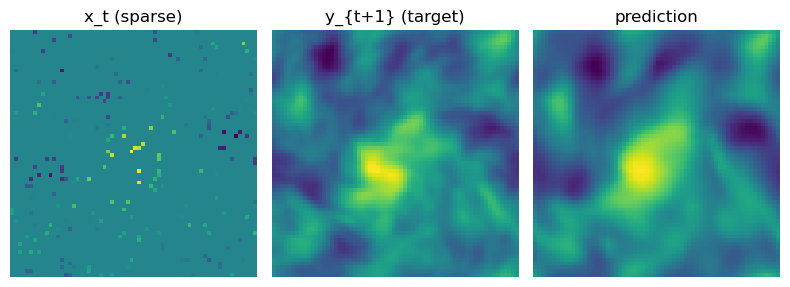

In [2]:
# =======================
# Inference / Validation from saved SCENT checkpoint
# =======================
import os, torch, torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange, repeat
import matplotlib.pyplot as plt
import numpy as np

# -------- config you already use (make sure these match training) --------
CRPS_K = 10
CKPT_PATH = BEST_CKPT_PATH  # or set explicitly if needed
assert os.path.exists(CKPT_PATH), f"Checkpoint not found at {CKPT_PATH}"

# -------- helper: CRPS for ensemble (deterministic ⇒ equals MAE) --------
def crps_from_ensemble(preds_K: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    preds_K: [K, B, N, C]; target: [B, N, C]
    """
    term1 = (preds_K - target.unsqueeze(0)).abs().mean(dim=0)          # [B,N,C]
    diffs = (preds_K.unsqueeze(0) - preds_K.unsqueeze(1)).abs()         # [K,K,B,N,C]
    term2 = 0.5 * diffs.mean(dim=(0, 1))                                # [B,N,C]
    return (term1 - term2).mean()                                       # scalar

# -------- rebuild the *fixed* validation split (same as training script) --------
VAL_SEED   = 12345
TRAIN_SEED = 0
TARGET_TRAIN_PAIRS = 49000  # only used to set tags; does not affect val split

def build_fixed_item_splits(mem, target_train_pairs, val_pairs=4900,
                            train_seed=TRAIN_SEED, val_seed=VAL_SEED):
    num_items_total = len(mem)
    T = int(mem[0].shape[0]); assert T >= 2
    pairs_per_item = T - 1
    items_for_val   = int(np.ceil(val_pairs / pairs_per_item))
    items_for_train = int(np.ceil(target_train_pairs / pairs_per_item))
    rng_val = np.random.default_rng(val_seed)
    val_items = np.sort(rng_val.choice(num_items_total, size=items_for_val, replace=False))
    remaining = np.setdiff1d(np.arange(num_items_total), val_items, assume_unique=True)
    rng_tr = np.random.default_rng(train_seed)
    train_items = np.sort(rng_tr.choice(remaining, size=items_for_train, replace=False))

    def pairs_from_items(items):
        return np.asarray([(int(it), int(t)) for it in items for t in range(T-1)], dtype=np.int64)

    val_ip   = pairs_from_items(val_items)[:val_pairs]
    train_ip = pairs_from_items(train_items)[:target_train_pairs]
    return train_ip, val_ip, T

# if 'mem' not in scope, re-open RaggedMmap
try:
    mem
except NameError:
    from mmap_ninja import RaggedMmap
    mmap_path = os.path.join(BASE_DIR, NAME)
    mem = RaggedMmap(mmap_path, mode="r")

_, val_pairs_fixed, T_chk = build_fixed_item_splits(mem, TARGET_TRAIN_PAIRS)
assert T_chk >= 2

# rebuild val dataset/loader (fixed per-sample mask)
val_ds = NavierStokesSparseNextStep(
    mem, val_pairs_fixed,
    sparsity=SPARSITY,
    normalize=True, mean=MEAN, std=STD,
    to_unit_range=False, seed=42, verbose=False,
    fixed_mask_per_sample=True, mask_seed=0
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
fourier_encoder.load_state_dict(ckpt["fourier_encoder_state_dict"])
model.eval(); fourier_encoder.eval()

# --- use saved queries if available ---
if "pos_queries" in ckpt:
    pos_64_const = ckpt["pos_queries"].to(DEVICE).detach()
    pos_64_const.requires_grad_(False)
else:
    # Fallback (not identical to training; expect metric drift)
    with torch.no_grad():
        pos_64_const = fourier_encoder(coords_64.unsqueeze(0)).squeeze(0).detach()
    pos_64_const.requires_grad_(False)
    print("[warn] checkpoint lacks 'pos_queries'; recomputing queries from the *trained* fourier_encoder. "
          "Metrics may differ from those logged during training.")


# -------- run evaluation --------
val_mse = 0.0; val_mae = 0.0; val_crps = 0.0
with torch.no_grad():
    for x_sparse, y, mask, sid in val_loader:
        x_sparse, y, mask = x_sparse.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
        # prepare inputs
        b = x_sparse.size(0)
        pixels = rearrange(x_sparse, 'b c h w -> b (h w) c')
        pos = repeat(coords_64, 'n d -> b n d', b=b)
        pos_emb = fourier_encoder(pos)
        inp = torch.cat([pixels, pos_emb], dim=-1)
        tgt = rearrange(y, 'b c h w -> b (h w) c')
        queries = repeat(pos_64_const, 'n d -> b n d', b=b)

        pred = model(inp, mask=mask, queries=queries)

        # metrics
        mse_b  = F.mse_loss(pred, tgt, reduction='mean')
        mae_b  = F.l1_loss(pred, tgt, reduction='mean')
        preds_K = pred.unsqueeze(0).repeat(CRPS_K, 1, 1, 1)
        crps_b = crps_from_ensemble(preds_K, tgt)

        # sanity: deterministic ⇒ MAE == CRPS
        if (mae_b - crps_b).abs().item() > 1e-7:
            print(f"[warn] MAE != CRPS (deterministic): "
                  f"mae={mae_b.item():.6g}, crps={crps_b.item():.6g}")

        val_mse  += mse_b.item()
        val_mae  += mae_b.item()
        val_crps += crps_b.item()

avg_val_mse  = val_mse  / max(1, len(val_loader))
avg_val_mae  = val_mae  / max(1, len(val_loader))
avg_val_crps = val_crps / max(1, len(val_loader))

val_rmse_norm = avg_val_mse ** 0.5
val_rmse_unn  = val_rmse_norm * STD
val_mae_unn   = avg_val_mae * STD
val_crps_unn  = avg_val_crps * STD

print(
    f"[INFER] val_MSE={avg_val_mse:.4f} | val_RMSE={val_rmse_norm:.4f} | "
    f"val_MAE={avg_val_mae:.4f} | val_CRPS={avg_val_crps:.4f} | "
    f"unnorm_RMSE={val_rmse_unn:.4f} | unnorm_MAE={val_mae_unn:.4f} | "
    f"unnorm_CRPS={val_crps_unn:.4f}"
)

# -------- quick viz on one sample --------
with torch.no_grad():
    x_sparse, y, mask, _ = next(iter(val_loader))
    x_sparse, y, mask = x_sparse.to(DEVICE)[:1], y.to(DEVICE)[:1], mask.to(DEVICE)[:1]
    pixels = rearrange(x_sparse, 'b c h w -> b (h w) c')
    pos = repeat(coords_64, 'n d -> b n d', b=1)
    pos_emb = fourier_encoder(pos)
    inp = torch.cat([pixels, pos_emb], dim=-1)
    q = repeat(pos_64_const, 'n d -> b n d', b=1)
    pred = model(inp, mask=mask, queries=q)
    pred_img = rearrange(pred[0], '(h w) c -> c h w', h=H, w=W).detach().cpu().numpy()
    tgt_img  = y[0,0].detach().cpu().numpy()

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(x_sparse[0,0].detach().cpu(), cmap='viridis'); plt.title("x_t (sparse)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(tgt_img, cmap='viridis');        plt.title("y_{t+1} (target)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_img[0], cmap='viridis');    plt.title("prediction"); plt.axis('off')
    plt.tight_layout(); plt.show()


In [3]:
## ---------------- MAE & CRPS (deterministic) ----------------
# Shapes: pred,tgt: [B, N, 1]
mae_b = F.l1_loss(pred, tgt, reduction='mean')  # scalar

# Deterministic "ensemble" (K identical copies of pred)
# Use repeat (not expand) to avoid any zero-stride oddities.
preds_K = pred.unsqueeze(0).repeat(CRPS_K, 1, 1, 1)         # [K, B, N, 1]
tgt_K   = tgt.unsqueeze(0).repeat(CRPS_K, 1, 1, 1)          # [K, B, N, 1]

# term1 = E_k |Y_k - y|
term1 = (preds_K - tgt_K).abs().mean(dim=0)                 # [B, N, 1]

# term2 = 0.5 * E_{k,k'} |Y_k - Y_{k'}|
# Pairwise across *ensemble*, not batch. Shape: [K, K, B, N, 1]
diffs = (preds_K.unsqueeze(0) - preds_K.unsqueeze(1)).abs() # [K, K, B, N, 1]
term2 = 0.5 * diffs.mean(dim=(0, 1))                        # [B, N, 1]

crps_b = (term1 - term2).mean()                             # scalar

# --------- Sanity checks (should pass in deterministic eval) ---------
with torch.no_grad():
    # all ensemble members are identical ⇒ pairwise diffs must be 0
    max_pairwise = diffs.max().item()
    if max_pairwise != 0.0:
        print(f"[debug] pairwise max != 0: {max_pairwise:.6g} (should be 0 in deterministic run)")

    delta = (mae_b - crps_b).abs().item()
    if delta > 1e-7:
        print(f"[warn] MAE != CRPS in deterministic run: mae_b={mae_b.item():.6g}, crps_b={crps_b.item():.6g}, |Δ|={delta:.3g}")

# accumulate epoch totals
val_mae  += mae_b.item()
val_crps += crps_b.item()


print(val_mae)
print(val_crps)


9.49246883392334
9.450839281082153


FNO

In [3]:
#------------------------------------------------------------------------------
#
#           Ocean subgrid parameterization using machine learning
#
#                             Graduation work
#
#------------------------------------------------------------------------------
# @ Victor Mangeleer
#
# -----------------
#       Notes
# -----------------
# The authors of this remastered code are :
#
#                    Zongyi Li and Daniel Zhengyu Huang
#
# This code is based on the papers :
#
#                      Factorized Fourier Neural Operators
#                       (https://arxiv.org/abs/2111.13802)
#
#        Fourier Neural Operator for Parametric Partial Differential Equations
#                       (https://arxiv.org/abs/2010.08895)
#
# and comes from:
#
#                   https://github.com/alasdairtran/fourierflow
#
#                 https://github.com/neuraloperator/neuraloperator
#
# -----------------
#     Librairies
# -----------------
#
# --------- Standard ---------
import torch

import numpy               as np
import torch.nn            as nn
import torch.nn.functional as F

from einops import rearrange

# --------- Own ---------

# ----------------------------------------------------------------------------------------------------------
#
#                                               Architecture
#
# ----------------------------------------------------------------------------------------------------------
class FeedForward(nn.Module):
    """
    Documentation
    -------------
    This is a custom multiple linear normalized layer architecture which
    has been slightly revisited to work with nn.DataParallel
    """
    def __init__(self, dim,
                    factor,
            ff_weight_norm,
                  n_layers,
                layer_norm,
                   dropout):
        super().__init__()

        # Saving the total number of layers
        self.nb_layers = n_layers

        # Initialization of the layers
        for i in range(n_layers):

            # Retreiving dimensions
            in_dim  = dim if i == 0            else dim * factor
            out_dim = dim if i == n_layers - 1 else dim * factor

            # Creation of the layer
            l = nn.Sequential(
                    WNLinear(in_dim, out_dim, wnorm = ff_weight_norm),
                    nn.Dropout(dropout),
                    nn.ReLU(inplace = True) if i < n_layers - 1 else nn.Identity(),
                    nn.LayerNorm(out_dim) if layer_norm and i == n_layers - 1 else nn.Identity(),
            )

            # Adding the layer to the module
            setattr(self, f'layer_{i}', l)

    def forward(self, x):

        for l in range(self.nb_layers):

            # Retreiving the current layer
            layer = getattr(self, f'layer_{l}')

            # Forward pass
            x = layer(x)

        return x
import copy
import math

from torch.nn.utils             import weight_norm
from torch.nn.utils.weight_norm import WeightNorm

# ----------------------------------------------------------------------------------------------------------
#
#                                               Architectures
#
# ----------------------------------------------------------------------------------------------------------
class GehringLinear(nn.Linear):
    """
    Documentation
    -------------
    A linear layer with Gehring initialization and weight normalization.
    """
    def __init__(self, in_features,
                      out_features,
                       dropout = 0,
                       bias = True,
                weight_norm = True):

        self.dropout     = dropout
        self.weight_norm = weight_norm

        super().__init__(in_features, out_features, bias)

    def reset_parameters(self):
        """
        Documentation
        -------------
        1 - One problem with initialization from the uniform distribution is that
            the distribution of the outputs has a variance that grows with the
            number of inputs. It turns out that we can normalize the variance of
            each neuron’s output to 1 by scaling its weight vector by the square
            root of its fan-in (i.e. its number of inputs). Dropout further
            increases the variance of each input, so we need to scale down std.

                            See A.3. in Gehring et al (2017):

                            https://arxiv.org/pdf/1705.03122

        2 - Weight normalization is a reparameterization that decouples the
            magnitude of a weight tensor from its direction.

                              See Salimans and Kingma (2016):

                              https://arxiv.org/abs/1602.07868.
        """
        # Compute standard deviation of objective distribution for the weights
        std = math.sqrt((1 - self.dropout) / self.in_features)

        # Normalization
        self.weight.data.normal_(mean = 0, std = std)

        if self.bias is not None:
            self.bias.data.fill_(0)

        if self.weight_norm:
            nn.utils.weight_norm(self)


class WNLinear(nn.Linear):
    """
    Documentation
    -------------
    Normalized weights linear layer !
    """
    def __init__(self, in_features: int,
                      out_features: int,
                      bias: bool = True,
                          device = None,
                           dtype = None,
                           wnorm = False):

        super().__init__(in_features = in_features,
                        out_features = out_features,
                                bias = bias,
                              device = device,
                               dtype = dtype)

        # Normalization of the weights
        if wnorm:
            weight_norm(self)

        # Fixing the deep copy problem
        self._fix_weight_norm_deepcopy()

    def _fix_weight_norm_deepcopy(self):
        """
        Documentation
        -------------
        Fix bug where deepcopy doesn't work with weightnorm. Taken from:

          https://github.com/pytorch/pytorch/issues/28594#issuecomment-679534348

        """

        orig_deepcopy = getattr(self, '__deepcopy__', None)

        def __deepcopy__(self, memo):

            # Save and delete all weightnorm weights on self
            weights = {}
            for hook in self._forward_pre_hooks.values():
                if isinstance(hook, WeightNorm):
                    weights[hook.name] = getattr(self, hook.name)
                    delattr(self, hook.name)

            # Remove this deepcopy method, restoring the object's original one if necessary
            __deepcopy__ = self.__deepcopy__
            if orig_deepcopy:
                self.__deepcopy__ = orig_deepcopy
            else:
                del self.__deepcopy__

            # Actually do the copy
            result = copy.deepcopy(self)

            # Restore weights and method on self
            for name, value in weights.items():
                setattr(self, name, value)
            self.__deepcopy__ = __deepcopy__
            return result

        # bind __deepcopy__ to the weightnorm'd layer
        self.__deepcopy__ = __deepcopy__.__get__(self, self.__class__)

# -----------------------------------------------------
#                  Spectral Convolution
# -----------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self,  in_dim,
                       out_dim,
                       modes_x,
                       modes_y,
                       mode = "full",
                n_ff_layers = 2,
                     factor = 4,
                    dropout = 0.1,
            ff_weight_norm  = True,
                  use_fork  = False,
               layer_norm   = False,
           fourier_weight_x = None,
           fourier_weight_y = None,
                forecast_ff = None,
                backcast_ff = None):
        super().__init__()
        """
        Documentation
        -------------
        - in_dim         : input dimension
        - out_dim        : output dimension
        - modes_x        : modes to keep along the x-direction
        - modes_y        : modes to keep along the y-direction
        - fourier_weight : set of weights shared across layers (x and y directions)
        - mode           :
                            - "full"       : FFT + WEIGHTED MODE SELECTION + IFFT + FEEDFORWARD
                            - "filtering"  : FFT + FILTERING + IFFT + FEEDFORWARD
                            - "no-fourier" : FeedForward

        --- FEEDFORWARD ---
        - n_ff_layers    : number of layers
        - factor         : size amplification factor
        - dropout        : probability of not using a neuron
        - ff_weight_norm : normalization of the weights
        - backcast_ff    : neural network used
        - layer_norm     : add a layer normalization layer after the activation functions

        --- FORECASTING ---
        - use_fork    : add an additional head after IFFT
        - forecast_ff : neural network used
        """
        # Security
        assert mode in ['no-fourier', 'full', 'filtering'], \
            "(FFNO2D - Spectral convolution) mode should be one of use-fourier or no-fourier"

        assert modes_x[1] - modes_x[0] > 0, \
            "(FFNO2D - Spectral convolution) modes in x-direction should be m1 < m2"

        assert modes_y[1] - modes_y[0] > 0, \
            "(FFNO2D - Spectral convolution) modes in x-direction should be m1 < m2"

        assert in_dim - out_dim == 0, \
            "(FFNO2D - Spectral convolution) input and output dimension must be equal"

        # Initialization
        self.in_dim           = in_dim
        self.out_dim          = out_dim
        self.modes_x          = modes_x
        self.modes_y          = modes_y
        self.mode             = mode
        self.use_fork         = use_fork
        self.fourier_weight_x = fourier_weight_x
        self.fourier_weight_y = fourier_weight_y

        # Shared set of weights
        if self.fourier_weight_x is None:

            # Initialization using Xavier Normal technique
            for i, n_modes in enumerate([modes_x[1] - modes_x[0], modes_y[1] - modes_y[0]]):

                # Performing normalization
                weight = torch.FloatTensor(in_dim, out_dim, n_modes, 2)
                param  = nn.Parameter(weight)
                nn.init.xavier_normal_(param)

                # Saving weights
                if i == 0:
                    self.fourier_weight_x = param
                else:
                    self.fourier_weight_y = param

        # Additionnal network at the head of the FFNO block
        if use_fork:
            self.forecast_ff = forecast_ff
            if not self.forecast_ff:
                self.forecast_ff = FeedForward(out_dim, factor, ff_weight_norm, n_ff_layers, layer_norm, dropout)

        # Head of the FFNO to sum x and y after IFFT
        self.backcast_ff = backcast_ff
        if not self.backcast_ff:
            self.backcast_ff = FeedForward(out_dim, factor, ff_weight_norm, n_ff_layers, layer_norm, dropout)

    def forward(self, x):
        """
        Documentation
        -------------
        - Forward pass of the whole FFNO block
        """
        # Going through Fourier Domain
        if self.mode != 'no-fourier':
            x = self.forward_fourier(x)

        # Concatenation of x and y after IFFT
        b = self.backcast_ff(x)

        # Additionnal separated head after coming back from Fourier Space
        f = self.forecast_ff(x) if self.use_fork else None

        return b, f

    def forward_fourier(self, x):
        """
        Documentation
        -------------
        - Forward pass in the Fourier domain
        """
        # Re-shaping (1)
        x = rearrange(x, 'b m n i -> b i m n')

        # Retreiving dimensions
        B, I, M, N = x.shape

        # ----------------------------------------
        #                Dimension Y
        # ----------------------------------------
        # Computing Fourier Transform (y-direction)
        f_transform = torch.fft.rfft(x, dim = -1, norm = 'ortho')

        # Stores the results after playing with modes
        out_ft = f_transform.new_zeros(B, I, M, N // 2 + 1)

        # ------------- CASE 1 - Weightening -------------
        if self.mode == 'full':
            out_ft[:, :, :, self.modes_y[0]:self.modes_y[1]] = torch.einsum("b i x y, i o y -> b o x y",
                f_transform[:, :, :, self.modes_y[0]:self.modes_y[1]], torch.view_as_complex(self.fourier_weight_y))

        # ------------- CASE 2 - Low Pass Filtering -------------
        elif self.mode == 'filtering':
            out_ft[:, :, :, self.modes_y[0]:self.modes_y[1]] = f_transform[:, :, :, self.modes_y[0]:self.modes_y[1]]

        # Coming back to original space
        xy = torch.fft.irfft(out_ft, n = N, dim = -1, norm = 'ortho')

        # ----------------------------------------
        #                Dimension X
        # ----------------------------------------
         # Computing Fourier Transform (x-direction)
        f_transform = torch.fft.rfft(x, dim = -2, norm = 'ortho')

        # Stores the results after playing with modes
        out_ft = f_transform.new_zeros(B, I, M // 2 + 1, N)

        # ------------- CASE 1 - Weightening -------------
        if self.mode == 'full':
            out_ft[:, :, self.modes_x[0]:self.modes_x[1], :] = torch.einsum("bixy,iox->boxy",
                f_transform[:, :, self.modes_x[0]:self.modes_x[1], :], torch.view_as_complex(self.fourier_weight_x))

        # ------------- CASE 2 - Low Pass Filtering -------------
        elif self.mode == 'filtering':
            out_ft[:, :, self.modes_x[0]:self.modes_x[1], :] = f_transform[:, :, self.modes_x[0]:self.modes_x[1], :]

        # Coming back to original space
        xx = torch.fft.irfft(out_ft, n = M, dim = -2, norm='ortho')

        # ----------------------------------------
        #                Combining
        # ----------------------------------------
        x = xx + xy
        x = rearrange(x, 'b i m n -> b m n i')

        return x

# -----------------------------------------------------
#            Factorized Fourier Neural Operator
# -----------------------------------------------------
class FFNO(nn.Module):
    def __init__(self, input_dim,
                      output_dim,
                         modes_x,
                         modes_y,
                           width,
                    n_layers = 4,
                      factor = 4,
                 n_ff_layers = 2,
             share_weight = True,
           ff_weight_norm = True,
             layer_norm  = False):
        super().__init__()
        """
        Documentation
        -------------
        Slightly modified FFNO operator now working as a pass-band filter and it can be parralelized !

        - in_dim         : input dimension
        - out_dim        : output dimension
        - modes_x        : modes to keep along the x-direction
        - modes_y        : modes to keep along the y-direction
        - width          : space size to which lift the input
        - n_layers       : number of convolution inside FFNO
        - fourier_weight : set of weights shared across layers
        - share_weight   : determine wether or not weights are shared across layers

        --- FEEDFORWARD ---
        - n_ff_layers    : number of layers
        - factor         : size amplification factor
        - ff_weight_norm : normalization of the weights
        - layer_norm     : add a layer normalization layer after the activation functions
        """
        # Initialization
        self.padding   = 8
        self.modes_x   = modes_x
        self.modes_y   = modes_y
        self.width     = width
        self.input_dim = input_dim
        self.n_layers  = n_layers

        # Security
        assert len(modes_x) == 2 & len(modes_y) == 2, \
            "(FFNO2D V3 - Module) modes should be a 2D tuple containing the min and max modes defining the pass-band filter"

        # ------ Lifting layer ------
        self.in_proj = WNLinear(input_dim + 2, self.width, wnorm = ff_weight_norm)

        # --------- Weights ---------
        self.fourier_weight_x = None
        self.fourier_weight_y = None

        if share_weight:

            # Initialization using Xavier Normal technique
            for i, n_modes in enumerate([modes_x[1] - modes_x[0], modes_y[1] - modes_y[0]]):

                # Performing normalization
                weight = torch.FloatTensor(width, width, n_modes, 2)
                param = nn.Parameter(weight)
                nn.init.xavier_normal_(param)

                # Saving weights
                if i == 0:
                    self.fourier_weight_x = param
                else:
                    self.fourier_weight_y = param


        # --------- Spectral Convolutions ---------
        for i in range(n_layers):

            # Creation of the layer
            spec_layer = SpectralConv2d(in_dim           = width,
                                        out_dim          = width,
                                        modes_x          = modes_x,
                                        modes_y          = modes_y,
                                        forecast_ff      = None,
                                        backcast_ff      = None,
                                        fourier_weight_x = self.fourier_weight_x,
                                        fourier_weight_y = self.fourier_weight_y,
                                        factor           = factor,
                                        ff_weight_norm   = ff_weight_norm,
                                        n_ff_layers      = n_ff_layers,
                                        layer_norm       = layer_norm,
                                        use_fork         = False,
                                        dropout          = 0.1,
                                        mode             = 'full')

            # Saving spectral layer
            setattr(self, f'ffno_spectral_layer_{i}', spec_layer)

        # --------- Projection Layer ---------
        self.out = nn.Sequential(
            WNLinear(self.width, 128, wnorm = ff_weight_norm),
            WNLinear(128, output_dim, wnorm = ff_weight_norm))

    def forward(self, x):
        """
        Documentation
        -------------
        Forwarding throughout the whole FFNO block

        """
        # Creation of grid containing x and y coordinates
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim = -1)               # [B, X, Y, 4]

        # Lifting the input
        x = self.in_proj(x)                              # [B, X, Y, H]
        x = x.permute(0, 3, 1, 2)                        # [B, H, X, Y]
        x = F.pad(x, [0, self.padding, 0, self.padding]) # [B, H, X, Y]
        x = x.permute(0, 2, 3, 1)                        # [B, X, Y, H]

        # Performing Spectral Convolution
        for i in range(self.n_layers):

            # Retreiving the layer
            layer = getattr(self, f'ffno_spectral_layer_{i}')

            # Convolution
            b, _ = layer(x)

            # Skip connection
            x = x + b

        # Removing useless dimensions
        b = b[..., :-self.padding, :-self.padding, :]

        # Projection
        output = self.out(b)

        return output

    def get_grid(self, shape, device):
        """
        Documentation
        -------------
        Creation of a grid containing coordinates of cells (used by Fourier Transform)
        """
        # Retreiving dimensions
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]

        # X-direction
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype = torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])

        # Y-direction
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype = torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])

        return torch.cat((gridx, gridy), dim = -1).to(device)

In [8]:
# %% [markdown]
# FFNO2D for Navier–Stokes next-step forecasting (5% sparsity)
# - Loads RaggedMmap -> builds (item_idx, t) pairs
# - Sparse conditioning (x_t masked at 5% visible)
# - FFNO2D (uses internal coord grid, no PE module)
# - Prints val MSE/RMSE/MAE (normalized) + unnormalized RMSE/MAE
# - Saves best checkpoint to NavierStokesCheckpoints/FFNO/<dataset_tag>/<sparsity_tag>/best.pt

# %%
import os, ssl, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from einops import rearrange
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# optional: clusters that block certs
ssl._create_default_https_context = ssl._create_unverified_context

# Requires: pip install mmap-ninja
from mmap_ninja import RaggedMmap

# -----------------------
# Config (EDIT THESE)
# -----------------------
DEVICE   = "cuda:1" if torch.cuda.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
H = W    = 64
CHANNELS = 1
BATCH_SIZE = 64
EPOCHS     = 50
LR         = 2e-4
SPARSITY   = 0.02          # 5% visible
MEAN, STD  = 0.0, 2.4036

# FFNO hyperparams (safe defaults for 64x64 + pad=8 => 72 -> N//2+1=37)
FFNO_WIDTH     = 64
FFNO_LAYERS    = 4
FFNO_FACTOR    = 4
FFNO_NFF       = 2
FFNO_SHARE_W   = True
FFNO_MODES_X   = (0, 24)
FFNO_MODES_Y   = (0, 24)

# memmap dir (same style as SCENT)
BASE_DIR = "/pscratch/sd/d/dpark1/NSData"  # <-- EDIT
NAME     = "100k"                          # <-- EDIT
mmap_path = os.path.join(BASE_DIR, NAME)

# -----------------------
# Helpers
# -----------------------
def build_index_pairs(mem, max_items=1000, seed=0):
    rng = np.random.default_rng(seed)
    num_items_total = len(mem)
    pick = min(max_items, num_items_total)
    chosen_item_idxs = np.sort(rng.choice(num_items_total, size=pick, replace=False))
    # assume fixed T
    T = int(mem[int(chosen_item_idxs[0])].shape[0])
    assert T >= 2, "Need T>=2"
    pairs = [(int(it), int(t)) for it in chosen_item_idxs for t in range(T-1)]
    pairs = np.asarray(pairs, dtype=np.int64)
    print(f"Using {len(chosen_item_idxs)} items; built {len(pairs)} (t→t+1) pairs with T={T}.")
    return pairs, T

# -----------------------
# Dataset (same as SCENT pipeline, we just ignore the mask downstream)
# -----------------------
class NavierStokesSparseNextStep(Dataset):
    """
    Returns:
      x_sparse: (1,H,W)  - input at time t with sparsity applied
      y      : (1,H,W)   - target at time t+1 (dense)
      mask   : (H,W)     - boolean mask (True where x_t is visible)
      sample_id: int64   - stable id = item_idx * T + t
    """
    def __init__(self, memmap, index_pairs, sparsity=0.05,
                 normalize=True, mean=0.0, std=1.0,
                 to_unit_range=False, seed=42, verbose=True):
        self.mem = memmap
        self.index_pairs = np.asarray(index_pairs, dtype=np.int64)
        self.normalize = bool(normalize)
        self.mean = float(mean)
        self.std  = float(std)
        self.to_unit_range = bool(to_unit_range)
        self.sparsity = float(sparsity)
        self.rng = np.random.default_rng(seed)
        it0 = int(self.index_pairs[0, 0])
        self.T = int(self.mem[it0].shape[0])
        if verbose:
            print(f"[NS Sparse] pairs={len(self.index_pairs)}, T={self.T}, sparsity={self.sparsity}, "
                  f"normalize={self.normalize}, unit_range={self.to_unit_range}")

    def __len__(self): return len(self.index_pairs)
    def _z(self, a): return (a - self.mean) / self.std
    def _unit(self, a): return np.tanh(a)

    def __getitem__(self, i):
        item_idx, t = map(int, self.index_pairs[i])
        seq = self.mem[item_idx]  # (T,H,W)
        x = np.asarray(seq[t],   dtype=np.float32)
        y = np.asarray(seq[t+1], dtype=np.float32)
        if self.normalize:
            x = self._z(x); y = self._z(y)
        if self.to_unit_range:
            x = self._unit(x); y = self._unit(y)
        # apply sparsity to x
        mask = self.rng.random(x.shape) < self.sparsity
        x_sparse = x * mask.astype(np.float32)

        x_sparse = torch.from_numpy(x_sparse[None, ...])  # (1,H,W)
        y        = torch.from_numpy(y[None, ...])         # (1,H,W)
        mask     = torch.from_numpy(mask.astype(np.bool_))# (H,W)
        sample_id = torch.tensor(item_idx * self.T + t, dtype=torch.long)
        return x_sparse, y, mask, sample_id

# -----------------------
# Load memmap + build pairs
# -----------------------
mem = RaggedMmap(mmap_path, mode="r")  # each item -> (T,H,W)
index_pairs, T = build_index_pairs(mem, max_items=1000, seed=0)

# -----------------------
# Dynamic checkpoint path (dataset + sparsity tags)
# -----------------------
num_pairs = len(index_pairs)
if num_pairs == 49000:
    dataset_tag = "full"
elif num_pairs == 4900:
    dataset_tag = "10pct"
else:
    dataset_tag = f"{num_pairs}pairs"
sparsity_tag = f"{int(round(SPARSITY*100))}pct"

CKPT_ROOT = os.path.join("NavierStokesCheckpoints", "FFNO", dataset_tag, sparsity_tag)
os.makedirs(CKPT_ROOT, exist_ok=True)
BEST_CKPT_PATH = os.path.join(CKPT_ROOT, "best.pt")
print(f"[ckpt dir] {CKPT_ROOT}")

# -----------------------
# Datasets & Loaders
# -----------------------
full_ds = NavierStokesSparseNextStep(
    mem, index_pairs,
    sparsity=SPARSITY,
    normalize=True, mean=MEAN, std=STD,
    to_unit_range=False, seed=42, verbose=True
)
val_len = int(0.1 * len(full_ds))
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(0))
pin = ("cuda" in str(DEVICE))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin)

# -----------------------
# Model, Opt, Sched
# -----------------------
# Assumes FFNO class is already defined in the notebook
model = FFNO(
    input_dim = 1,
    output_dim= 1,
    modes_x   = FFNO_MODES_X,
    modes_y   = FFNO_MODES_Y,
    width     = FFNO_WIDTH,
    n_layers  = FFNO_LAYERS,
    factor    = FFNO_FACTOR,
    n_ff_layers = FFNO_NFF,
    share_weight = FFNO_SHARE_W,
    ff_weight_norm = True,
    layer_norm = False
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS * len(train_loader)))
loss_fn = nn.MSELoss()

print(f"Training on {DEVICE}. Params ~ {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# -----------------------
# Train / Validate (+ checkpoint on best val_MSE)
# -----------------------
best_val_mse = float("inf")
best_val_mae = float("inf")
best_epoch   = -1

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)
    for x_sparse, y, mask, sid in pbar:
        # FFNO expects [B, X, Y, C]
        x_ffno = rearrange(x_sparse.to(DEVICE), 'b c h w -> b h w c')  # (B,H,W,1)
        y_ffno = rearrange(y.to(DEVICE),        'b c h w -> b h w c')  # (B,H,W,1)

        optimizer.zero_grad(set_to_none=True)
        pred = model(x_ffno)                       # (B,H,W,1)
        loss = loss_fn(pred, y_ffno)
        loss.backward(); optimizer.step(); scheduler.step()

        running_train += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")
    avg_train = running_train / max(1, len(train_loader))

    # ---- Validate ----
    model.eval()
    val_mse = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for x_sparse, y, mask, sid in val_loader:
            x_ffno = rearrange(x_sparse.to(DEVICE), 'b c h w -> b h w c')
            y_ffno = rearrange(y.to(DEVICE),        'b c h w -> b h w c')
            pred = model(x_ffno)
            val_mse += F.mse_loss(pred, y_ffno, reduction='mean').item()
            val_mae += F.l1_loss(pred, y_ffno, reduction='mean').item()

    avg_val_mse = val_mse / max(1, len(val_loader))
    avg_val_mae = val_mae / max(1, len(val_loader))

    # Extra metrics (normalized + unnormalized)
    val_rmse_norm = avg_val_mse ** 0.5
    val_rmse_unn  = val_rmse_norm * STD
    val_mae_unn   = avg_val_mae * STD

    # ---- Checkpoint on best (by MSE) ----
    if avg_val_mse < best_val_mse:
        best_val_mse = avg_val_mse
        best_val_mae = avg_val_mae
        best_epoch   = epoch + 1

        torch.save({
            "epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_val_mse": best_val_mse,
            "best_val_mae": best_val_mae,
            "tags": {"dataset": dataset_tag, "sparsity": sparsity_tag},
            "config": {
                "H": H, "W": W, "SPARSITY": SPARSITY,
                "LR": LR, "BATCH_SIZE": BATCH_SIZE,
                "FFNO": {
                    "modes_x": FFNO_MODES_X, "modes_y": FFNO_MODES_Y,
                    "width": FFNO_WIDTH, "n_layers": FFNO_LAYERS,
                    "factor": FFNO_FACTOR, "n_ff_layers": FFNO_NFF,
                    "share_weight": FFNO_SHARE_W
                }
            }
        }, BEST_CKPT_PATH)
        print(
            f"  ✓ New best! Saved to {BEST_CKPT_PATH} (epoch {best_epoch}, "
            f"val_MSE={best_val_mse:.4f}, val_RMSE={val_rmse_norm:.4f}, val_MAE={best_val_mae:.4f}, "
            f"unnorm_RMSE={val_rmse_unn:.4f}, unnorm_MAE={val_mae_unn:.4f})"
        )

    print(
        f"[Epoch {epoch+1}] train={avg_train:.4f} | "
        f"val_MSE={avg_val_mse:.4f} | val_RMSE={val_rmse_norm:.4f} | val_MAE={avg_val_mae:.4f} | "
        f"unnorm_RMSE={val_rmse_unn:.4f} | unnorm_MAE={val_mae_unn:.4f} | "
        f"best_MSE={best_val_mse:.4f} @ epoch {best_epoch} | "
        f"lr={scheduler.get_last_lr()[0]:.2e}"
    )

# -----------------------
# Quick sanity viz
# -----------------------
with torch.no_grad():
    x_sparse, y, mask, _ = next(iter(val_loader))
    x_ffno = rearrange(x_sparse.to(DEVICE)[:1], 'b c h w -> b h w c')
    y_ffno = rearrange(y.to(DEVICE)[:1],        'b c h w -> b h w c')
    pred = model(x_ffno)
    pred_img = pred[0, ..., 0].detach().cpu().numpy()
    tgt_img  = y_ffno[0, ..., 0].detach().cpu().numpy()
    inp_img  = x_ffno[0, ..., 0].detach().cpu().numpy()

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(inp_img, cmap='viridis'); plt.title("x_t (sparse)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(tgt_img, cmap='viridis'); plt.title("y_{t+1} (target)"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_img, cmap='viridis'); plt.title("prediction"); plt.axis('off')
    plt.tight_layout(); plt.show()


Using 1000 items; built 49000 (t→t+1) pairs with T=50.
[ckpt dir] NavierStokesCheckpoints/FFNO/full/2pct
[NS Sparse] pairs=49000, T=50, sparsity=0.02, normalize=True, unit_range=False
Training on cuda:1. Params ~ 0.54M


Epoch 1/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 1, val_MSE=1.1480, val_RMSE=1.0714, val_MAE=0.7984, unnorm_RMSE=2.5753, unnorm_MAE=1.9190)
[Epoch 1] train=1.2781 | val_MSE=1.1480 | val_RMSE=1.0714 | val_MAE=0.7984 | unnorm_RMSE=2.5753 | unnorm_MAE=1.9190 | best_MSE=1.1480 @ epoch 1 | lr=2.00e-04


Epoch 2/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 20, val_MSE=0.7803, val_RMSE=0.8833, val_MAE=0.6390, unnorm_RMSE=2.1232, unnorm_MAE=1.5358)
[Epoch 20] train=0.8092 | val_MSE=0.7803 | val_RMSE=0.8833 | val_MAE=0.6390 | unnorm_RMSE=2.1232 | unnorm_MAE=1.5358 | best_MSE=0.7803 @ epoch 20 | lr=1.31e-04


Epoch 21/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 21, val_MSE=0.7803, val_RMSE=0.8833, val_MAE=0.6391, unnorm_RMSE=2.1232, unnorm_MAE=1.5362)
[Epoch 21] train=0.8059 | val_MSE=0.7803 | val_RMSE=0.8833 | val_MAE=0.6391 | unnorm_RMSE=2.1232 | unnorm_MAE=1.5362 | best_MSE=0.7803 @ epoch 21 | lr=1.25e-04


Epoch 22/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

[Epoch 22] train=0.8029 | val_MSE=0.7835 | val_RMSE=0.8851 | val_MAE=0.6401 | unnorm_RMSE=2.1275 | unnorm_MAE=1.5386 | best_MSE=0.7803 @ epoch 21 | lr=1.19e-04


Epoch 23/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 23, val_MSE=0.7683, val_RMSE=0.8765, val_MAE=0.6342, unnorm_RMSE=2.1068, unnorm_MAE=1.5243)
[Epoch 23] train=0.7988 | val_MSE=0.7683 | val_RMSE=0.8765 | val_MAE=0.6342 | unnorm_RMSE=2.1068 | unnorm_MAE=1.5243 | best_MSE=0.7683 @ epoch 23 | lr=1.13e-04


Epoch 24/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 24, val_MSE=0.7678, val_RMSE=0.8763, val_MAE=0.6328, unnorm_RMSE=2.1062, unnorm_MAE=1.5209)
[Epoch 24] train=0.7952 | val_MSE=0.7678 | val_RMSE=0.8763 | val_MAE=0.6328 | unnorm_RMSE=2.1062 | unnorm_MAE=1.5209 | best_MSE=0.7678 @ epoch 24 | lr=1.06e-04


Epoch 25/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

[Epoch 25] train=0.7943 | val_MSE=0.7693 | val_RMSE=0.8771 | val_MAE=0.6335 | unnorm_RMSE=2.1082 | unnorm_MAE=1.5226 | best_MSE=0.7678 @ epoch 24 | lr=1.00e-04


Epoch 26/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 26, val_MSE=0.7626, val_RMSE=0.8733, val_MAE=0.6299, unnorm_RMSE=2.0990, unnorm_MAE=1.5140)
[Epoch 26] train=0.7912 | val_MSE=0.7626 | val_RMSE=0.8733 | val_MAE=0.6299 | unnorm_RMSE=2.0990 | unnorm_MAE=1.5140 | best_MSE=0.7626 @ epoch 26 | lr=9.37e-05


Epoch 27/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 27, val_MSE=0.7577, val_RMSE=0.8704, val_MAE=0.6281, unnorm_RMSE=2.0922, unnorm_MAE=1.5098)
[Epoch 27] train=0.7885 | val_MSE=0.7577 | val_RMSE=0.8704 | val_MAE=0.6281 | unnorm_RMSE=2.0922 | unnorm_MAE=1.5098 | best_MSE=0.7577 @ epoch 27 | lr=8.75e-05


Epoch 28/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 28, val_MSE=0.7569, val_RMSE=0.8700, val_MAE=0.6275, unnorm_RMSE=2.0911, unnorm_MAE=1.5083)
[Epoch 28] train=0.7879 | val_MSE=0.7569 | val_RMSE=0.8700 | val_MAE=0.6275 | unnorm_RMSE=2.0911 | unnorm_MAE=1.5083 | best_MSE=0.7569 @ epoch 28 | lr=8.13e-05


Epoch 29/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

[Epoch 29] train=0.7841 | val_MSE=0.7580 | val_RMSE=0.8706 | val_MAE=0.6280 | unnorm_RMSE=2.0926 | unnorm_MAE=1.5094 | best_MSE=0.7569 @ epoch 28 | lr=7.51e-05


Epoch 30/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 30, val_MSE=0.7486, val_RMSE=0.8652, val_MAE=0.6244, unnorm_RMSE=2.0796, unnorm_MAE=1.5009)
[Epoch 30] train=0.7822 | val_MSE=0.7486 | val_RMSE=0.8652 | val_MAE=0.6244 | unnorm_RMSE=2.0796 | unnorm_MAE=1.5009 | best_MSE=0.7486 @ epoch 30 | lr=6.91e-05


Epoch 31/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

[Epoch 31] train=0.7802 | val_MSE=0.7502 | val_RMSE=0.8661 | val_MAE=0.6249 | unnorm_RMSE=2.0819 | unnorm_MAE=1.5019 | best_MSE=0.7486 @ epoch 30 | lr=6.32e-05


Epoch 32/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  ✓ New best! Saved to NavierStokesCheckpoints/FFNO/full/2pct/best.pt (epoch 45, val_MSE=0.7371, val_RMSE=0.8586, val_MAE=0.6186, unnorm_RMSE=2.0636, unnorm_MAE=1.4870)
[Epoch 45] train=0.7679 | val_MSE=0.7371 | val_RMSE=0.8586 | val_MAE=0.6186 | unnorm_RMSE=2.0636 | unnorm_MAE=1.4870 | best_MSE=0.7371 @ epoch 45 | lr=4.89e-06


Epoch 46/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

[Epoch 46] train=0.7686 | val_MSE=0.7405 | val_RMSE=0.8605 | val_MAE=0.6195 | unnorm_RMSE=2.0683 | unnorm_MAE=1.4890 | best_MSE=0.7371 @ epoch 45 | lr=3.14e-06


Epoch 47/50 [train]:   0%|          | 0/690 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
# %% [markdown]
# SCENT (PerceiverIO) — Inference on validation split
# - Rebuilds model + Fourier encoder exactly as in training cell
# - Loads NavierStokesCheckpoints/SCENT/<dataset_tag>/<sparsity_tag>/best.pt
# - Reports val MSE / RMSE / MAE (normalized) + unnormalized RMSE / MAE

# %%
import os, ssl, numpy as np
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from einops import rearrange, repeat
from tqdm.auto import tqdm

ssl._create_default_https_context = ssl._create_unverified_context
from mmap_ninja import RaggedMmap

# -----------------------
# MUST MATCH TRAINING CONFIG
# -----------------------
DEVICE   = "cuda:1" if torch.cuda.is_available() else "cpu"
H = W    = 64
CHANNELS = 1
BATCH_SIZE = 64
SPARSITY   = 0.2          # <-- keep same as training run you want to evaluate
MEAN, STD  = 0.0, 2.4036

FOURIER_MAPPING_SIZE = 96
POS_EMBED_DIM = FOURIER_MAPPING_SIZE * 2
INPUT_DIM   = CHANNELS + POS_EMBED_DIM
QUERIES_DIM = POS_EMBED_DIM
LOGITS_DIM  = CHANNELS

# Memmap location (same as training)
BASE_DIR = "/pscratch/sd/d/dpark1/NSData"   # <-- EDIT if needed
NAME     = "100k"                           # <-- EDIT if needed
mmap_path = os.path.join(BASE_DIR, NAME)

# -----------------------
# Helper fns (same as training)
# -----------------------
def create_coordinate_grid(h, w, device):
    yy, xx = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, device=device),
        torch.linspace(-1.0, 1.0, w, device=device),
        indexing='ij'
    )
    return rearrange(torch.stack([yy, xx], dim=-1), 'h w c -> (h w) c')

def build_index_pairs(mem, max_items=100, seed=0):
    rng = np.random.default_rng(seed)
    num_items_total = len(mem)
    pick = min(max_items, num_items_total)
    chosen_item_idxs = np.sort(rng.choice(num_items_total, size=pick, replace=False))
    T = int(mem[int(chosen_item_idxs[0])].shape[0])
    assert T >= 2, "Need T>=2"
    pairs = [(int(it), int(t)) for it in chosen_item_idxs for t in range(T-1)]
    pairs = np.asarray(pairs, dtype=np.int64)
    print(f"Using {len(chosen_item_idxs)} items; built {len(pairs)} (t→t+1) pairs with T={T}.")
    return pairs, T

def exists(x): return x is not None
def default(val, d): return val if exists(val) else d

# Dataset (same as training)
class NavierStokesSparseNextStep(torch.utils.data.Dataset):
    def __init__(self, memmap, index_pairs, sparsity=0.05,
                 normalize=True, mean=0.0, std=1.0,
                 to_unit_range=False, seed=42, verbose=True):
        self.mem = memmap
        self.index_pairs = np.asarray(index_pairs, dtype=np.int64)
        self.normalize = bool(normalize)
        self.mean = float(mean); self.std = float(std)
        self.to_unit_range = bool(to_unit_range)
        self.sparsity = float(sparsity)
        self.rng = np.random.default_rng(seed)
        it0 = int(self.index_pairs[0, 0])
        self.T = int(self.mem[it0].shape[0])
        if verbose:
            print(f"[NS Sparse] pairs={len(self.index_pairs)}, T={self.T}, sparsity={self.sparsity}, "
                  f"normalize={self.normalize}, unit_range={self.to_unit_range}")
    def __len__(self): return len(self.index_pairs)
    def _z(self, a): return (a - self.mean) / self.std
    def _unit(self, a): return np.tanh(a)
    def __getitem__(self, i):
        item_idx, t = map(int, self.index_pairs[i])
        seq = self.mem[item_idx]
        x = np.asarray(seq[t],   dtype=np.float32)
        y = np.asarray(seq[t+1], dtype=np.float32)
        if self.normalize:
            x = self._z(x); y = self._z(y)
        if self.to_unit_range:
            x = self._unit(x); y = self._unit(y)
        mask = self.rng.random(x.shape) < self.sparsity
        x_sparse = x * mask.astype(np.float32)
        x_sparse = torch.from_numpy(x_sparse[None, ...])  # (1,H,W)
        y        = torch.from_numpy(y[None, ...])         # (1,H,W)
        mask     = torch.from_numpy(mask.astype(np.bool_))# (H,W)
        sample_id = torch.tensor(item_idx * self.T + t, dtype=torch.long)
        return x_sparse, y, mask, sample_id

# PerceiverIO (same as training)
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat

class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim=None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None
    def forward(self, x, **kwargs):
        x = self.norm(x)
        if exists(self.norm_context):
            kwargs.update(context=self.norm_context(kwargs['context']))
        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x): return self.net(x)

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)
    def forward(self, x, context=None, mask=None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))
        sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale
        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg)
        attn = sim.softmax(dim=-1)
        out = torch.einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)

def cache_fn(f):
    cache = None
    def cached_fn(*args, _cache=True, **kwargs):
        nonlocal cache
        if not _cache: return f(*args, **kwargs)
        if cache is not None: return cache
        cache = f(*args, **kwargs); return cache
    return cached_fn

class PerceiverIO(nn.Module):
    def __init__(self, *, depth, dim, queries_dim, logits_dim=None,
                 num_latents=256, latent_dim=512,
                 cross_heads=1, latent_heads=8,
                 cross_dim_head=64, latent_dim_head=64,
                 weight_tie_layers=False, decoder_ff=True, seq_dropout_prob=0.):
        super().__init__()
        self.seq_dropout_prob = seq_dropout_prob
        sinu_embeds = torch.randn(num_latents, latent_dim)
        self.register_buffer('latents', sinu_embeds)
        self.cross_attend_blocks = nn.ModuleList([
            PreNorm(latent_dim, Attention(latent_dim, dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=dim),
            PreNorm(latent_dim, FeedForward(latent_dim))
        ])
        get_latent_attn = lambda: PreNorm(latent_dim, Attention(latent_dim, heads=latent_heads, dim_head=latent_dim_head))
        get_latent_ff   = lambda: PreNorm(latent_dim, FeedForward(latent_dim))
        get_latent_attn, get_latent_ff = map(cache_fn, (get_latent_attn, get_latent_ff))
        self.layers = nn.ModuleList([])
        cache_args = {'_cache': weight_tie_layers}
        for _ in range(depth):
            self.layers.append(nn.ModuleList([get_latent_attn(**cache_args),
                                              get_latent_ff(**cache_args)]))
        self.decoder_cross_attn = PreNorm(queries_dim, Attention(queries_dim, latent_dim, heads=cross_heads, dim_head=cross_dim_head), context_dim=latent_dim)
        self.decoder_ff = PreNorm(queries_dim, FeedForward(queries_dim)) if decoder_ff else None
        self.to_logits = nn.Linear(queries_dim, logits_dim) if exists(logits_dim) else nn.Identity()
    def forward(self, data, mask=None, queries=None):
        b, *_ = data.shape
        x = repeat(self.latents, 'n d -> b n d', b=b)
        cross_attn, cross_ff = self.cross_attend_blocks
        x = cross_attn(x, context=data, mask=mask) + x
        x = cross_ff(x) + x
        for self_attn, self_ff in self.layers:
            x = self_attn(x) + x
            x = self_ff(x) + x
        if not exists(queries):
            return x
        if queries.ndim == 2:
            queries = repeat(queries, 'n d -> b n d', b=b)
        latents = self.decoder_cross_attn(queries, context=x)
        if exists(self.decoder_ff):
            latents = latents + self.decoder_ff(latents)
        return self.to_logits(latents)

# Fourier features (same as training)
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, n_bands=16):
        super().__init__()
        fourier_dim = in_features * 2 * n_bands
        self.mlp = nn.Sequential(
            nn.Linear(fourier_dim, out_features),
            nn.GELU(),
            nn.Linear(out_features, out_features)
        )
        self.register_buffer('freqs', 2**torch.arange(n_bands) * torch.pi)
    def forward(self, coords):
        b, n, d = coords.shape
        proj = coords.unsqueeze(-1) * self.freqs
        feats = torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        feats = rearrange(feats, 'b n d bands -> b n (d bands)')
        return self.mlp(feats)

# -----------------------
# Build index_pairs & derive ckpt path (same convention)
# -----------------------
mem = RaggedMmap(mmap_path, mode="r")
index_pairs, T = build_index_pairs(mem, max_items=100, seed=0)

num_pairs = len(index_pairs)
if num_pairs == 49000:
    dataset_tag = "full"
elif num_pairs == 4900:
    dataset_tag = "10pct"
else:
    dataset_tag = f"{num_pairs}pairs"
sparsity_tag = f"{int(round(SPARSITY * 100))}pct"

CKPT_ROOT = os.path.join("NavierStokesCheckpoints", "SCENT", dataset_tag, sparsity_tag)
CKPT_PATH = os.path.join(CKPT_ROOT, "best.pt")
print(f"[ckpt] {CKPT_PATH}")

# -----------------------
# Val split & loader (same split method)
# -----------------------
full_ds = NavierStokesSparseNextStep(
    mem, index_pairs,
    sparsity=SPARSITY,
    normalize=True, mean=MEAN, std=STD,
    to_unit_range=False, seed=42, verbose=True
)
val_len = int(0.1 * len(full_ds))
train_len = len(full_ds) - val_len
_, val_ds = random_split(full_ds, [train_len, val_len],
                         generator=torch.Generator().manual_seed(0))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------
# Rebuild model + load weights
# -----------------------
fourier_encoder = FourierFeatures(2, POS_EMBED_DIM).to(DEVICE)

coords_64 = create_coordinate_grid(H, W, DEVICE)
with torch.no_grad():
    pos_64_const = fourier_encoder(coords_64.unsqueeze(0)).squeeze(0).detach()
pos_64_const.requires_grad_(False)

model = PerceiverIO(
    depth=6,
    dim=INPUT_DIM,
    queries_dim=QUERIES_DIM,
    logits_dim=LOGITS_DIM,
    num_latents=256,
    latent_dim=512,
    cross_heads=1,
    latent_heads=8,
    cross_dim_head=64,
    latent_dim_head=64,
    decoder_ff=True
).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
if "fourier_encoder_state_dict" in ckpt:
    try:
        fourier_encoder.load_state_dict(ckpt["fourier_encoder_state_dict"], strict=False)
        print("yes")
    except Exception:
        pass

model.eval(); fourier_encoder.eval()

# -----------------------
# Inference on val split
# -----------------------
mse_sum = 0.0
mae_sum = 0.0
count   = 0

with torch.no_grad():
    pbar = tqdm(val_loader, desc="SCENT inference")
    for x_sparse, y, mask, sid in pbar:
        x_sparse = x_sparse.to(DEVICE)
        y        = y.to(DEVICE)
        mask     = mask.to(DEVICE)

        b, _, h, w = x_sparse.shape
        pixels = rearrange(x_sparse, 'b c h w -> b (h w) c')
        pos    = fourier_encoder(repeat(coords_64, 'n d -> b n d', b=b))
        inp    = torch.cat([pixels, pos], dim=-1)
        q      = repeat(pos_64_const, 'n d -> b n d', b=b)

        pred = model(inp, mask=mask, queries=q)          # [B, N, 1]
        tgt  = rearrange(y, 'b c h w -> b (h w) c')      # [B, N, 1]

        mse = F.mse_loss(pred, tgt, reduction='mean').item()
        mae = F.l1_loss (pred, tgt, reduction='mean').item()

        mse_sum += mse * (b*h*w)
        mae_sum += mae * (b*h*w)
        count   += (b*h*w)

avg_mse  = mse_sum / max(1, count)
avg_rmse = avg_mse ** 0.5
avg_mae  = mae_sum / max(1, count)

# Unnormalized metrics
unnorm_rmse = avg_rmse * STD
unnorm_mae  = avg_mae  * STD

print(f"[SCENT] val_MSE={avg_mse:.6f} | val_RMSE={avg_rmse:.6f} | val_MAE={avg_mae:.6f} | "
      f"unnorm_RMSE={unnorm_rmse:.6f} | unnorm_MAE={unnorm_mae:.6f}")


Using 100 items; built 4900 (t→t+1) pairs with T=50.
[ckpt] NavierStokesCheckpoints/SCENT/10pct/20pct/best.pt
[NS Sparse] pairs=4900, T=50, sparsity=0.2, normalize=True, unit_range=False


/tmp/ipykernel_1938270/1868817769.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=DEVICE)


yes


SCENT inference:   0%|          | 0/8 [00:00<?, ?it/s]

[SCENT] val_MSE=3.967403 | val_RMSE=1.991834 | val_MAE=1.558307 | unnorm_RMSE=4.787572 | unnorm_MAE=3.745546
